In [1]:
import numpy as np
import yaml
import os
from matplotlib import pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 

from utils.load_datasets import load_dataset
from models import vgg
from models.cvae import CVAE
from models.vgg_vmmix import BiternionVGGMixture

Using TensorFlow backend.


In [2]:
print("""Please enter a dataset for evaluation\n
       0 - CAVIAR-o
       1 - TownCentre
       2 - IDIAP""")

dataset_id = int(input())

if dataset_id == 0:
    dataset_name = "CAVIAR-o"
    dataset_path = 'data/CAVIAR-o.pkl.gz'
    pretrained_path = 'pretrained_models/CAVIAR-o'
    net_output = 'pan'
elif dataset_id == 1:
    dataset_name = "TownCentre"
    dataset_path = 'data/TownCentre.pkl.gz'
    net_output = 'pan'
elif dataset_id == 2:
    dataset_name = "IDIAP"
    dataset_path = 'data//IDIAP.pkl'
    print("""Please enter desired net output
           0 - pan
           1 - tilt
           2 - roll""")
    net_output_id = int(input())
    if net_output_id == 0:
        net_output = 'pan'
    elif net_output_id == 1:
        net_output = 'tilt'
    elif net_output_id == 2:
        net_output = 'roll'
        
print("Working with %s dataset, net output: %s" % (dataset_name, net_output))

Please enter a dataset for evaluation

       0 - CAVIAR-o
       1 - TownCentre
       2 - IDIAP
0
Working with CAVIAR-o dataset, net output: pan


In [86]:
(xtr, ytr_bit, ytr_deg), (xval, yval_bit, yval_deg), (xte, yte_bit, yte_deg) = load_dataset(dataset_name,
                                                                                            dataset_path,
                                                                                            net_output)

image_height, image_width, n_channels = xtr.shape[1], xtr.shape[2], xtr.shape[3]

In [4]:
pretrained_path = os.path.join('pretrained_models', dataset_name)

vggbit_cosine_config_path = os.path.join(pretrained_path, 'cosine/model.best.params.yml')
vggbit_cosine_weights_path = os.path.join(pretrained_path, 'cosine/model.best.weights.hdf5')
vggbit_likelihood_config_path = os.path.join(pretrained_path, 'likelihood/model.best.params.yml')
vggbit_likelihood_weights_path =  os.path.join(pretrained_path, 'likelihood/model.best.weights.hdf5')
vmmix_config_path =  os.path.join(pretrained_path, 'vm_mixture/model.best.params.yml')
vmmix_weights_path =  os.path.join(pretrained_path, 'vm_mixture/model.best.weights.hdf5')
cvae_config_path =  os.path.join(pretrained_path, 'cvae/model.best.params.yml')
cvae_weights_path =  os.path.join(pretrained_path, 'cvae/model.best.weights.hdf5')

In [6]:
def load_config(net_config_path):
    with open(net_config_path, 'r') as f:
        net_config = yaml.load(f)
    return net_config

vggbit_cosine_model = vgg.BiternionVGG(image_height=image_height,
                                image_width=image_width,
                                n_channels=3,
                                predict_kappa=False,
                                loss_type='cosine',
                                **load_config(vggbit_cosine_config_path))
vggbit_cosine_model.load_weights(vggbit_cosine_weights_path)
vggbit_cosine_model.finetune_kappa(xval, yval_bit, max_kappa=1000)

vggbit_likelihood_model = vgg.BiternionVGG(image_height=image_height,
                                image_width=image_width,
                                n_channels=3,
                                predict_kappa=True,
                                loss_type='vm_likelihood',
                                **load_config(vggbit_likelihood_config_path))
vggbit_likelihood_model.load_weights(vggbit_likelihood_weights_path)

vmmix_model = BiternionVGGMixture(image_height=image_height,
                            image_width=image_width,
                            n_channels=3,
                            **load_config(vmmix_config_path))

vmmix_model.load_weights(vmmix_weights_path)

cvae_model = CVAE(image_height=image_height,
                 image_width=image_width,
                 n_channels=n_channels,
                 **load_config(cvae_config_path))

cvae_model.load_weights(cvae_weights_path)

using cosine loss..
using likelihood loss..


In [7]:
def eval_all_models(x, y_deg, data_part, eval_cvae=True, n_samples=50):
    
    results = {}
    
    print("*****EVALUATING ON %s*****"%data_part)
    print("evaluating VGGBit (cosine loss)..")
    results['cosine'] = vggbit_cosine_model.evaluate(x, y_deg, data_part, return_per_image=True)
    print("evaluating VGGBit (likelihood loss)..")
    results['likelihood'] = vggbit_likelihood_model.evaluate(x, y_deg, data_part, return_per_image=True)
    print("evaluating VM-Mixture..")
    results['mixture'] = vmmix_model.evaluate(x, y_deg, data_part, return_per_image=True)
    if eval_cvae: 
        print("evaluating CVAE..")
        results['cvae'] = cvae_model.evaluate(x, y_deg, data_part, return_per_image=True, n_samples=n_samples)
    
    return results

In [ ]:
#results_train = eval_all_models(xtr, ytr_deg, 'train', eval_cvae=False)
#results_val = eval_all_models(xval, yval_deg, 'validation', eval_cvae=False)
#results_test = eval_all_models(xte, yte_deg, 'test', eval_cvae=False)

In [109]:
n_frames = 200
frames =  np.random.randint(0, len(xte), n_frames) #np.arange(starting_frame, starting_frame+n_frames)
n_samples = 100
xvals =  np.arange(0, 2*np.pi, 0.01)

results = eval_all_models(xte[frames], yte_deg[frames], 'mini_test', eval_cvae=True, n_samples=n_samples)

pdfs_dict = {}

vggcosine_acc_pdf = vggbit_cosine_model.pdf(xte[frames], xvals)

vgglikelihood_acc_pdf = vggbit_likelihood_model.pdf(xte[frames], xvals)

vmmix_pdfs, vmmix_acc_pdf = vmmix_model.pdf(xte[frames], xvals)

cvae_samples_pdfs, cvae_acc_pdfs = cvae_model.pdf(xte[frames], xvals, n_samples=n_samples)

*****EVALUATING ON mini_test*****
evaluating VGGBit (cosine loss)..
MAAD error (mini_test) : 5.803379 pm 0.677091SEM
log-likelihood (mini_test) : 0.259194 pm 0.190827SEM
evaluating VGGBit (likelihood loss)..
MAAD error (mini_test) : 5.322422 pm 0.603024SEM
log-likelihood (mini_test) : 0.739628 pm 0.140072SEM
evaluating VM-Mixture..
MAAD error (mini_test) : 3.556246 pm 0.654647SEM
log-likelihood (mini_test) : 1.901201 pm 0.196121SEM
evaluating CVAE..
MAAD error (mini_test) : 6.778184 pm 1.210762SEM
ELBO (mini_test) : 0.988898 pm 0.172451SEM
Approx Log-Likelihood, importance sampling (mini_test) : 1.085641 pm 0.152976SEM
KL-div (mini_test) : 0.283363 pm0.082334SEM


In [249]:
def plot_pdf(axis, xvals, pdf, ypred_rad=None, gt_val_rad=None, title='', show_legend=True):
    
    axis.set_xticks(([0., .5*np.pi, np.pi, 1.5*np.pi, 2*np.pi]))
    axis.set_xticklabels(["$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"], fontsize=16) 
    #axis.set_xlim([-0.001, 2*np.pi+0.001])
    axis.set_xlim([gt_val_rad-0.5*np.pi, gt_val_rad+0.5*np.pi])
    axis.set_ylim([0, 10.0])
    if gt_val_rad is not None:
        axis.axvline(gt_val_rad, color='red', label='$\phi_{true}$ (ground truth)')
    if ypred_rad is not None:
        axis.axvline(ypred_rad, color='blue', label='$\mu_{\\theta}(x)$')
    axis.plot(xvals, pdf, color='green', label='$p_{\\theta}(\phi | x)$')
    if show_legend:
        axis.legend(fontsize=15)
    axis.set_title(title)
    return

In [77]:
def plot_image_results(im, fid, xvals, pdfs_dict, likelihoods_dict, maad_dict, ppreds_dict, ytr_rad):
    
    n_pdfs = len(pdfs_dict)
    
    fig, axs = plt.subplots(1, n_pdfs+1, figsize=(30, 5))
    
    axs[0].imshow(im)
    
    i=1
    
    for pdf_name, pdf in pdfs_dict.items():
        ypred_rad = np.deg2rad(ppreds_dict[pdf_name])
        title = "%s (logL$\\approx$%.2f, AAD=%.2f°)" % (pdf_name, likelihoods_dict[pdf_name], maad_dict[pdf_name])
        plot_pdf(axs[i], xvals, pdf, ypred_rad, ytr_rad, title)
        i+=1
    
    # plot_pdf(axs[1], xvals, acc_pdf, ytr_rad)
    #for sid in range(0, n_components):
        #plot_pdf(axs[2], xvals, samples_pdf[sid], ytr_rad)
    
    fig.suptitle("Frame ID : %d" % fid)
    plt.show()
    
    return

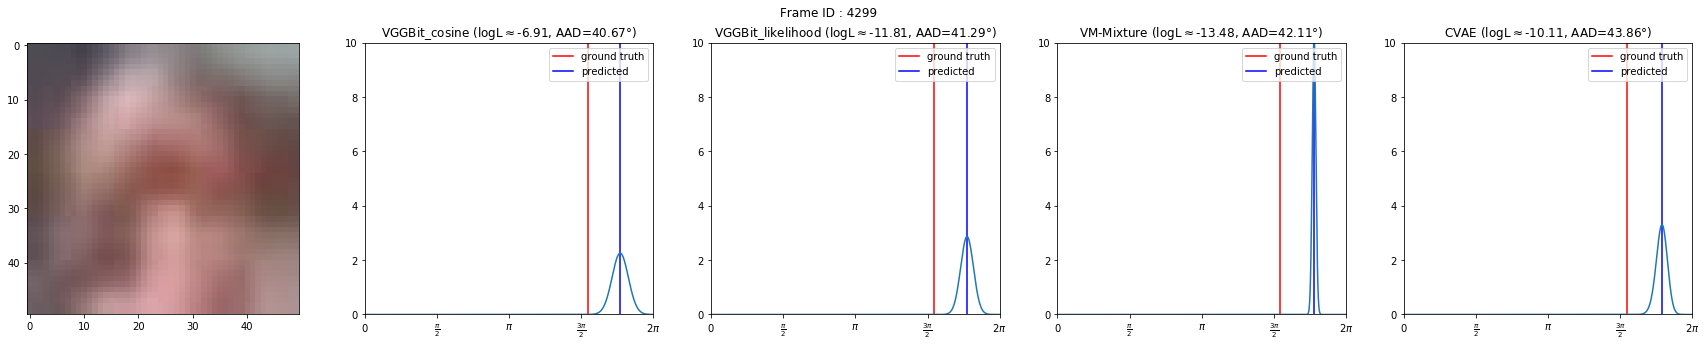

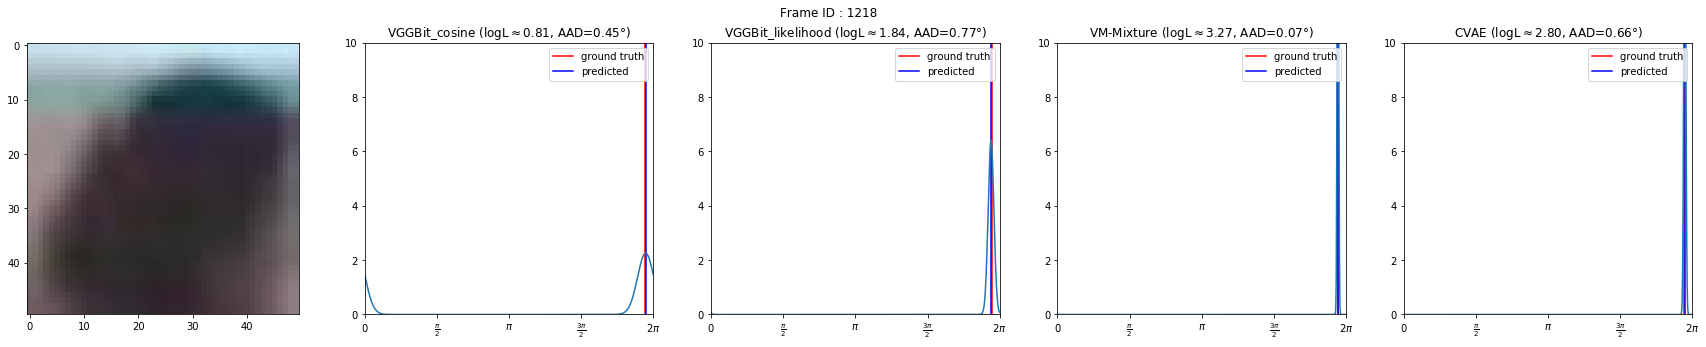

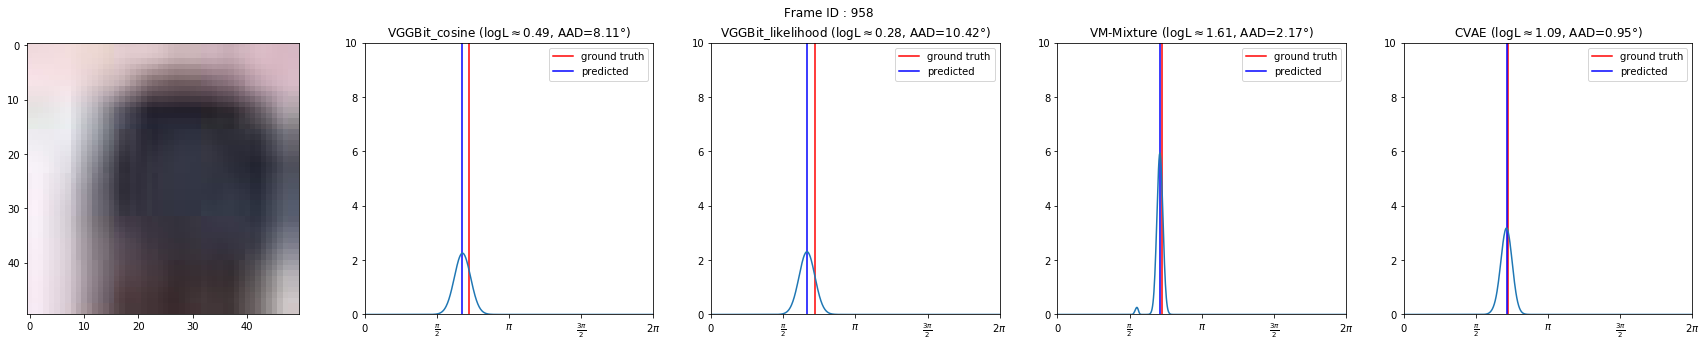

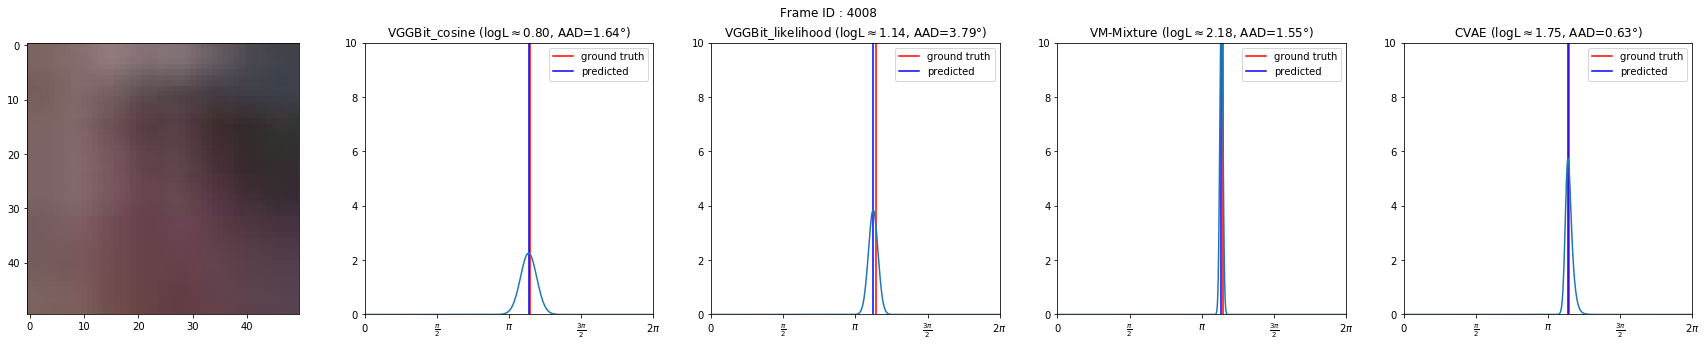

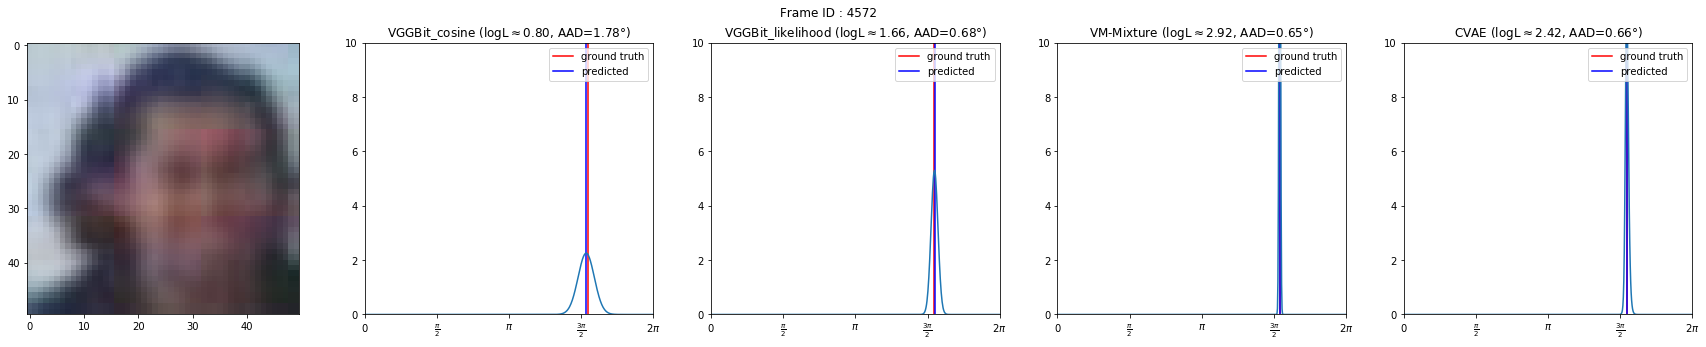

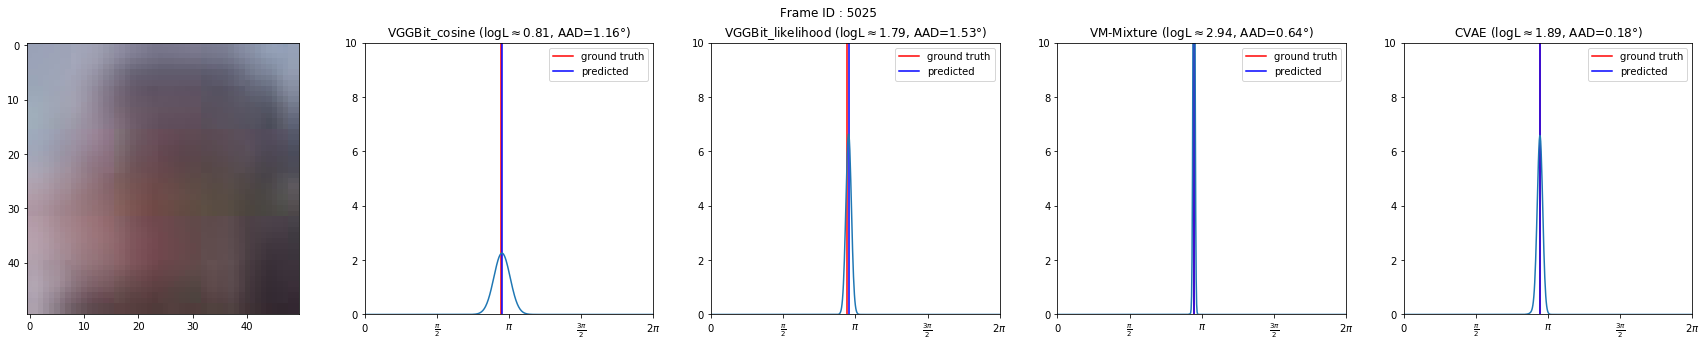

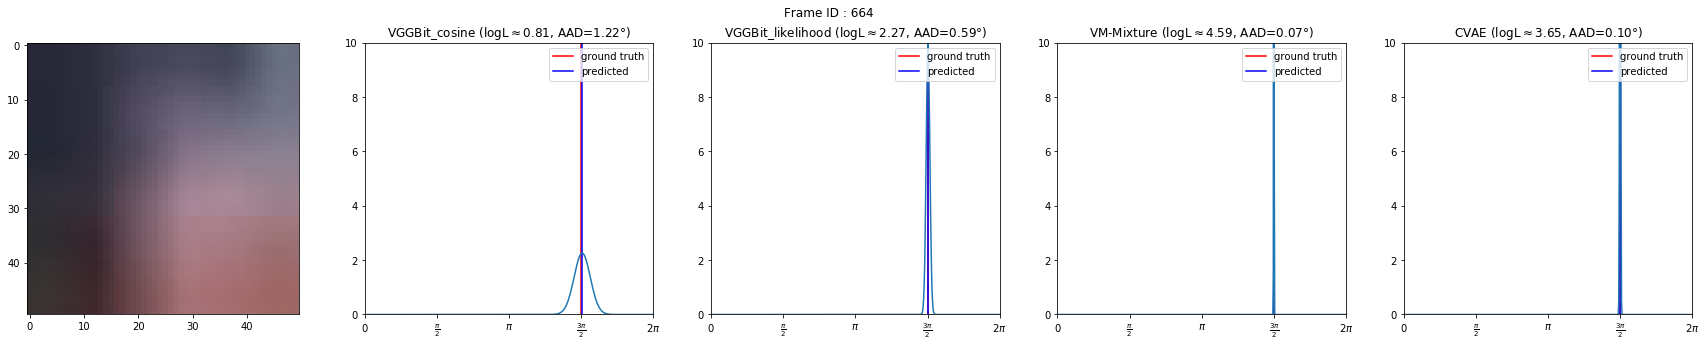

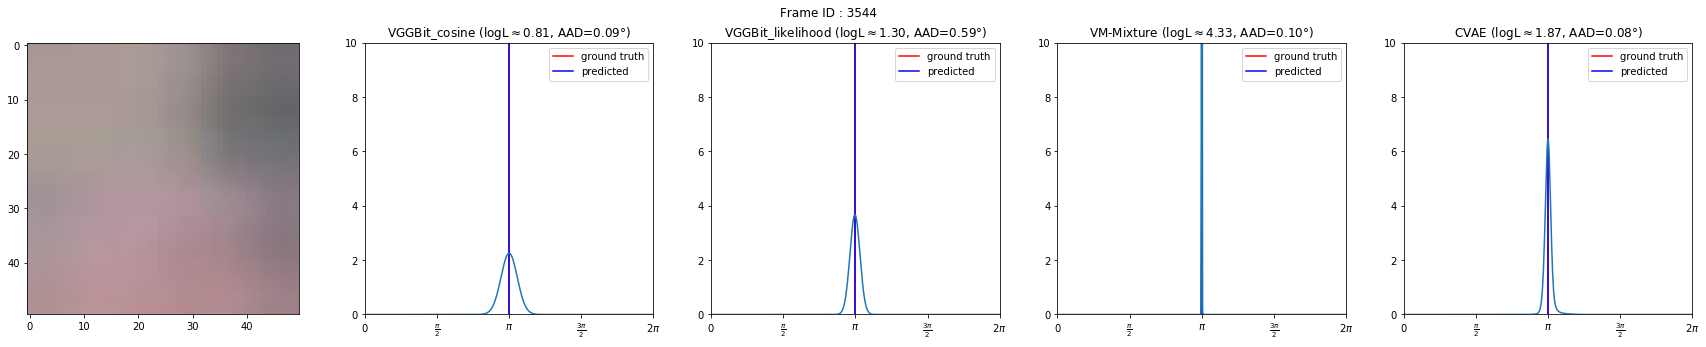

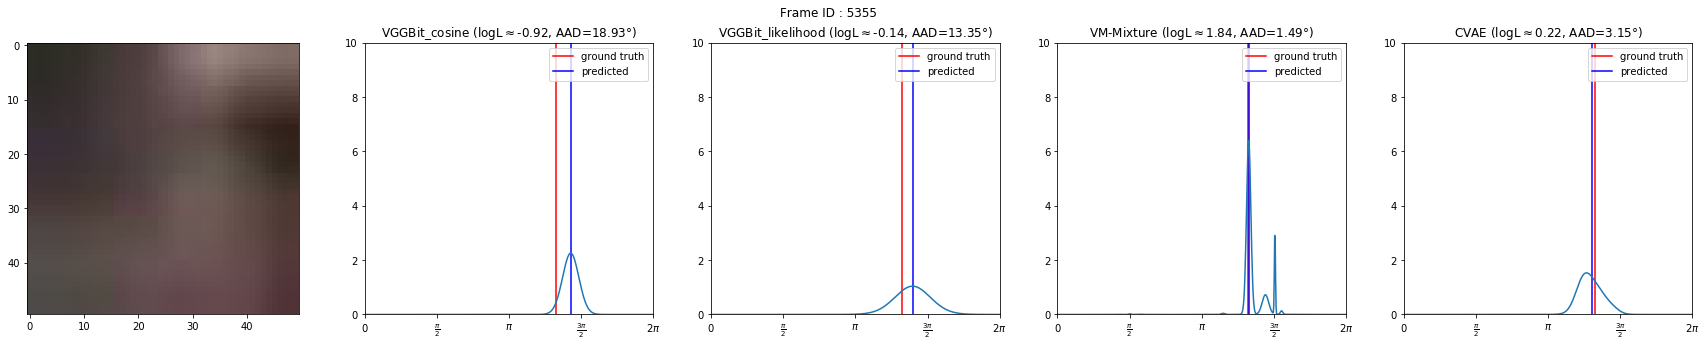

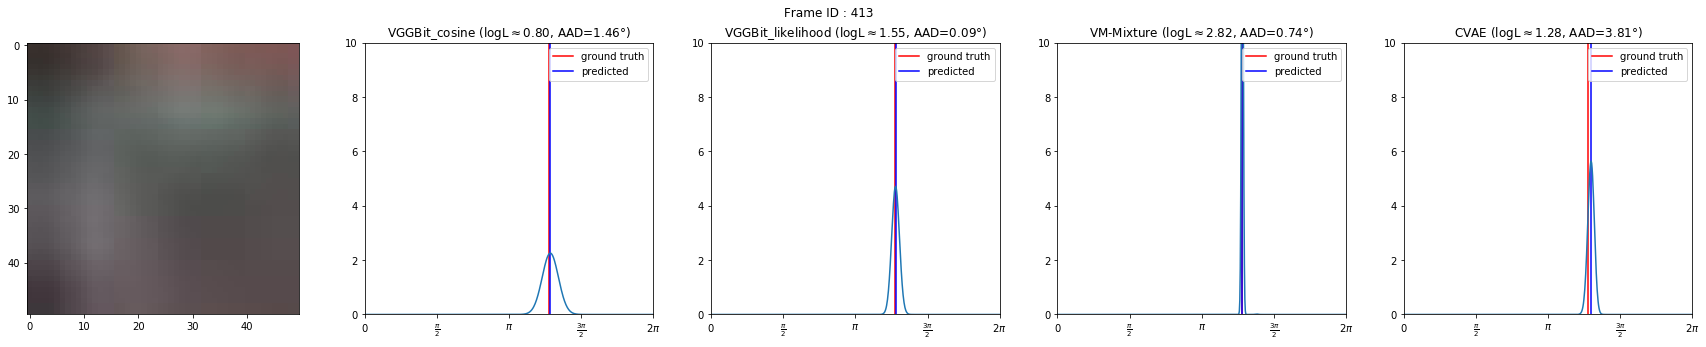

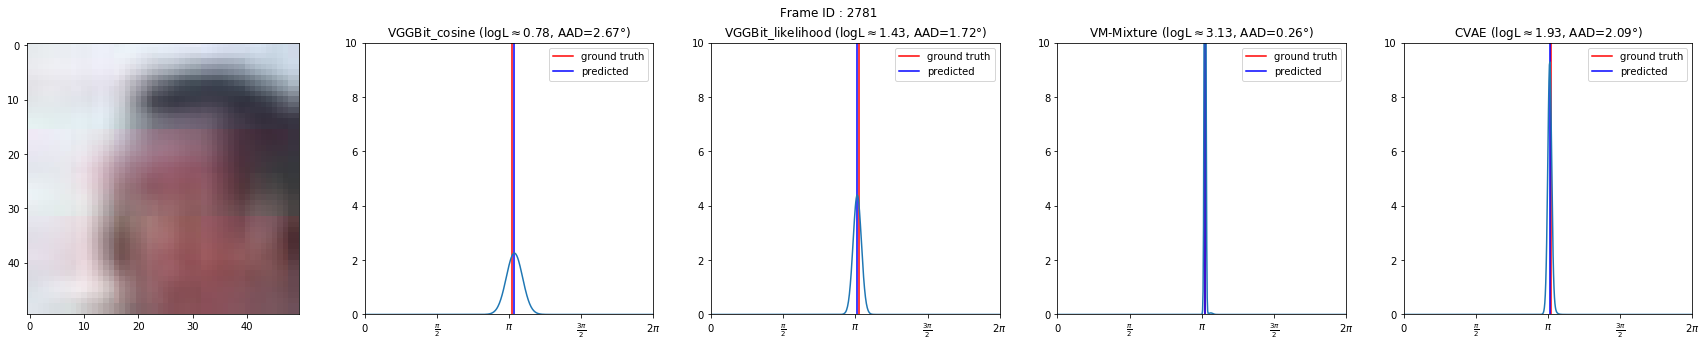

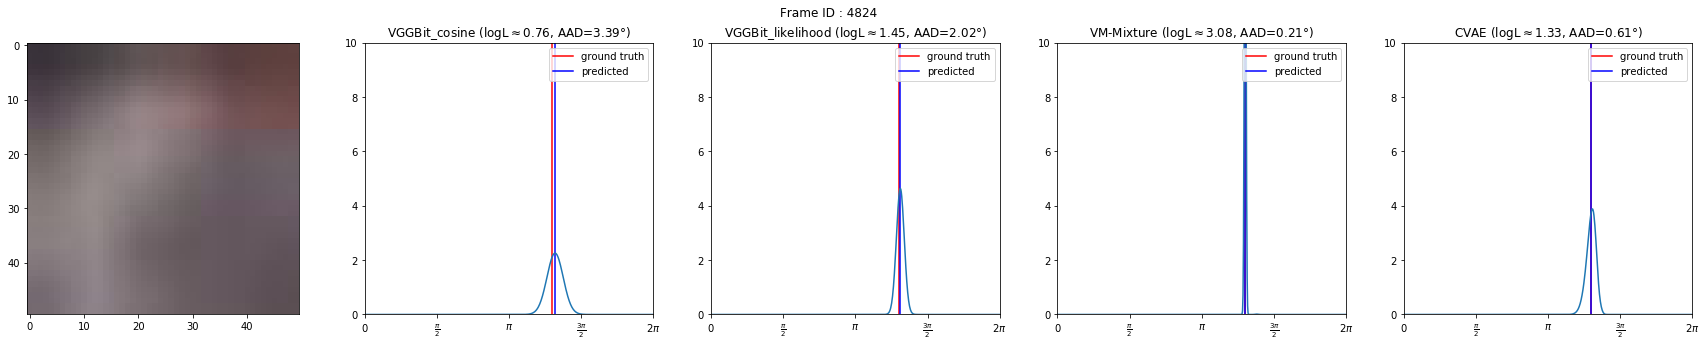

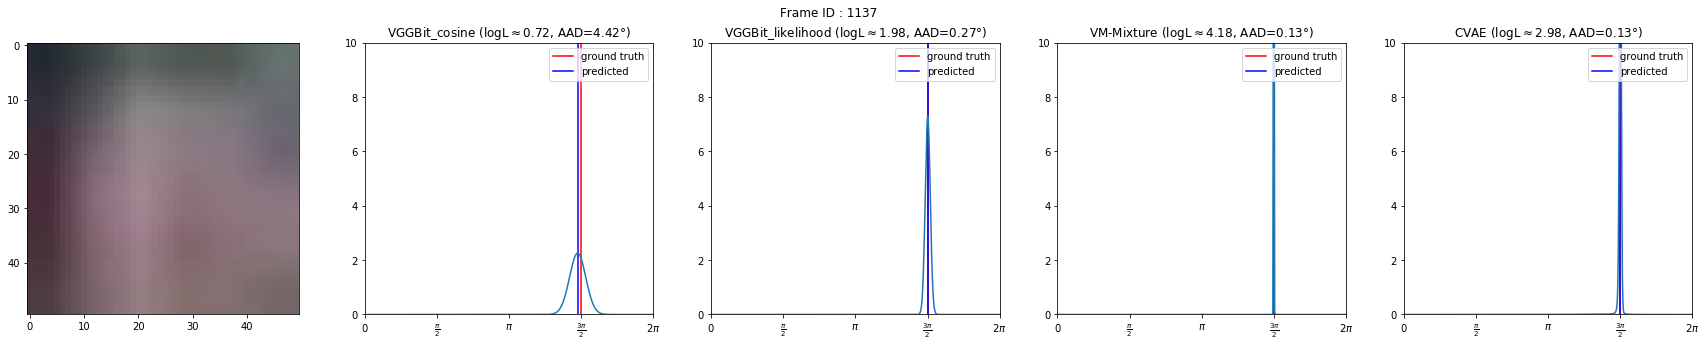

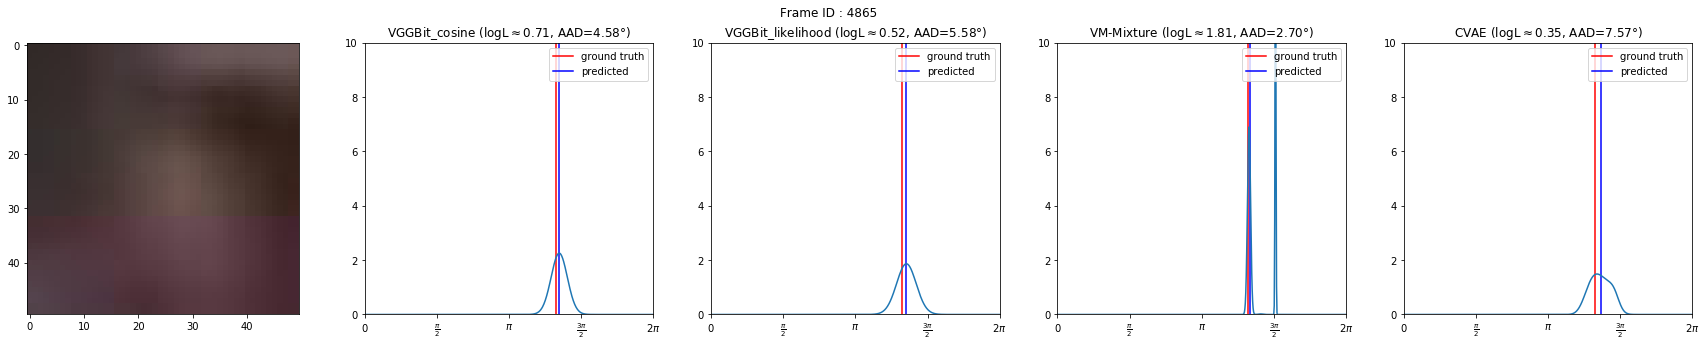

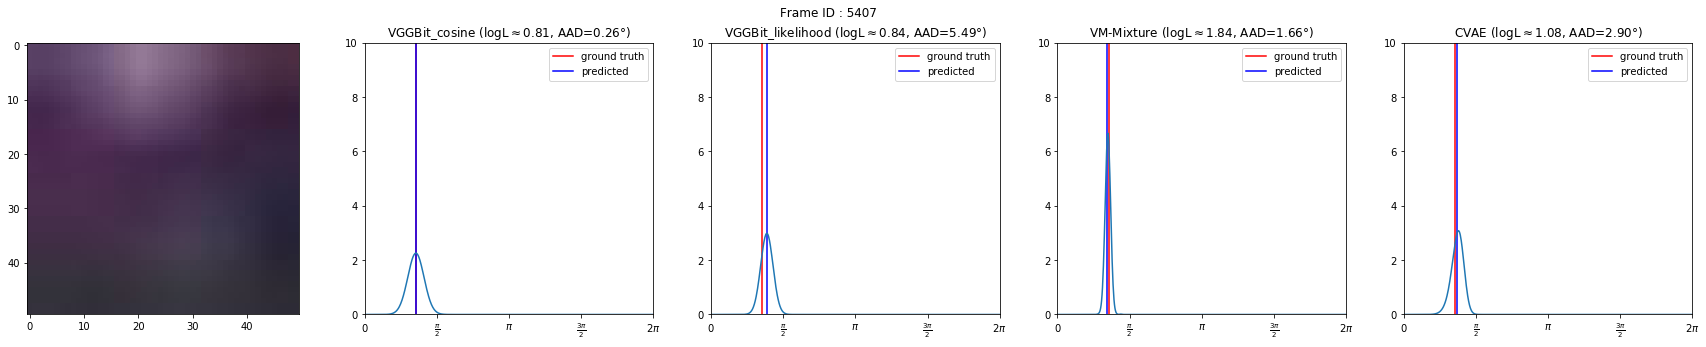

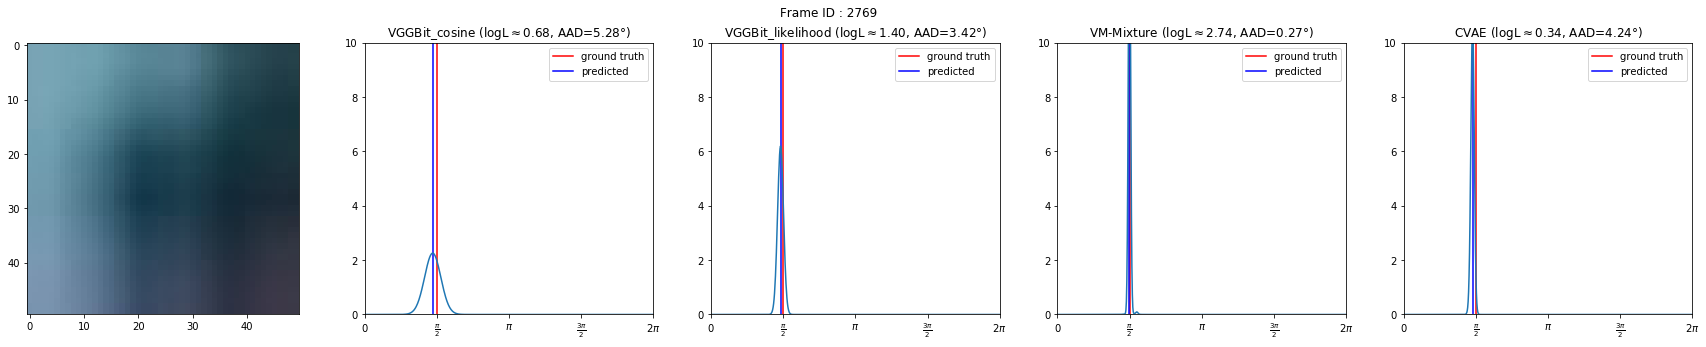

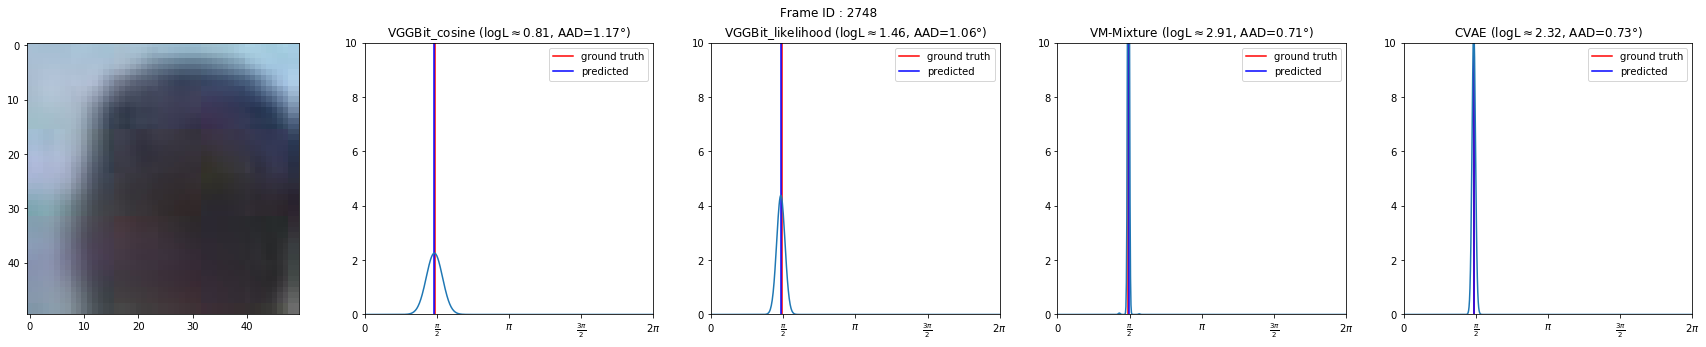

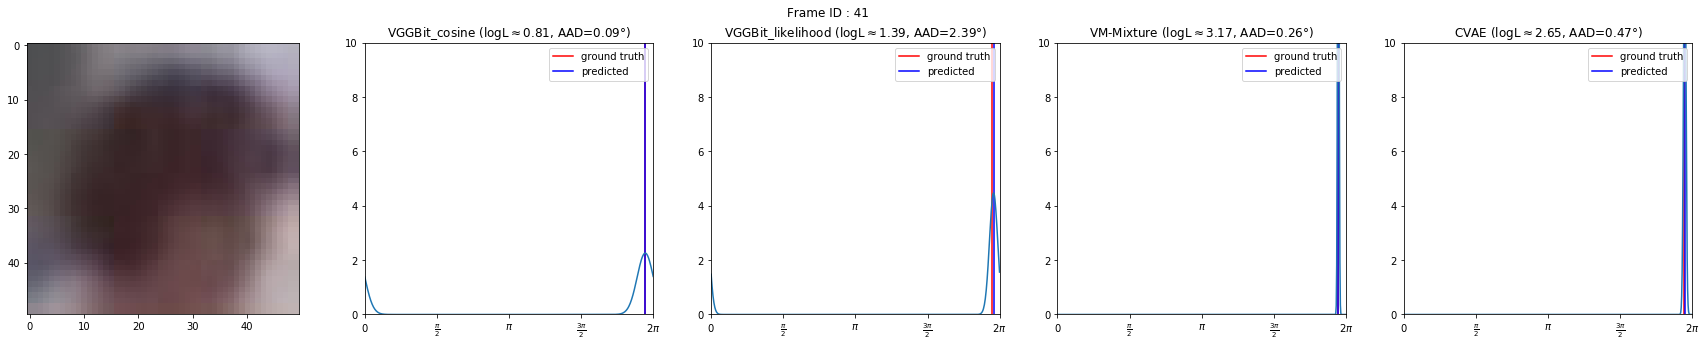

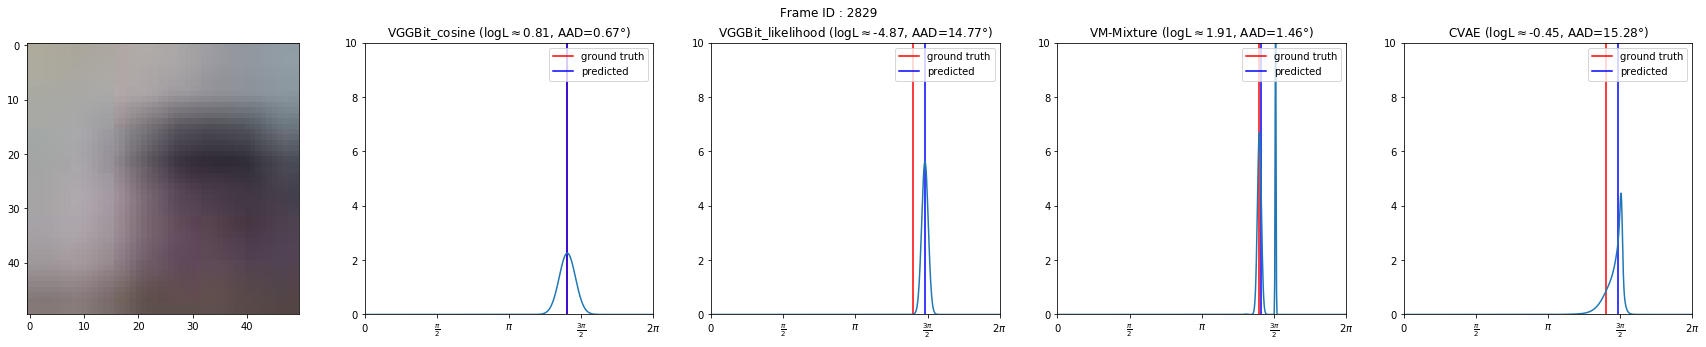

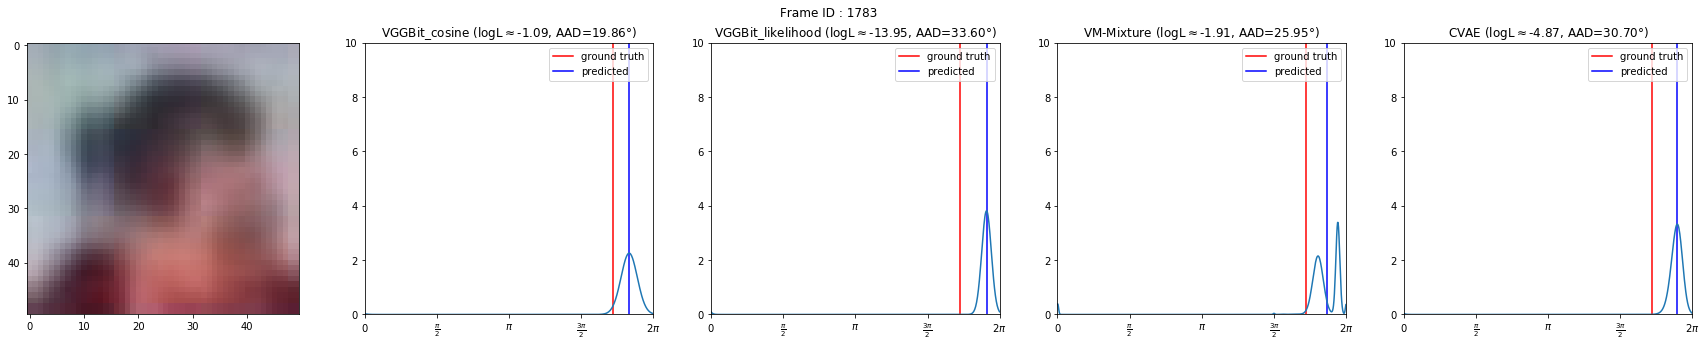

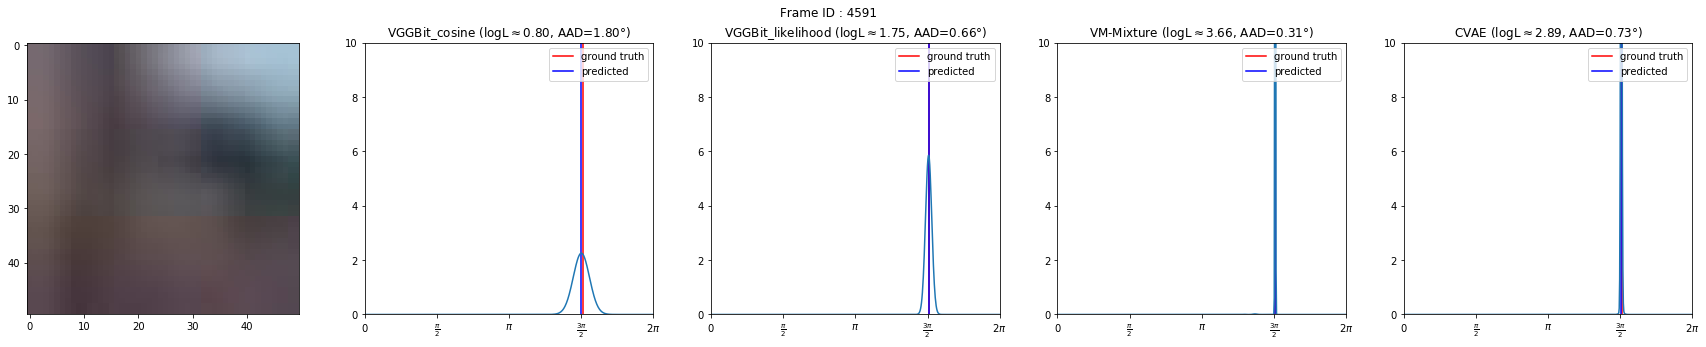

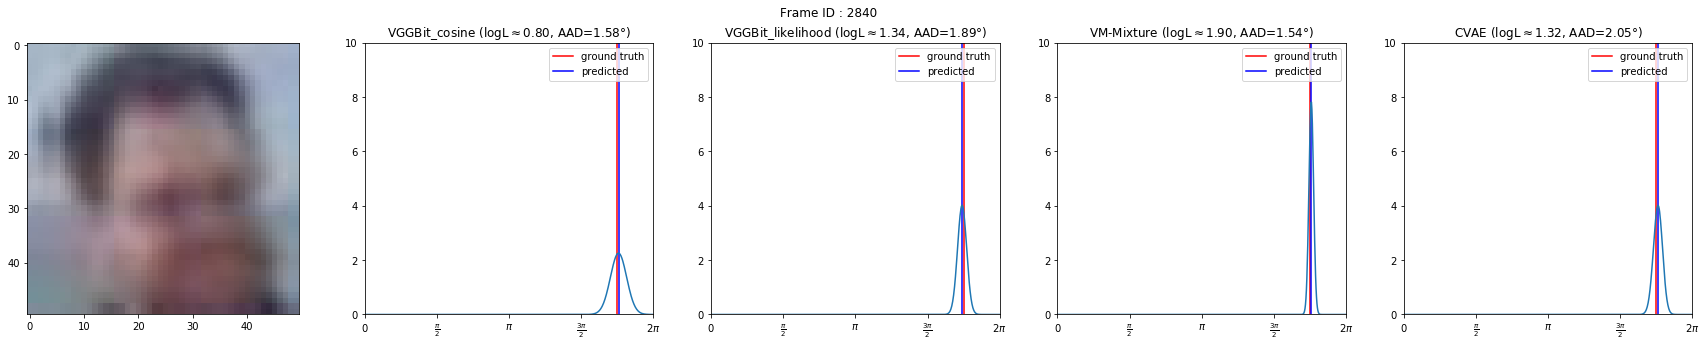

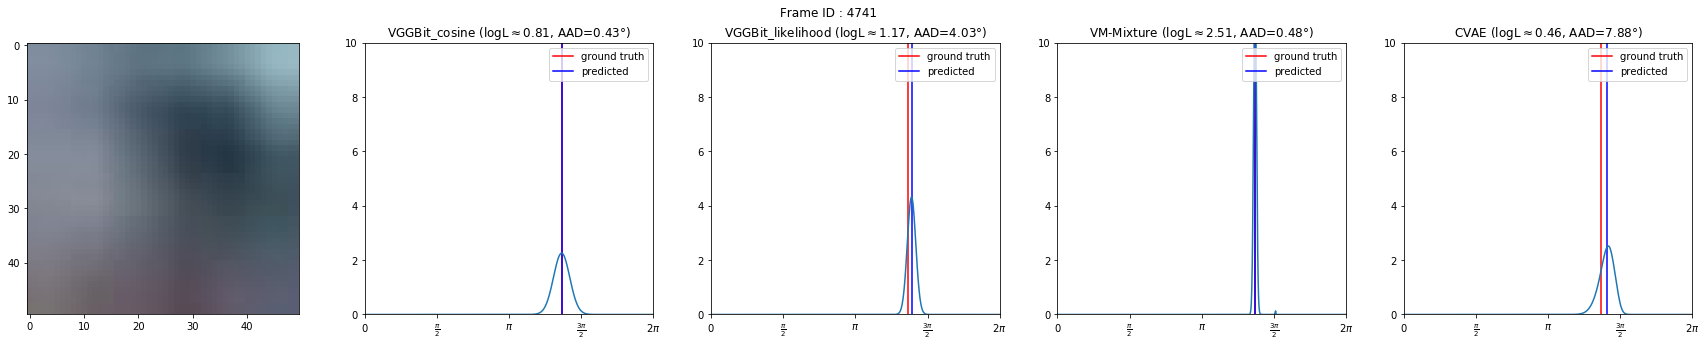

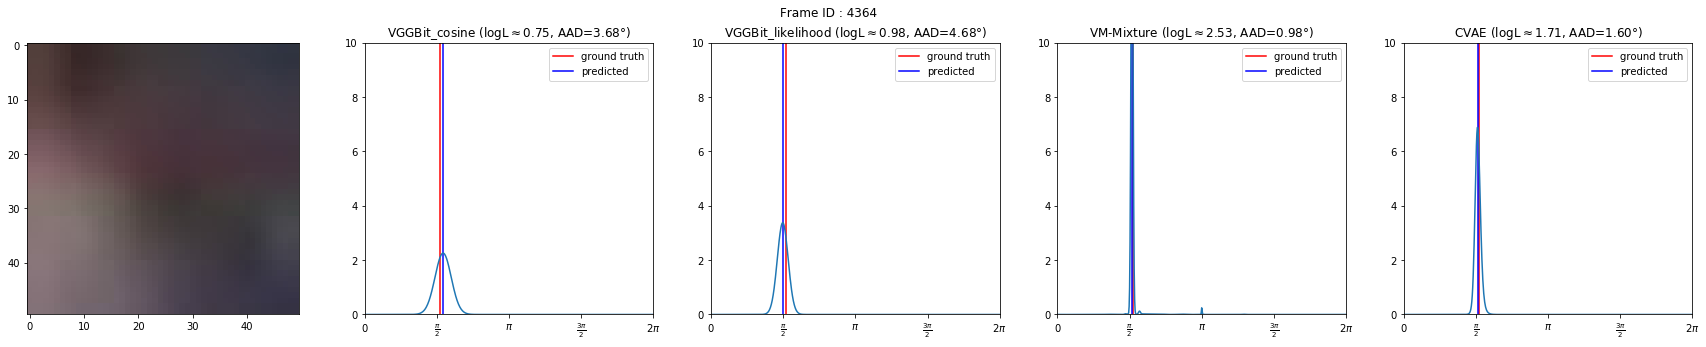

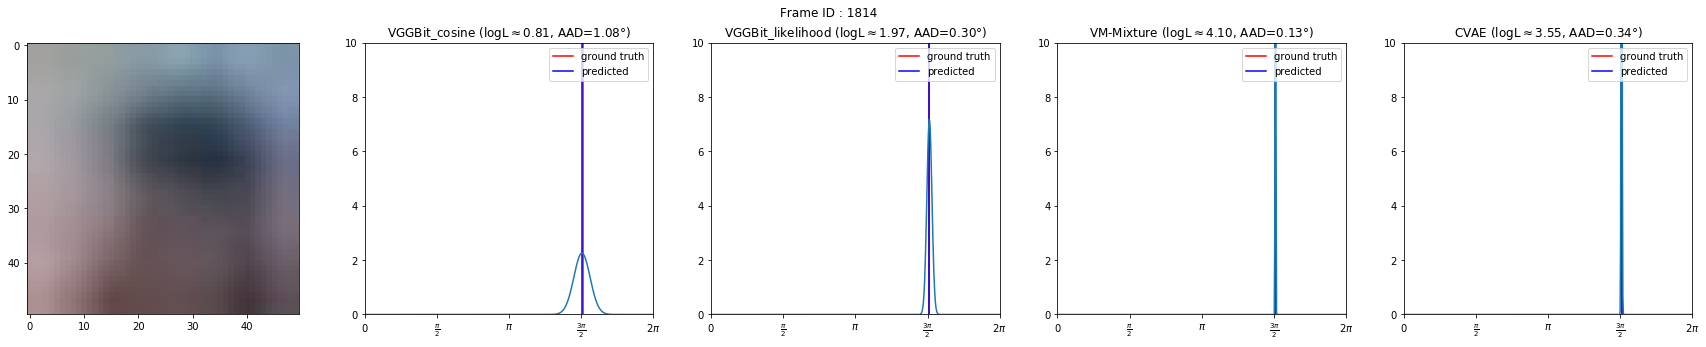

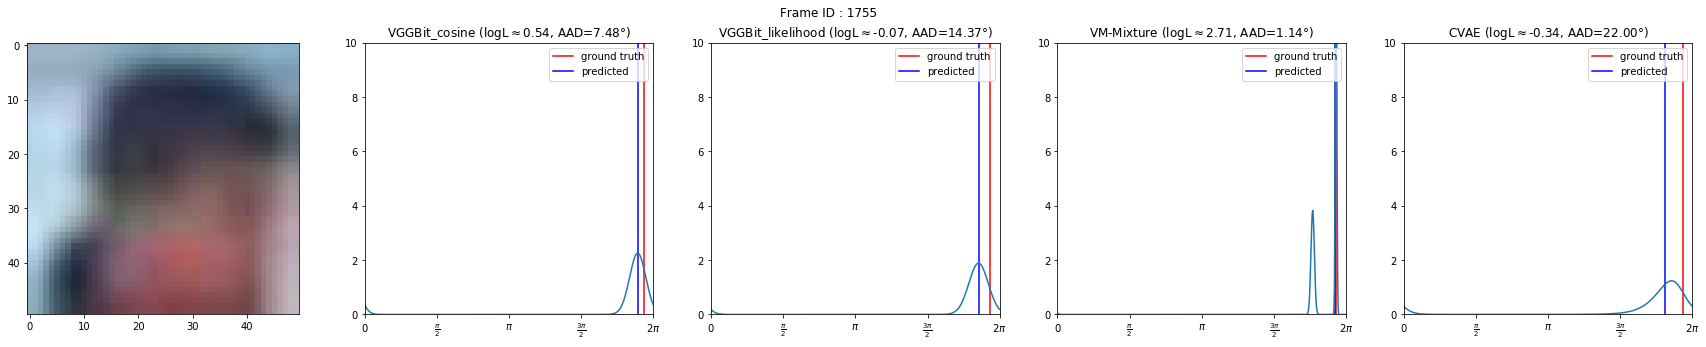

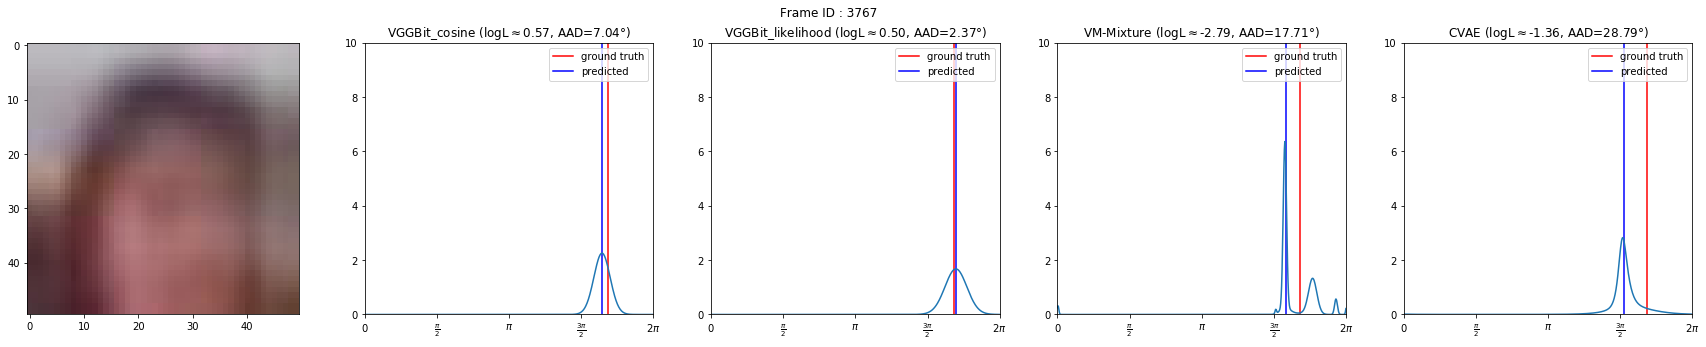

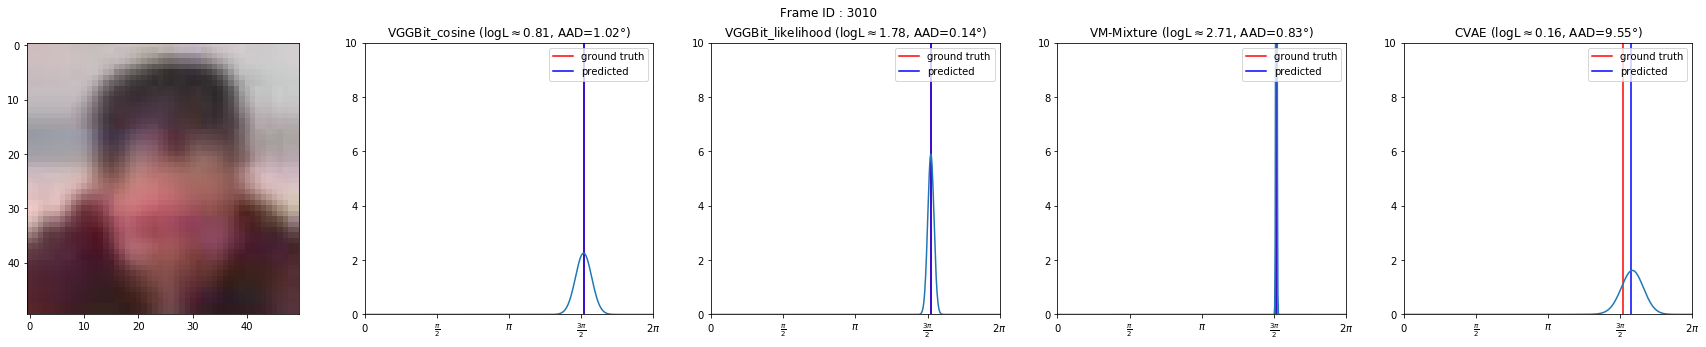

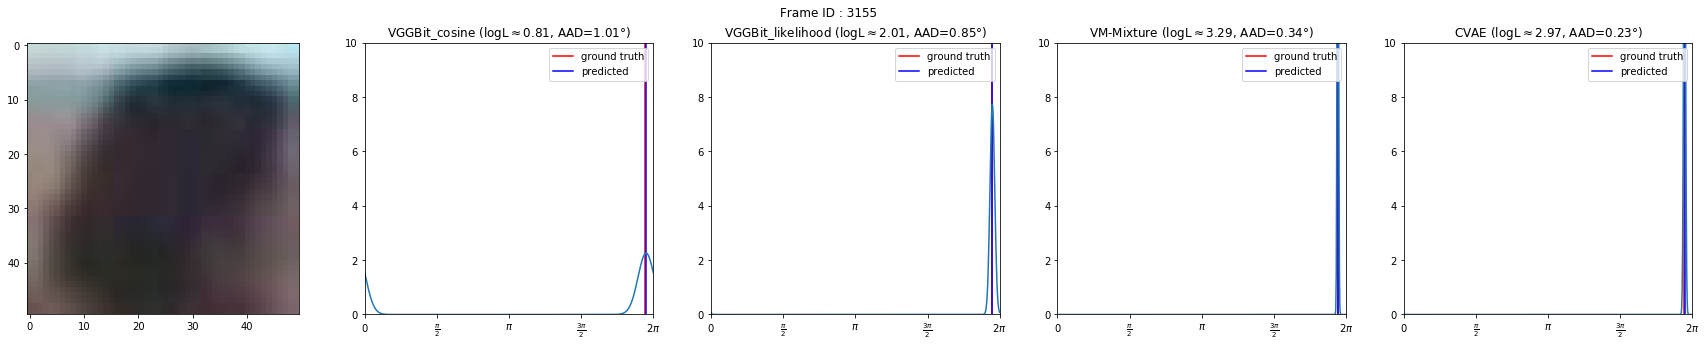

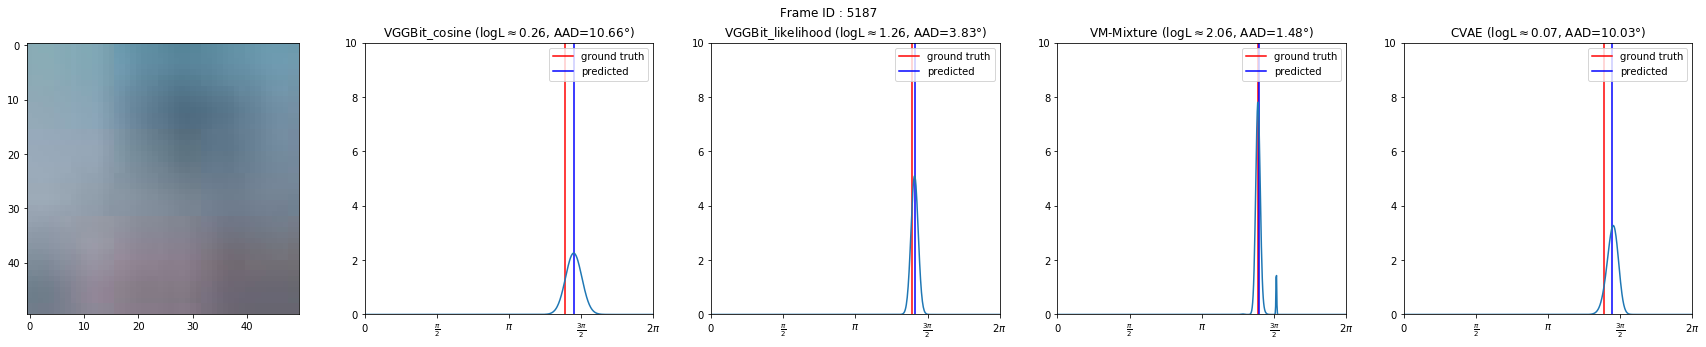

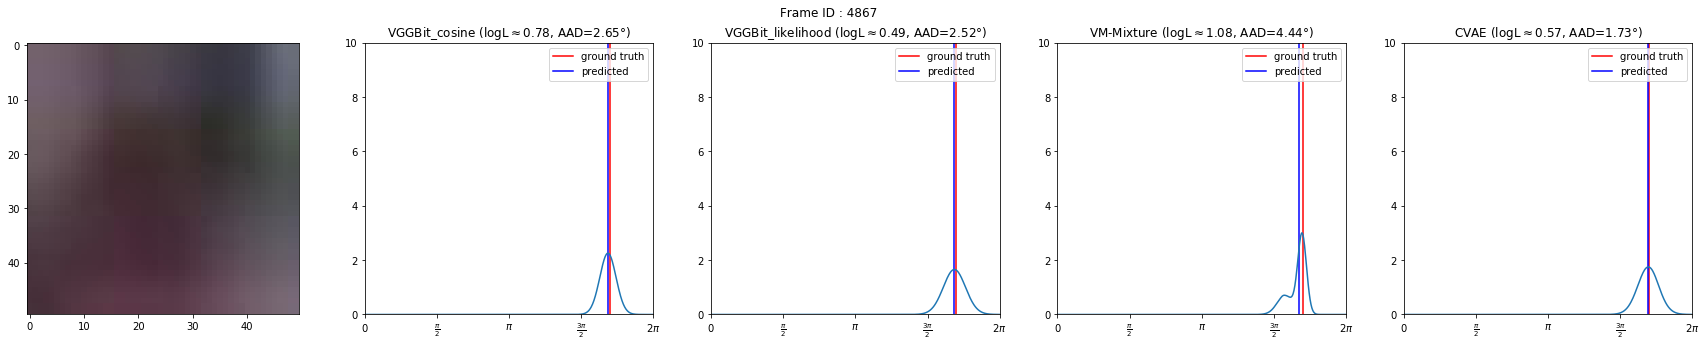

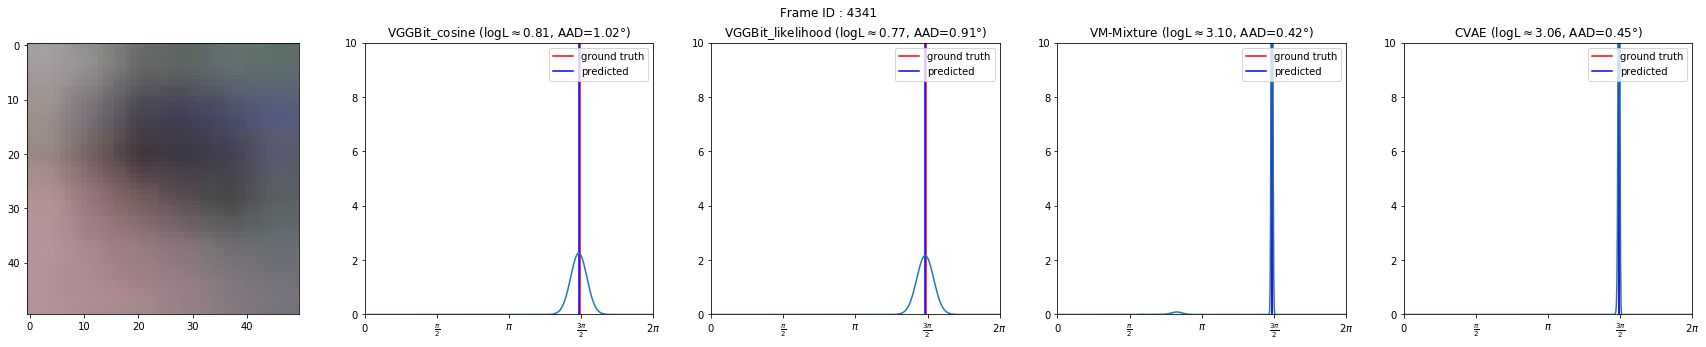

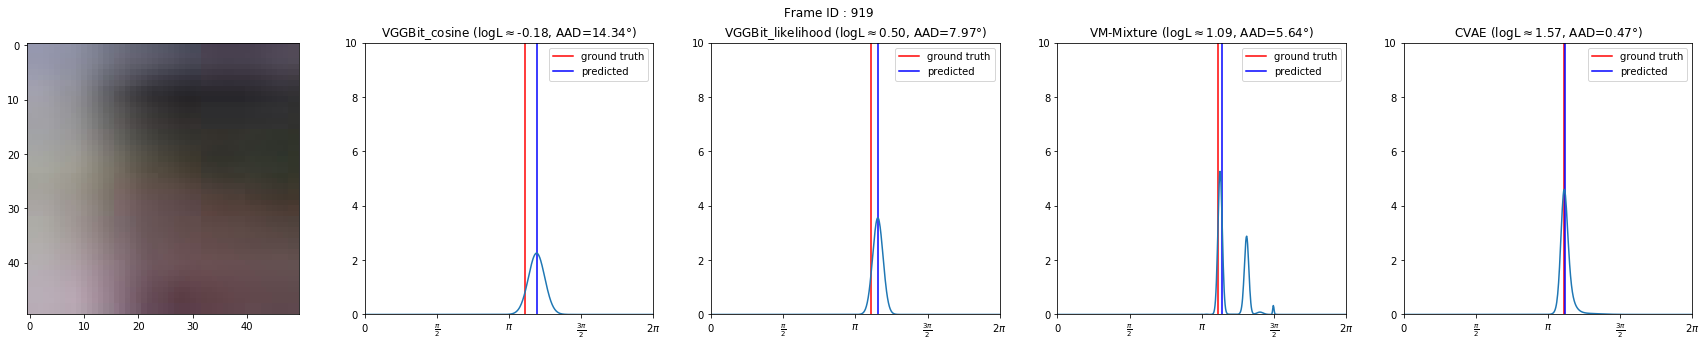

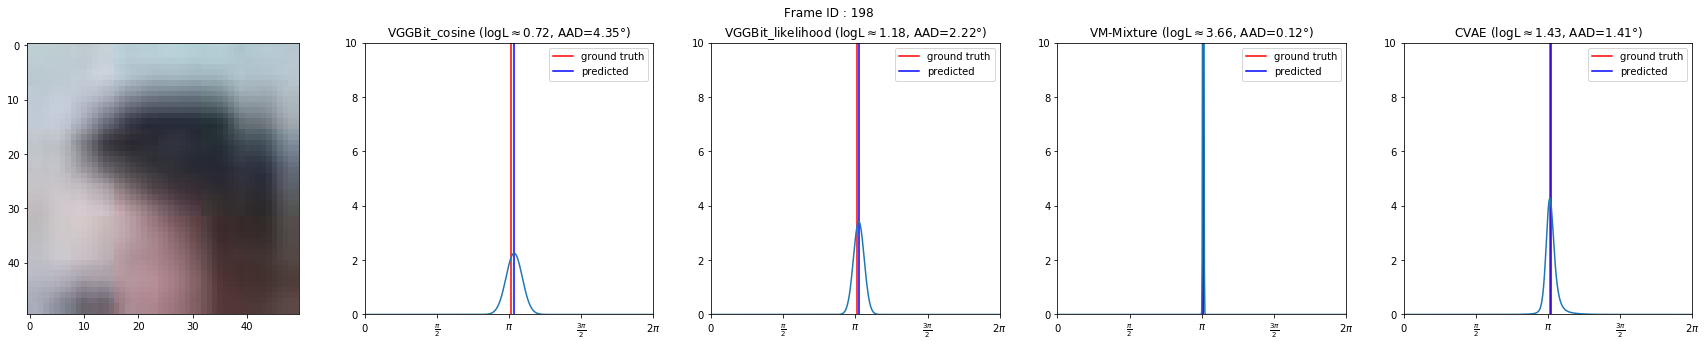

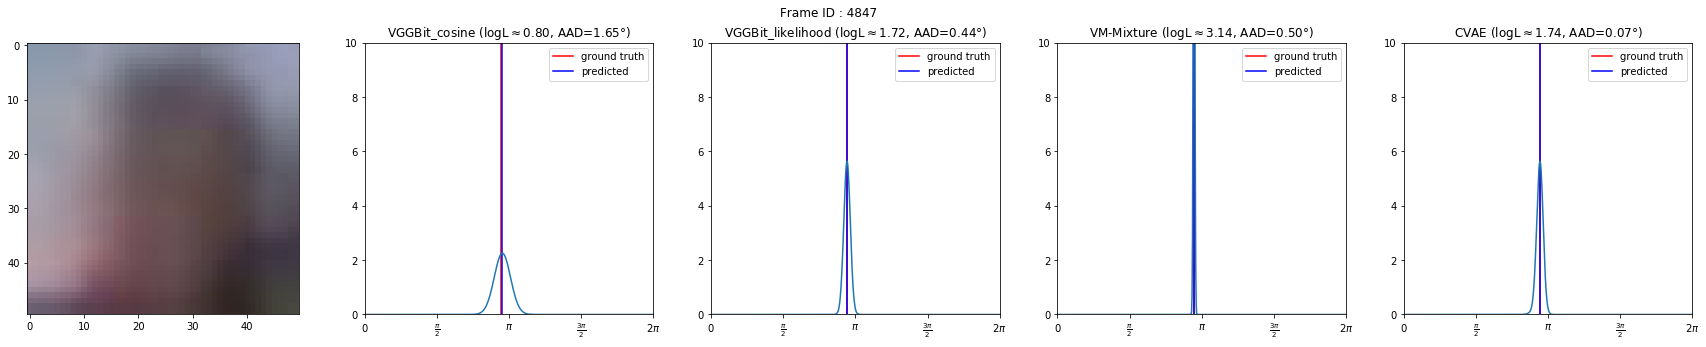

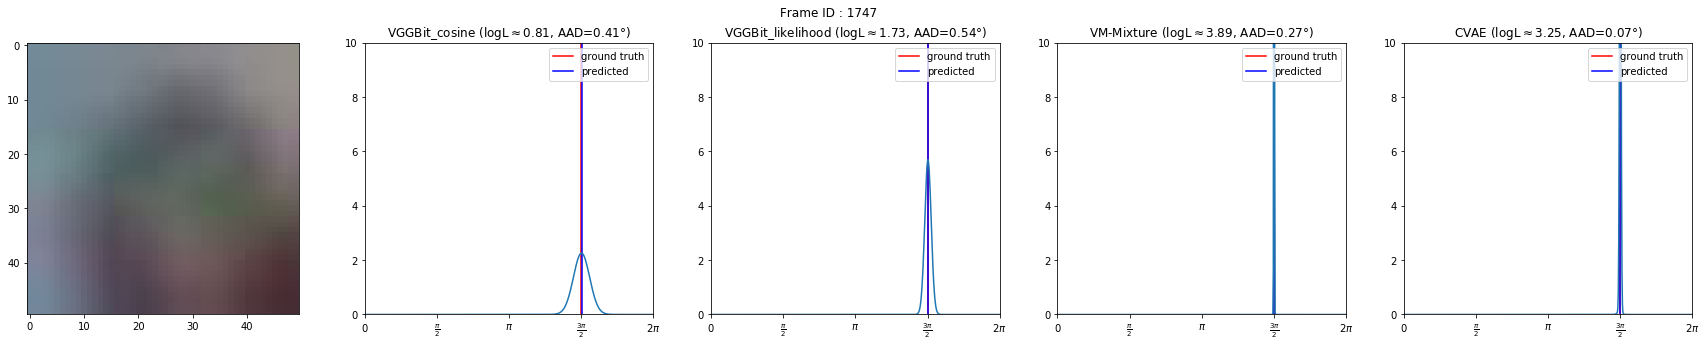

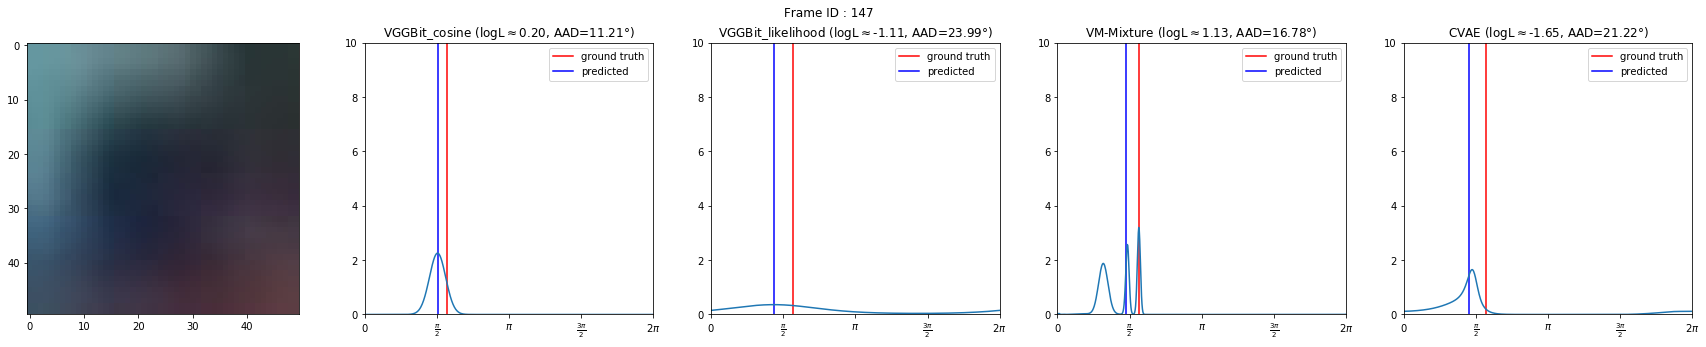

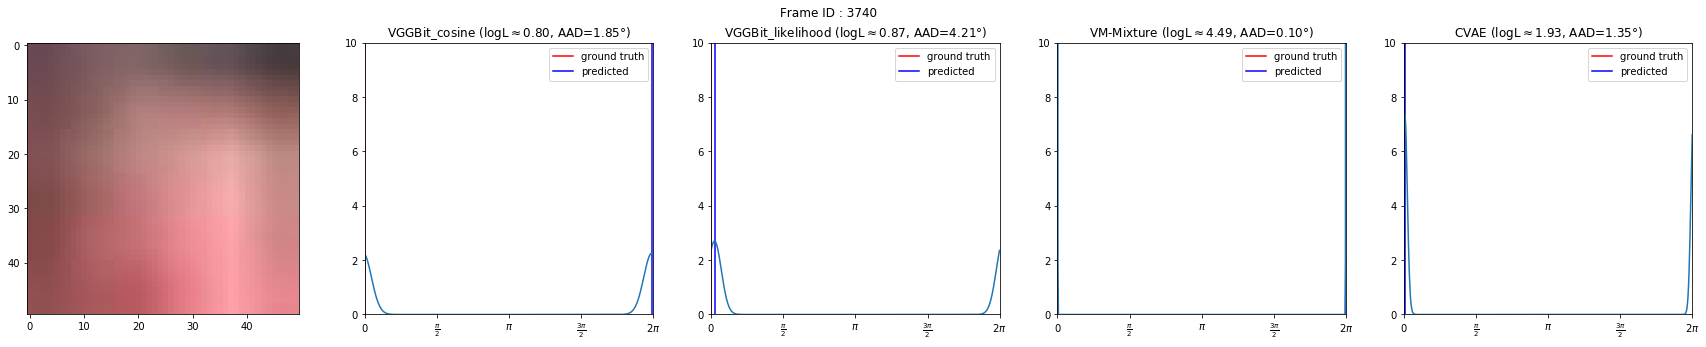

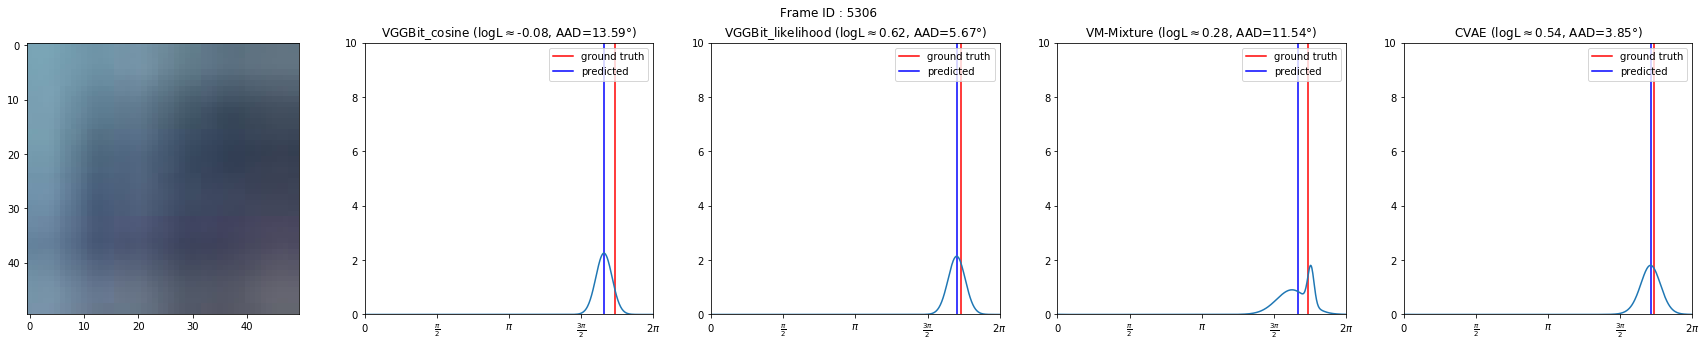

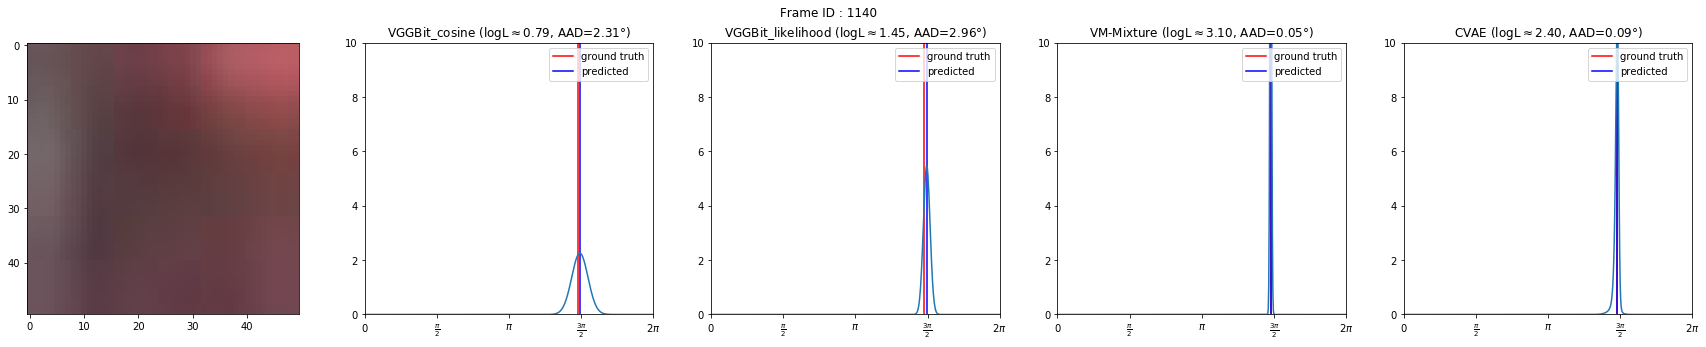

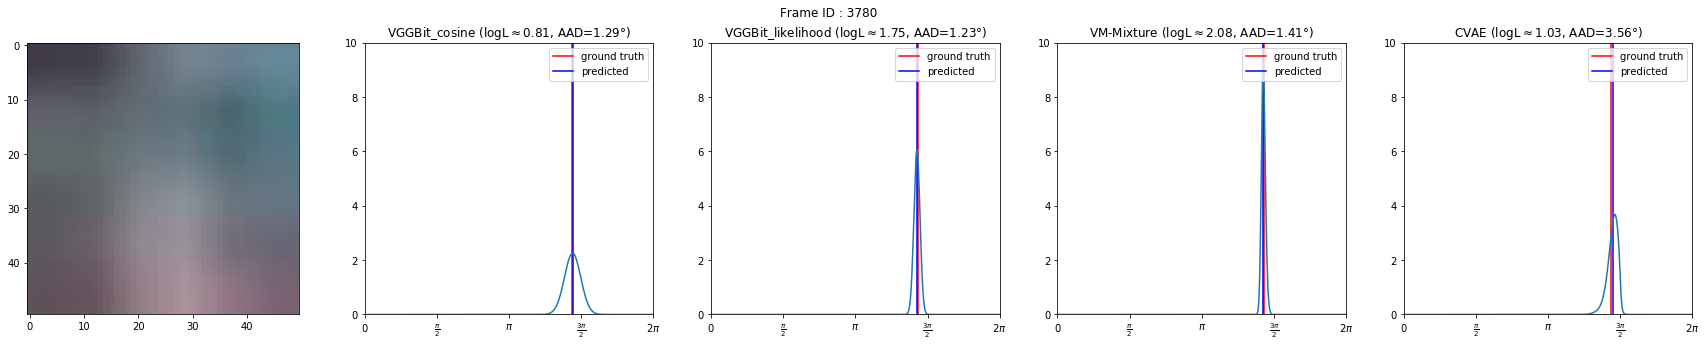

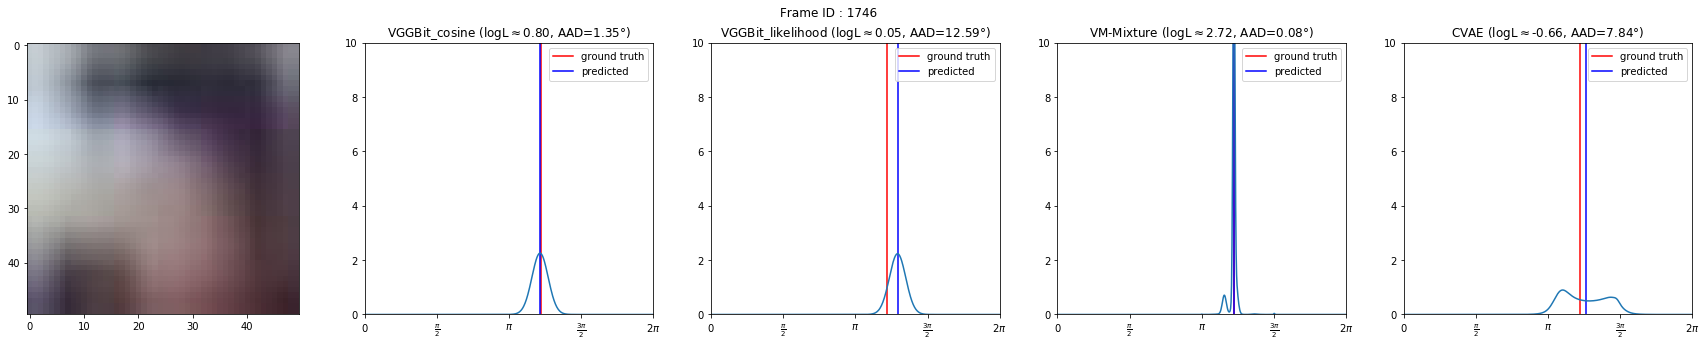

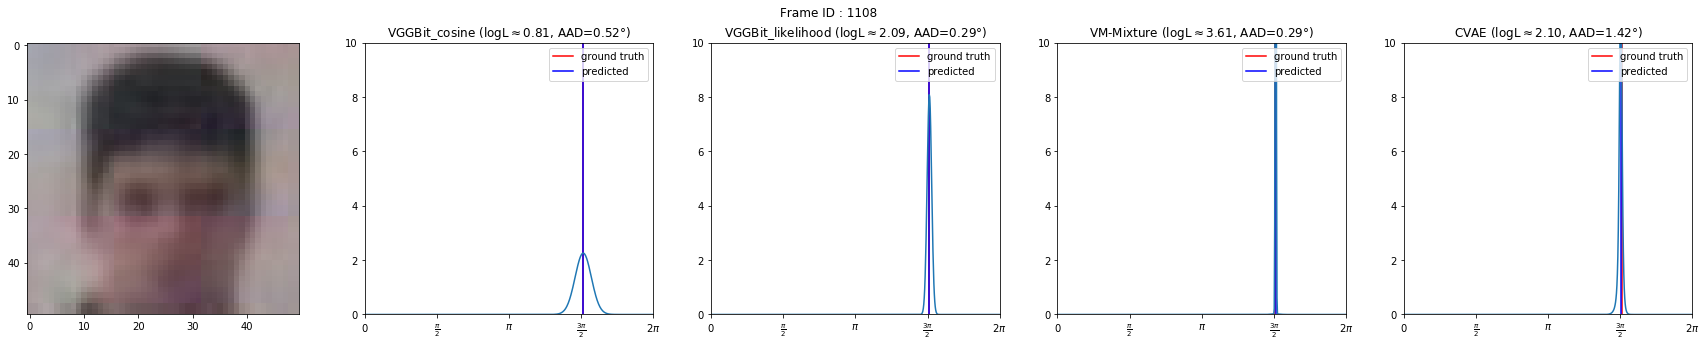

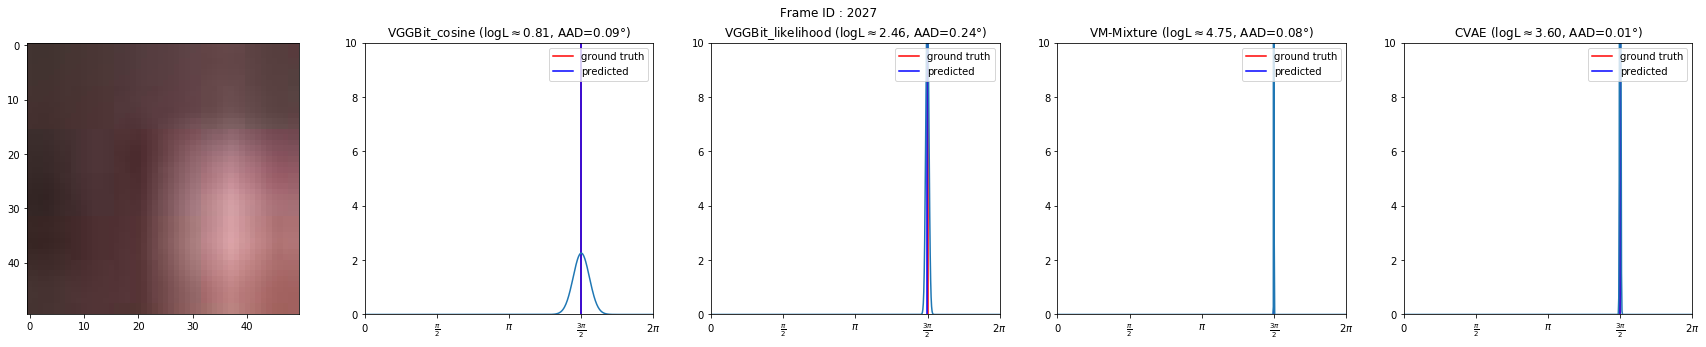

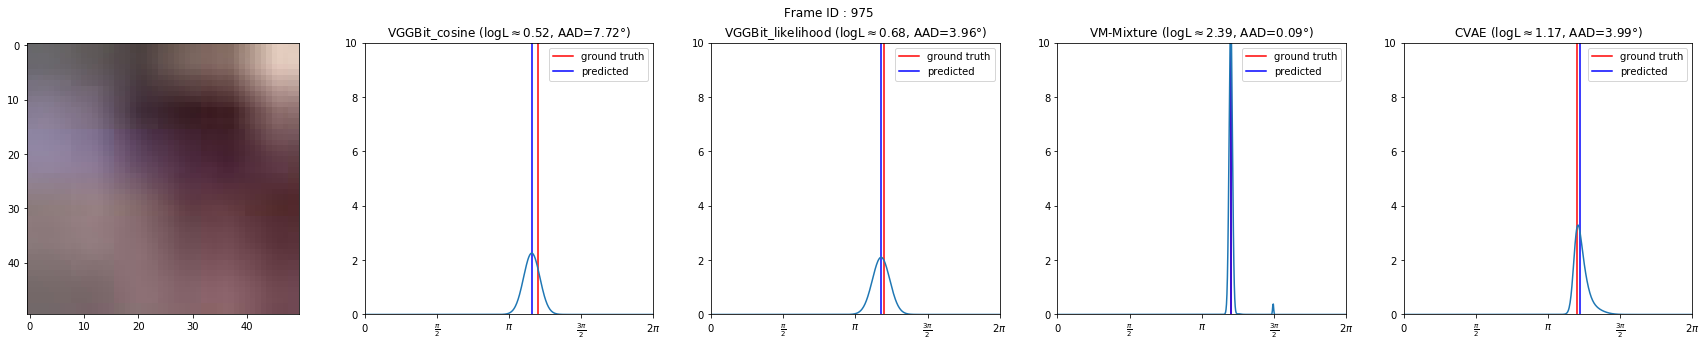

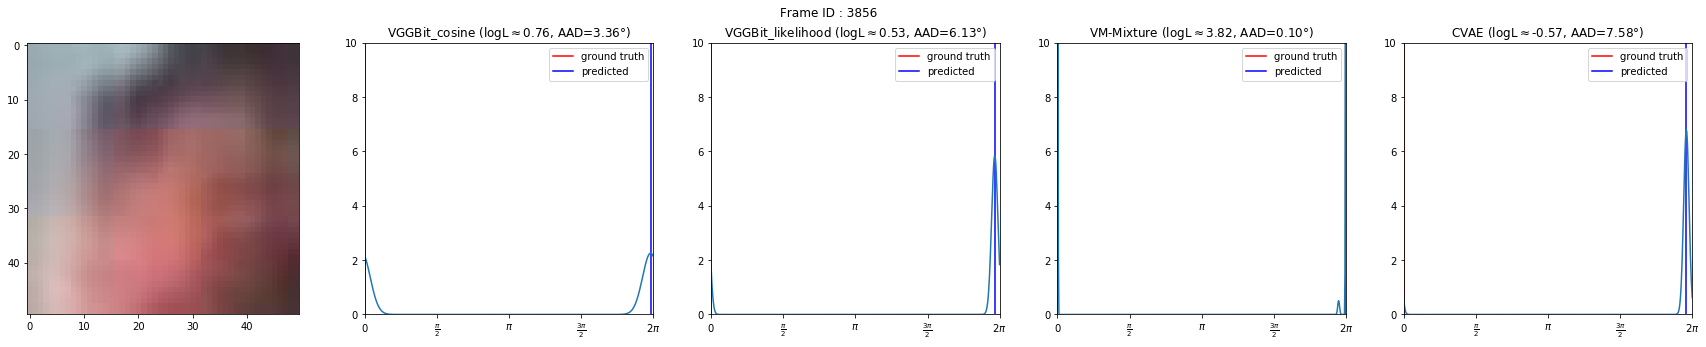

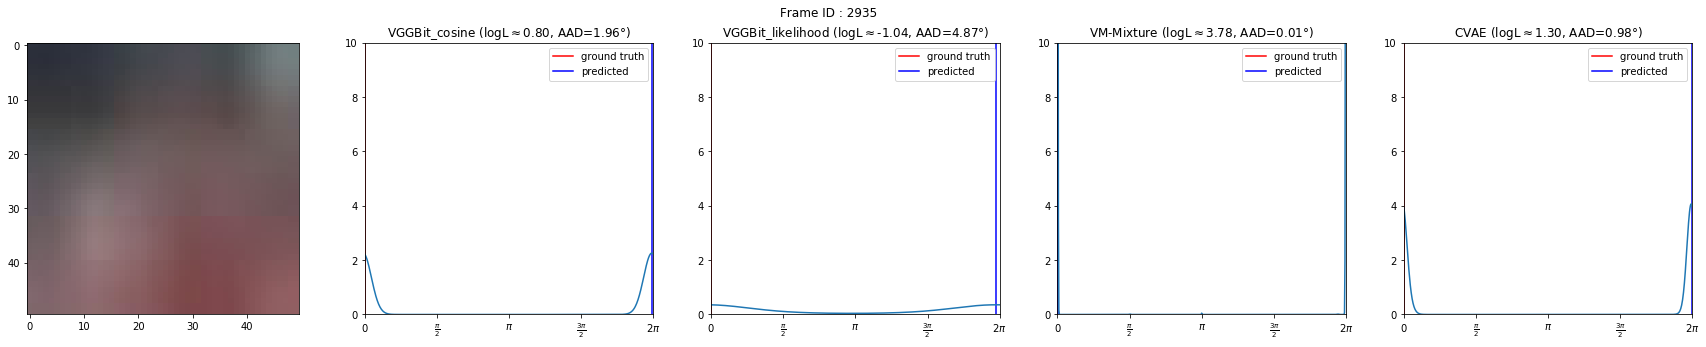

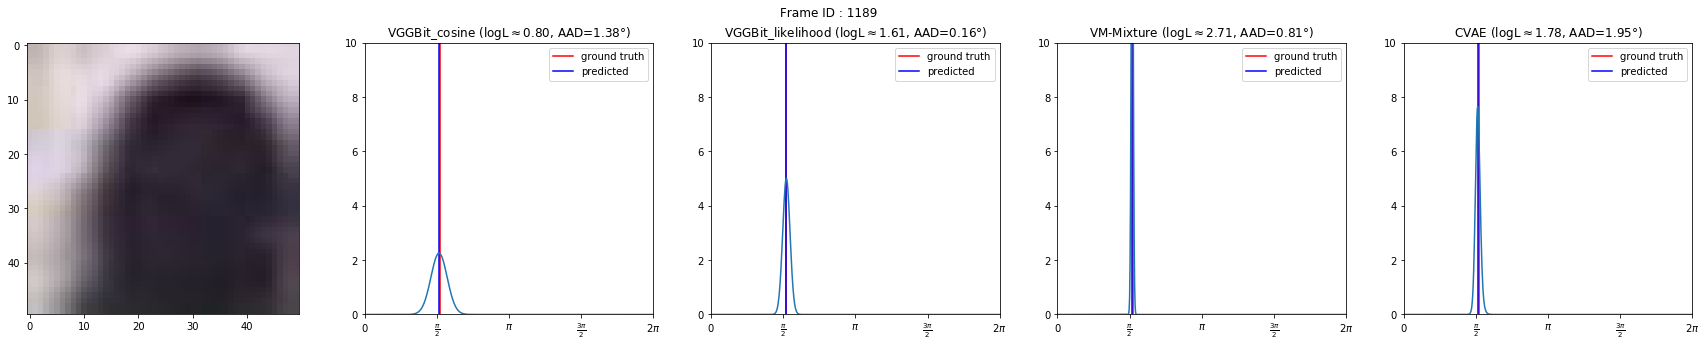

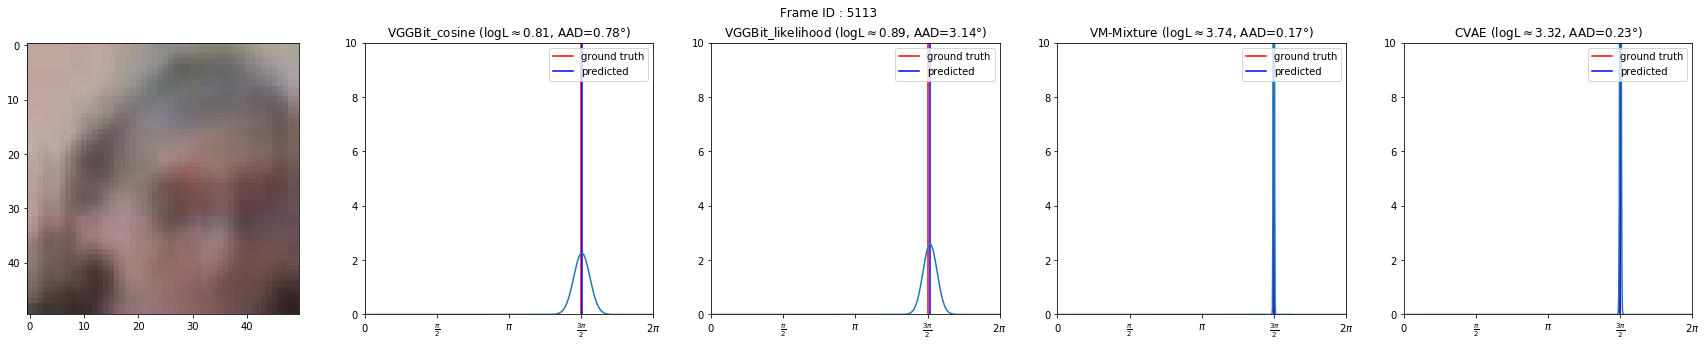

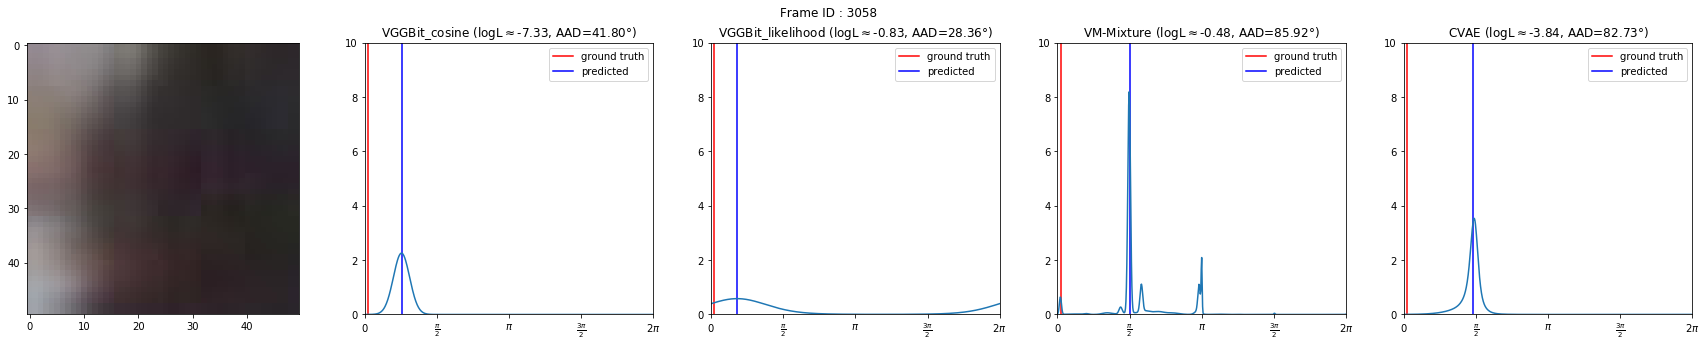

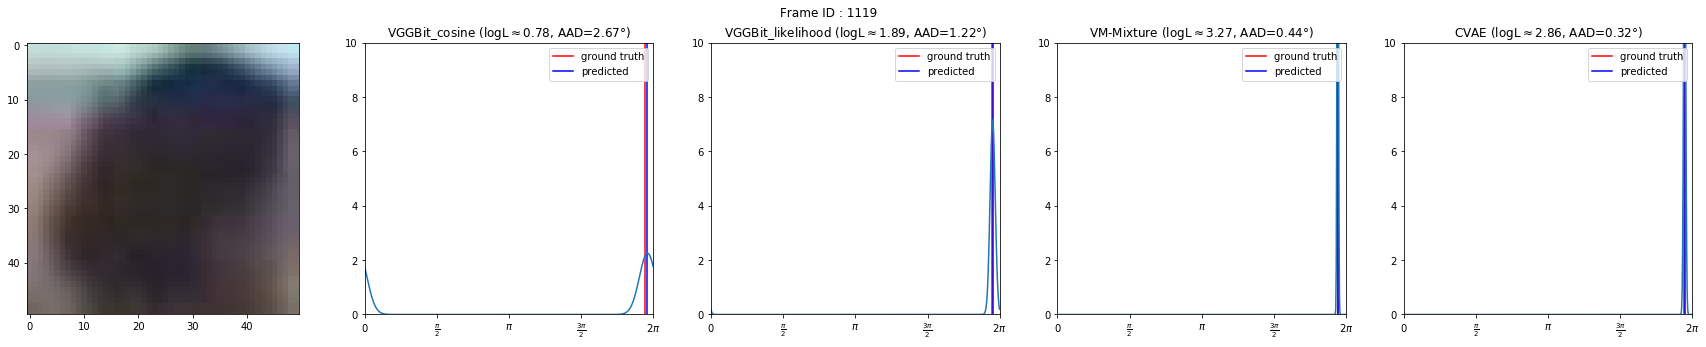

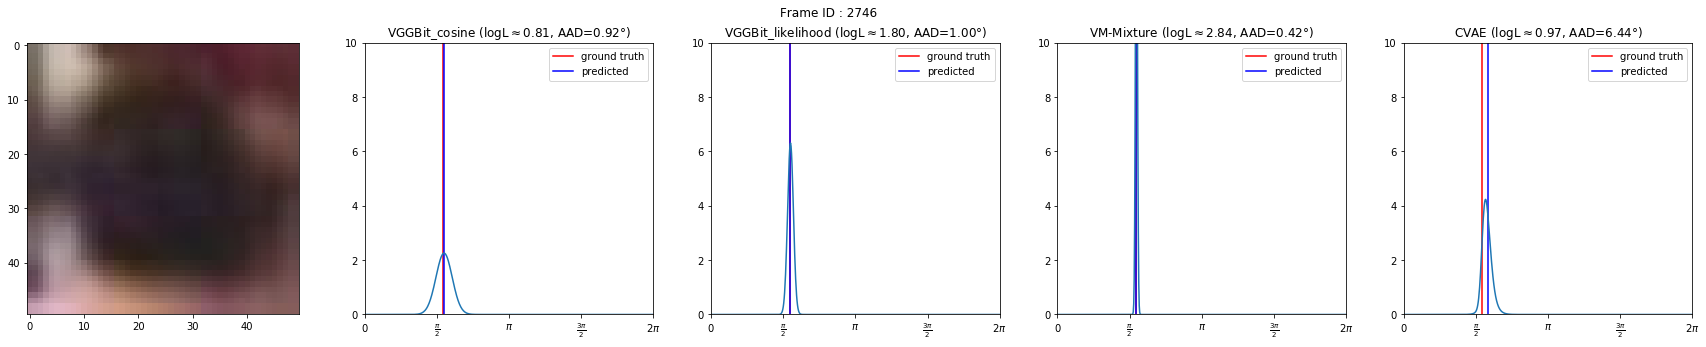

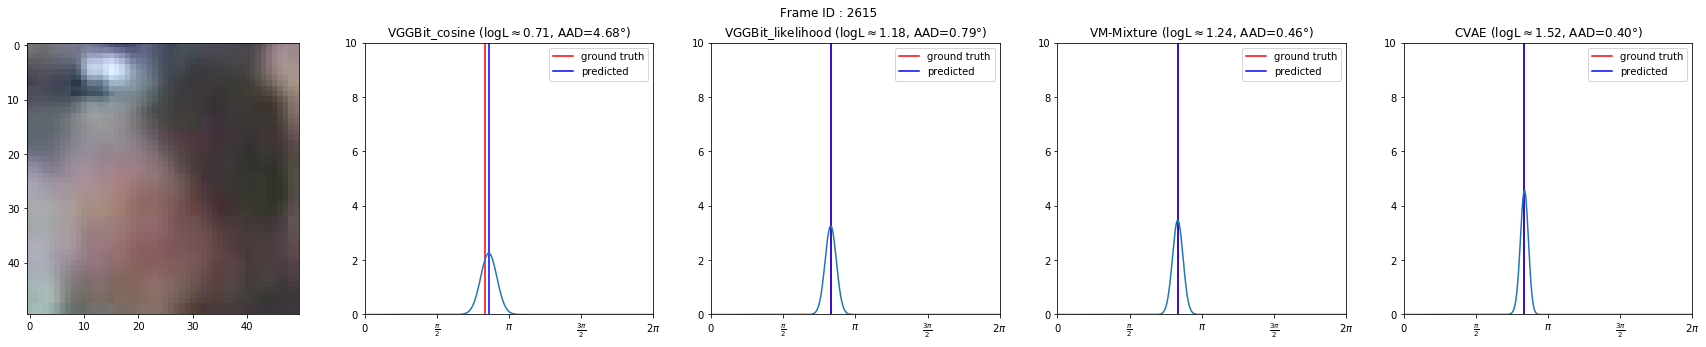

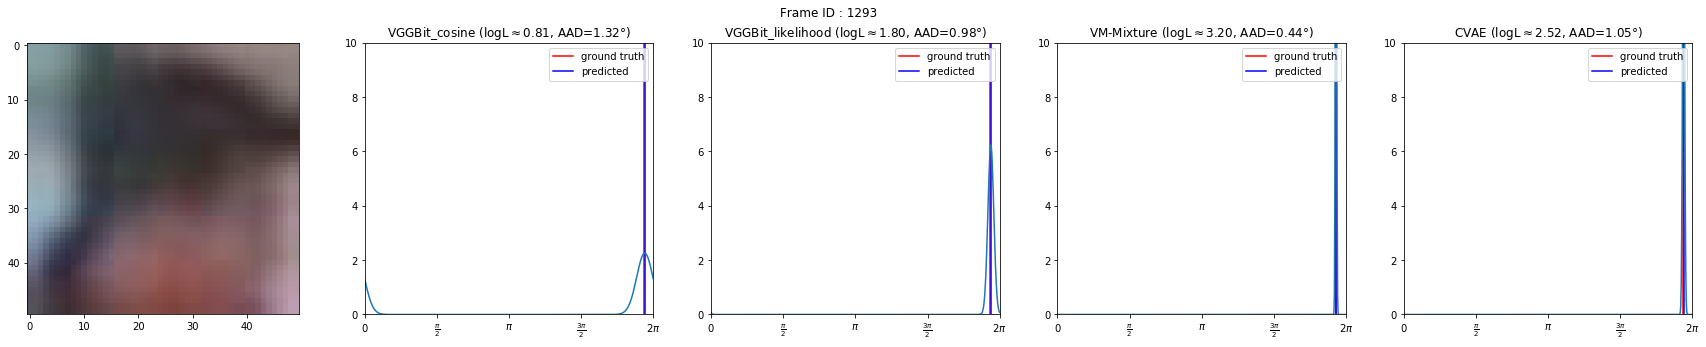

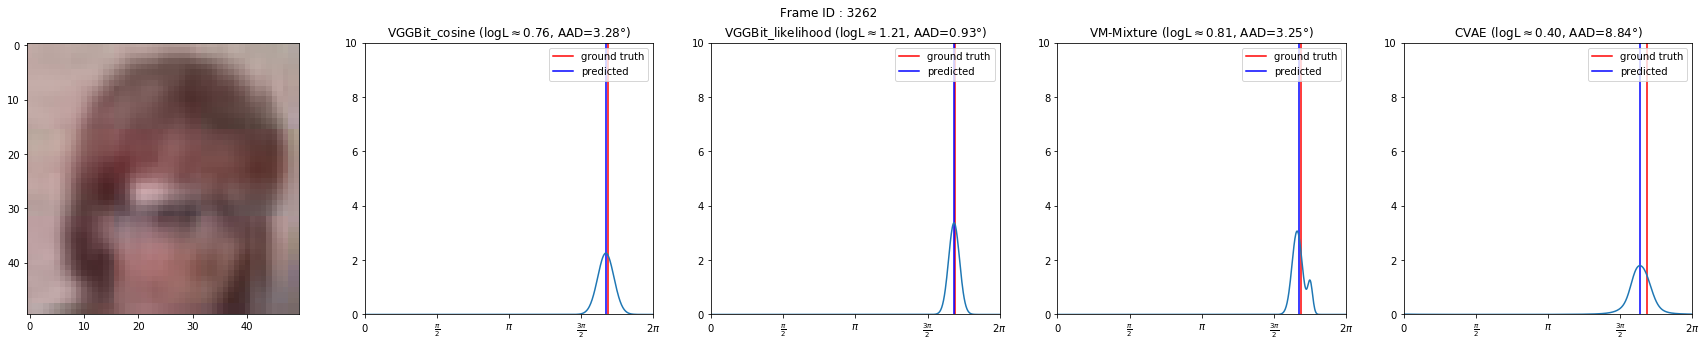

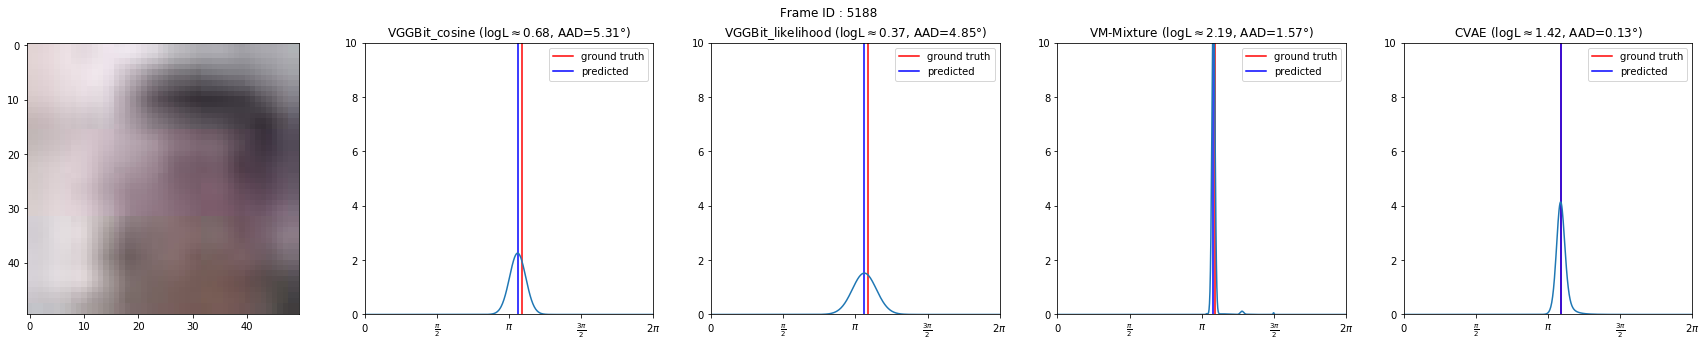

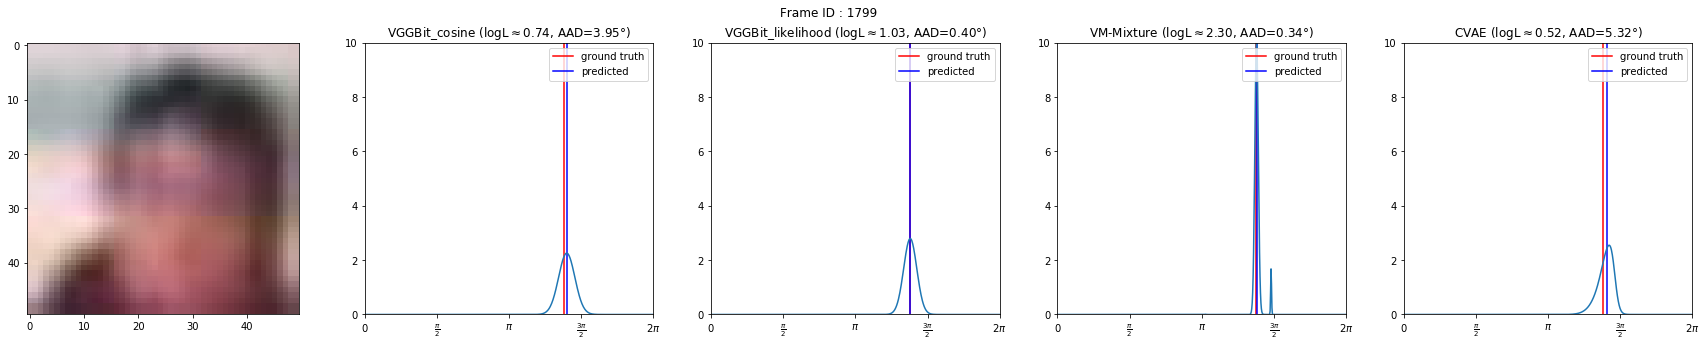

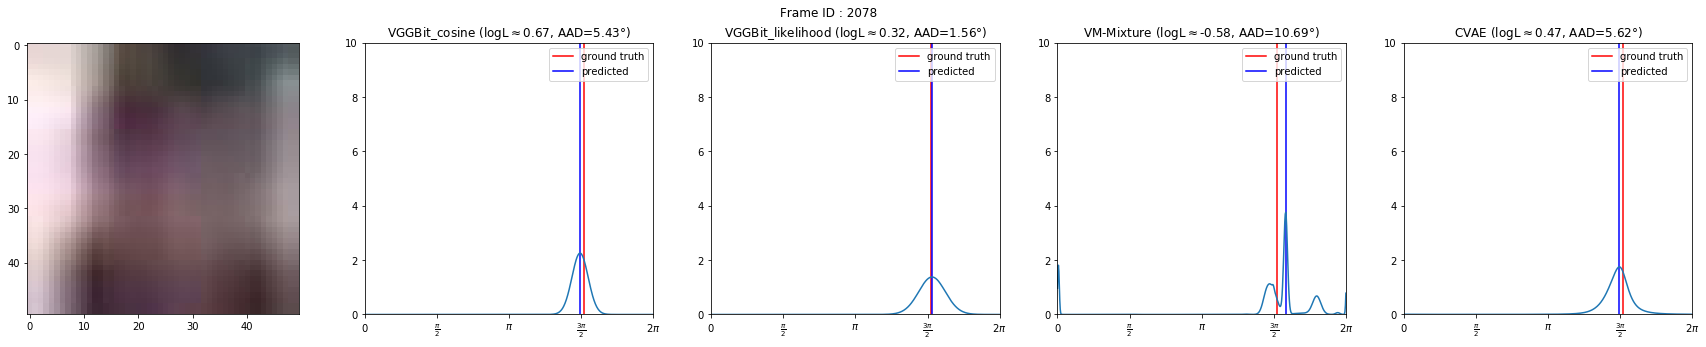

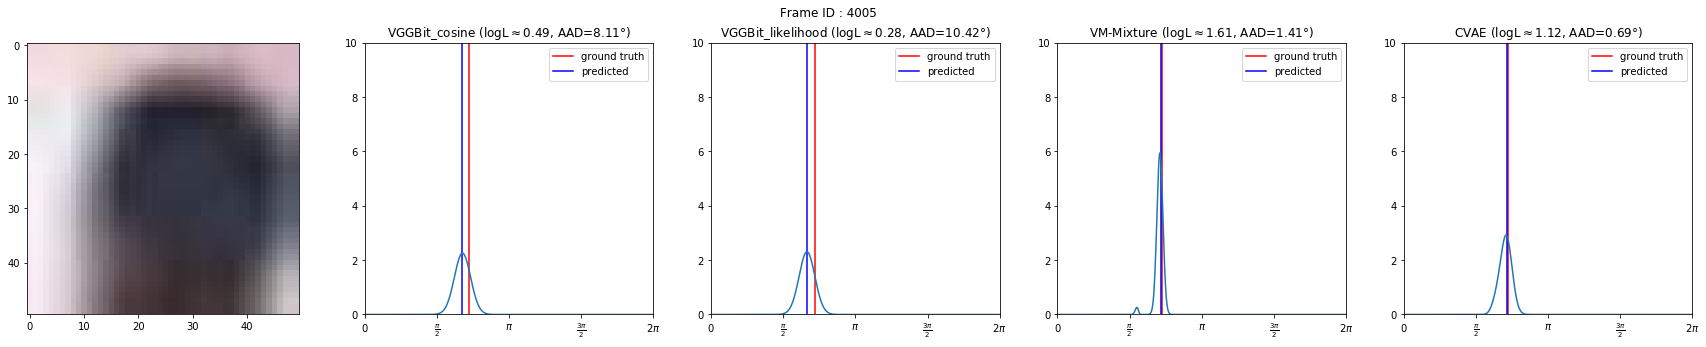

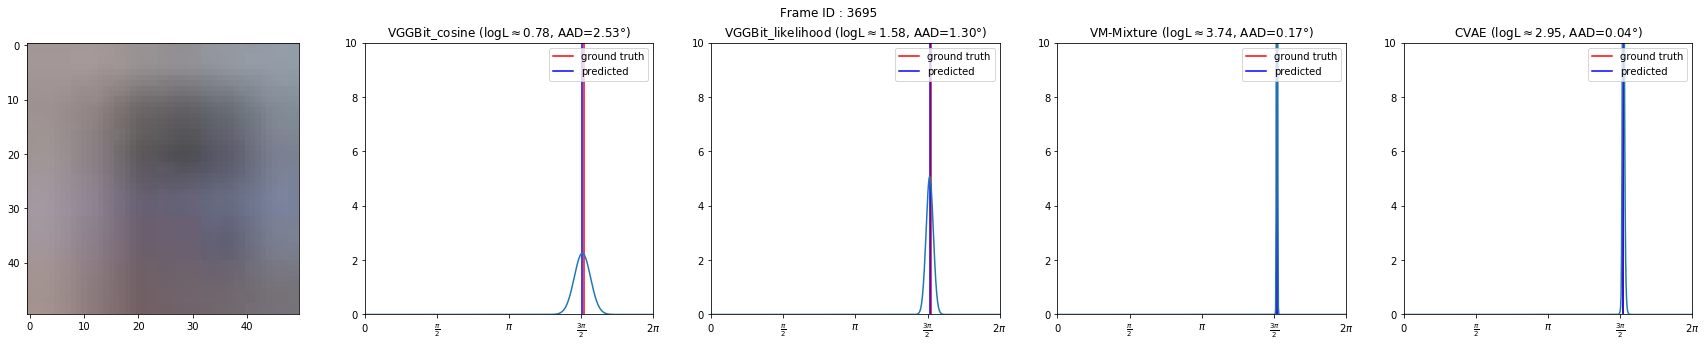

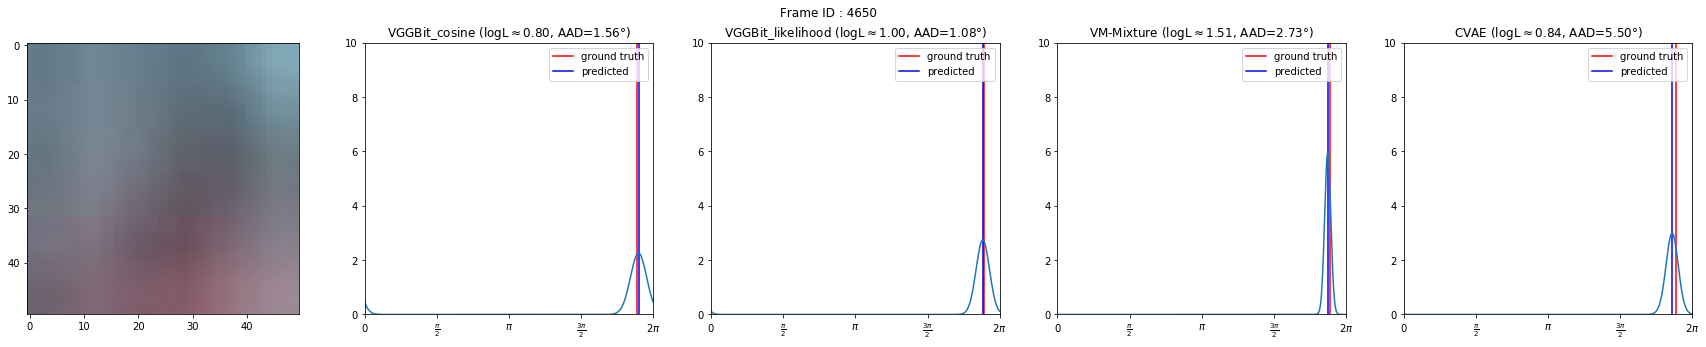

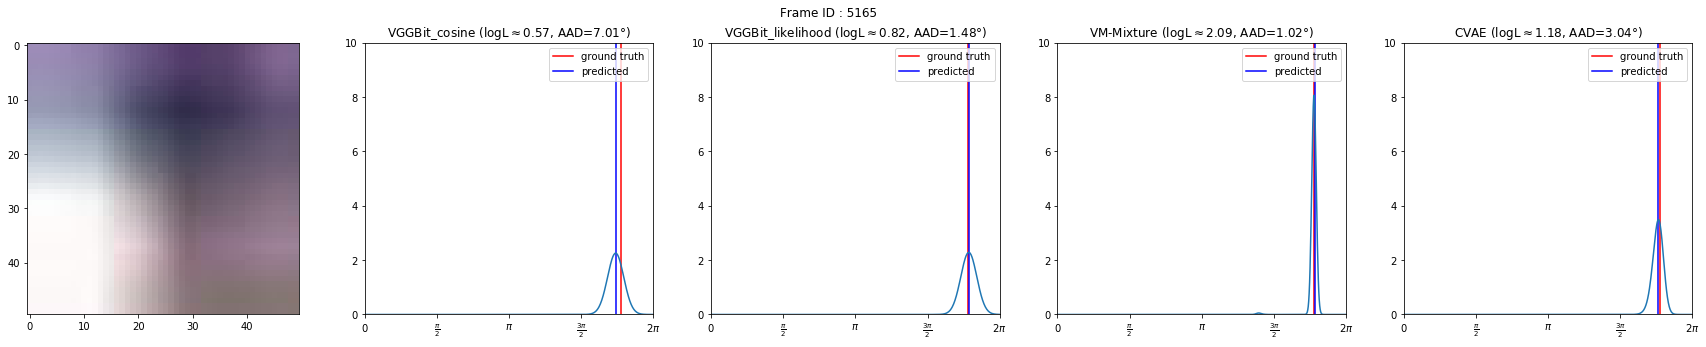

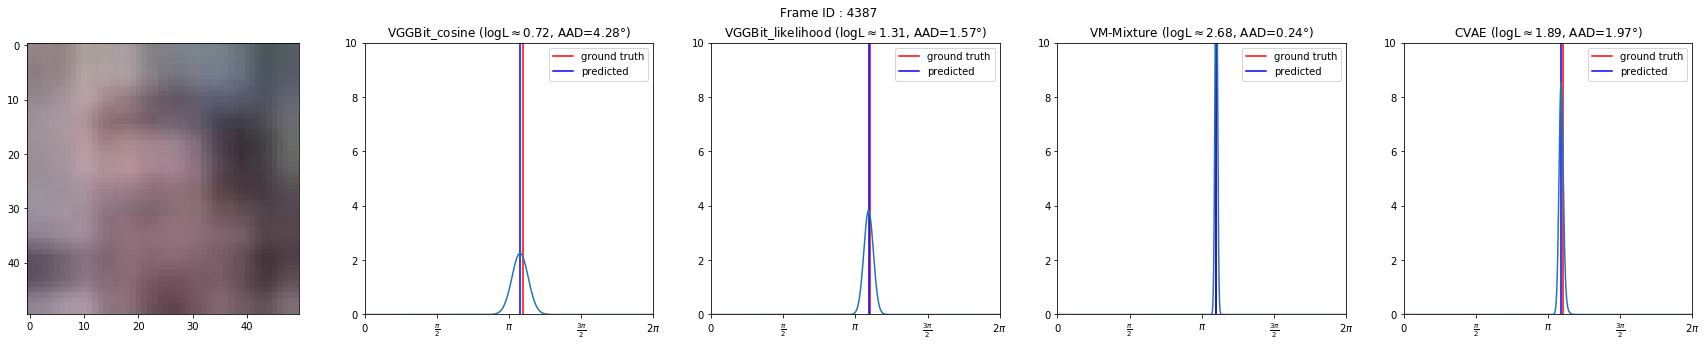

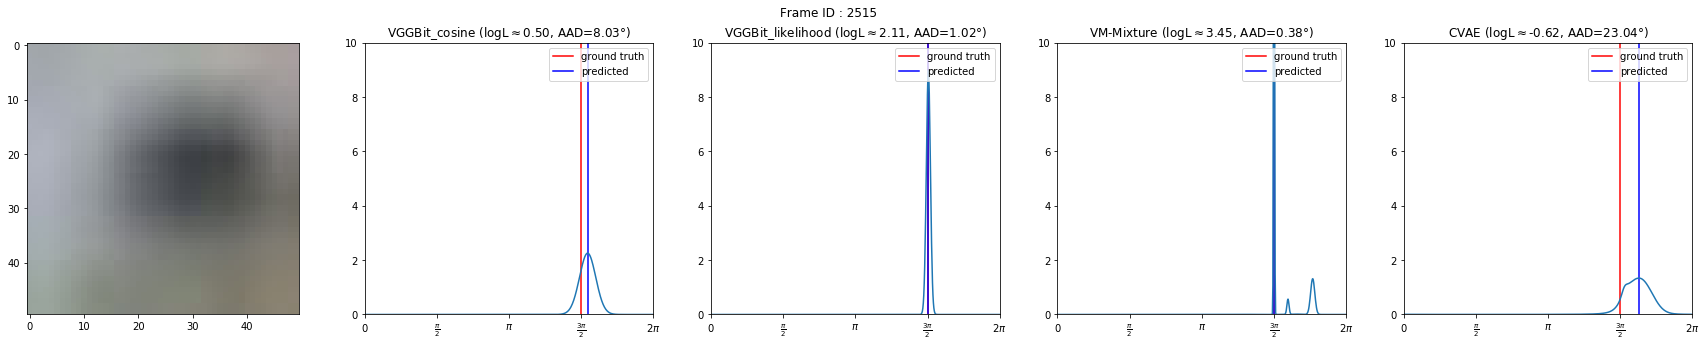

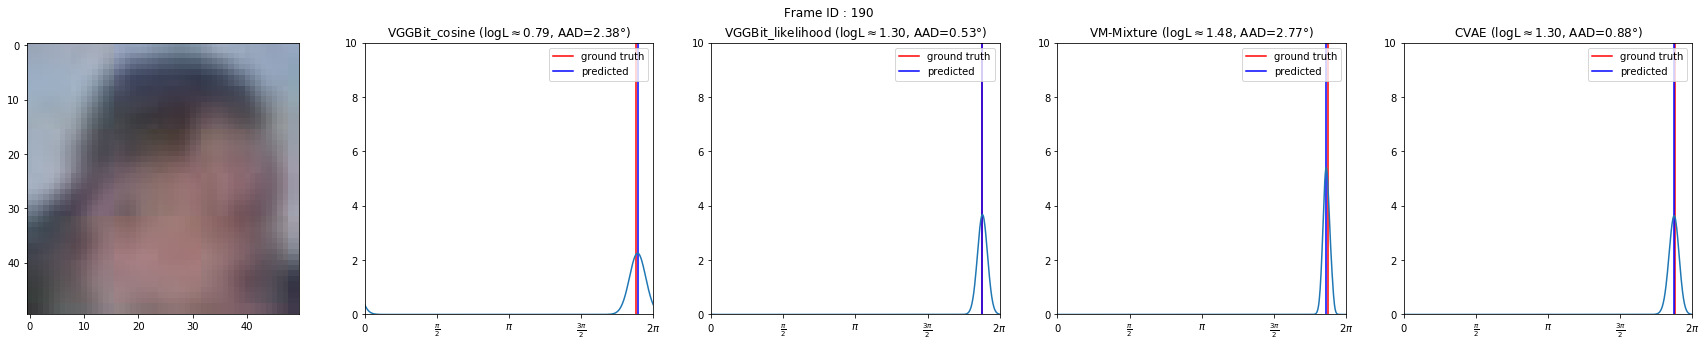

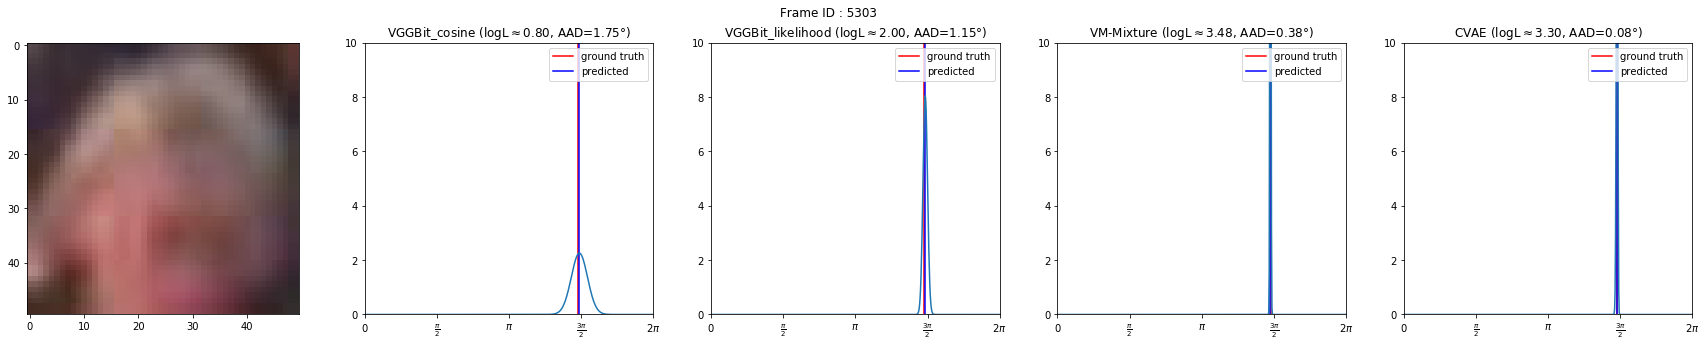

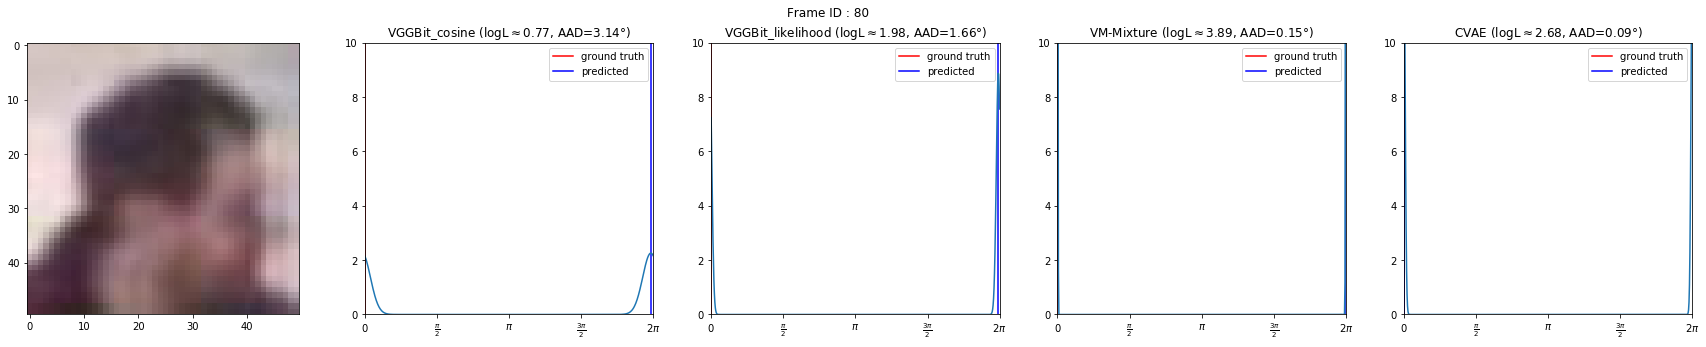

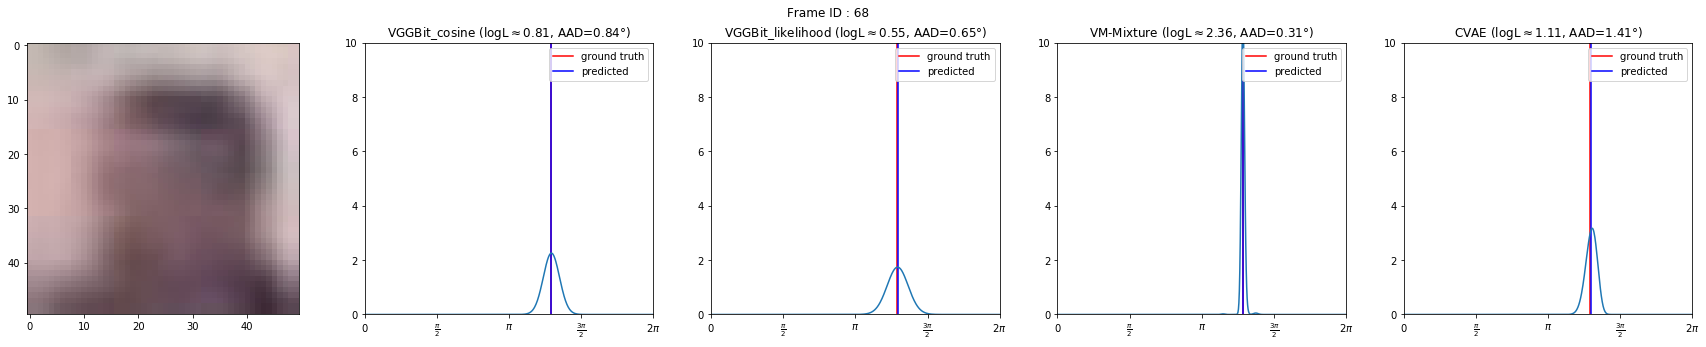

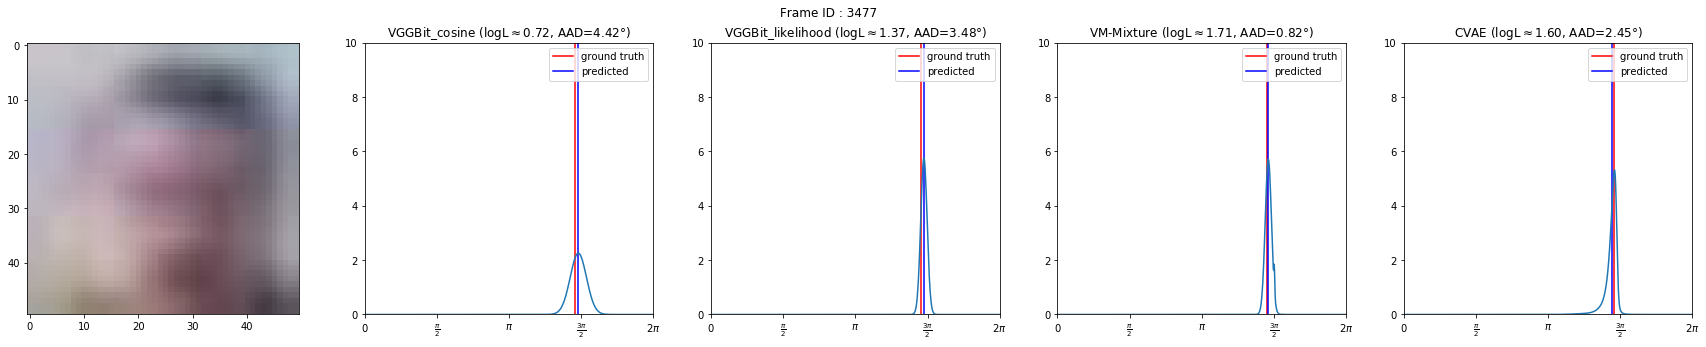

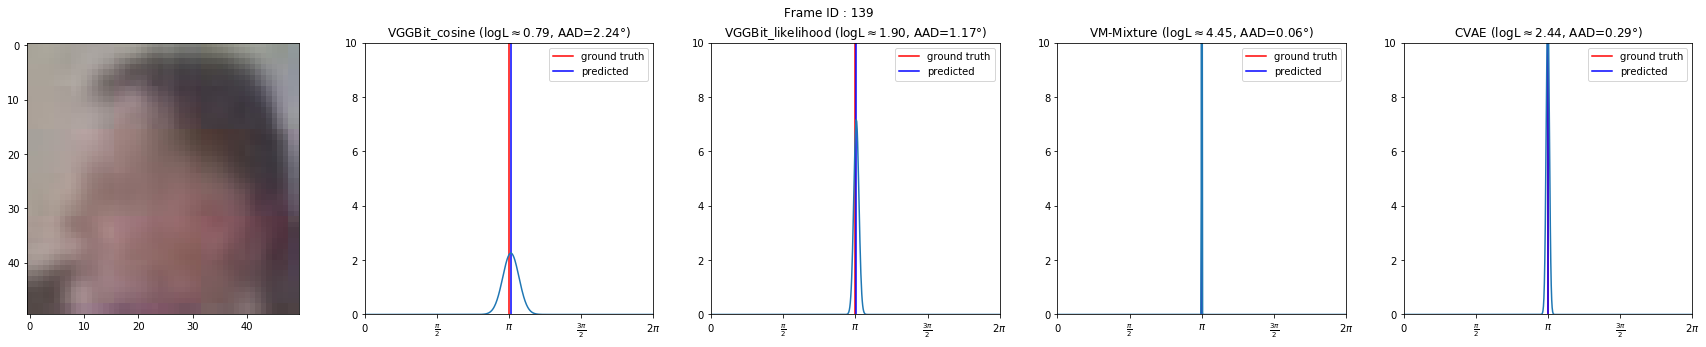

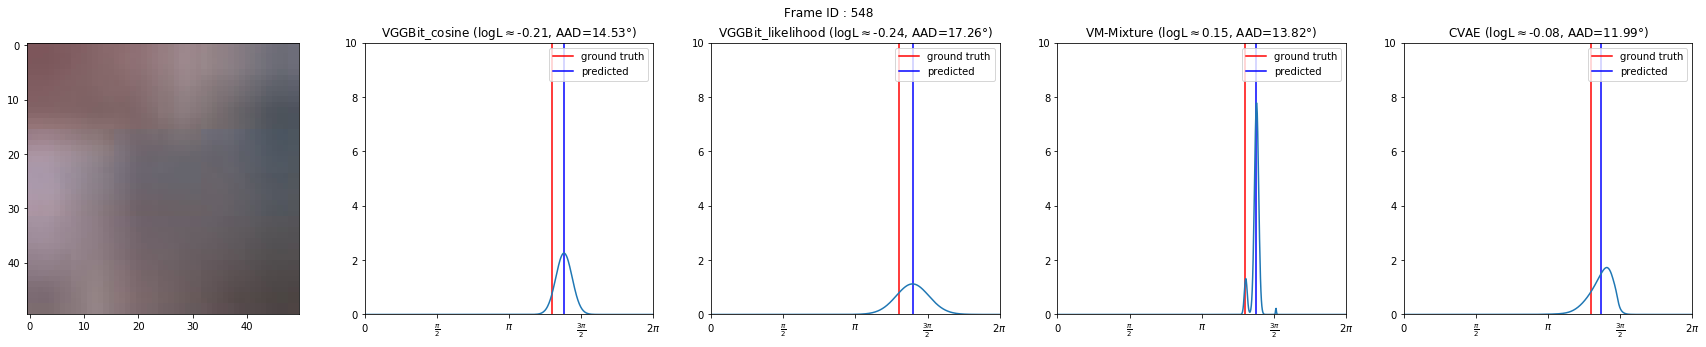

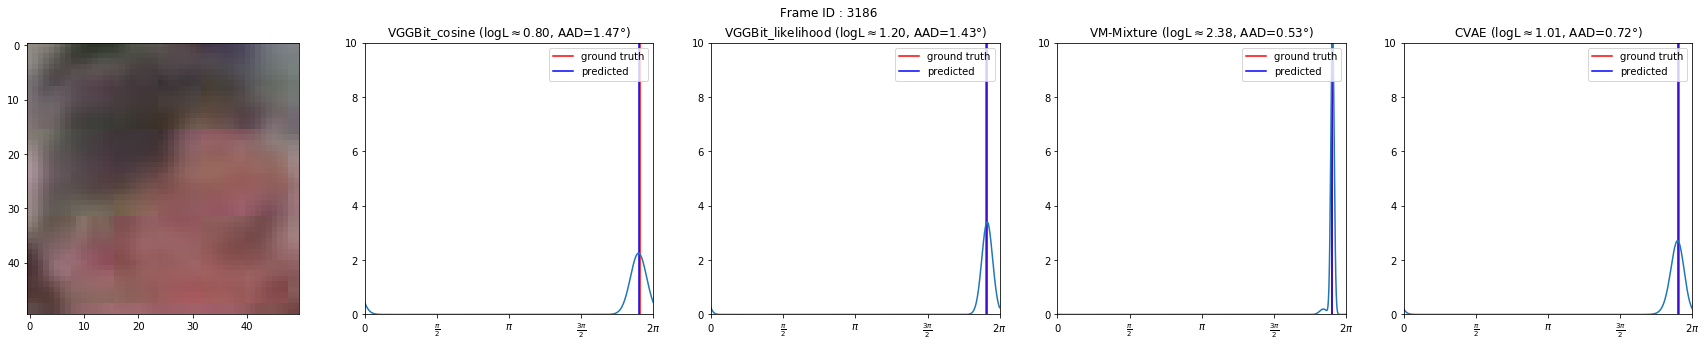

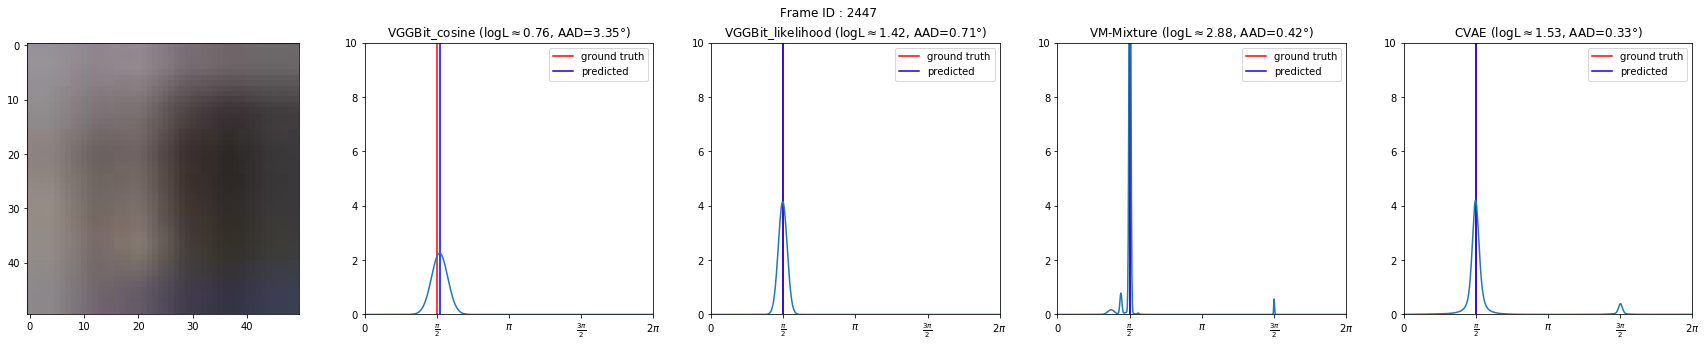

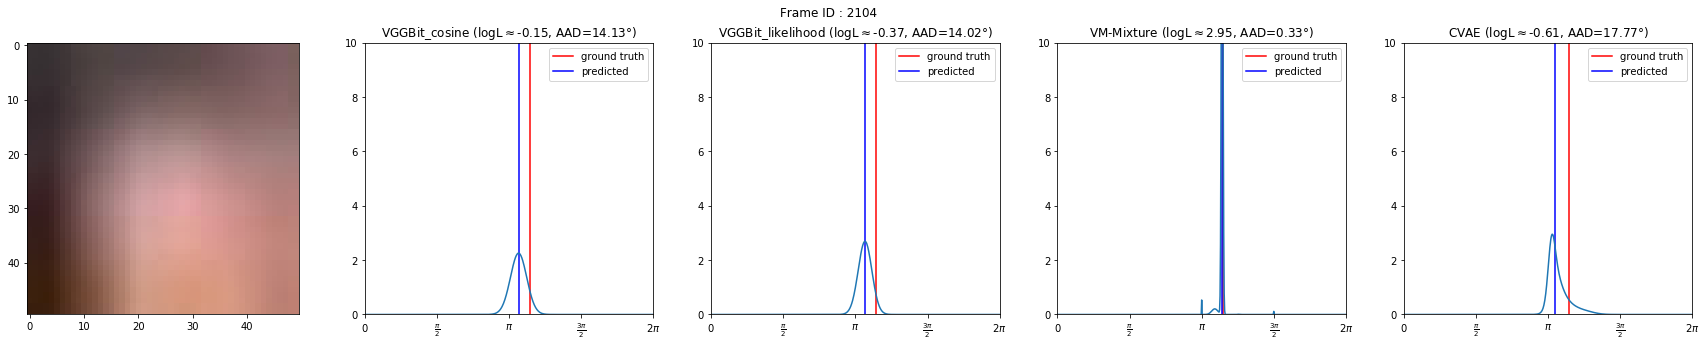

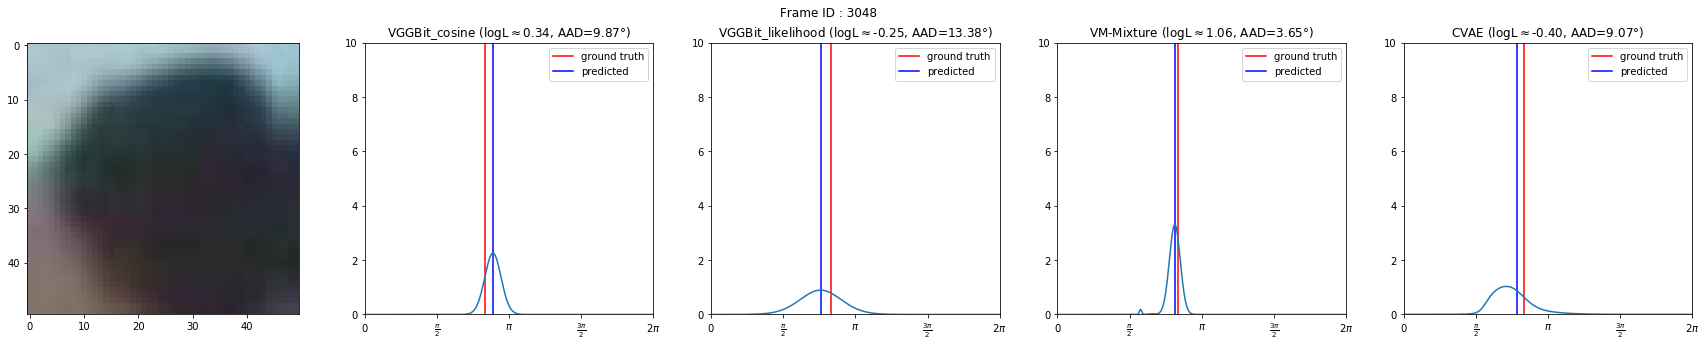

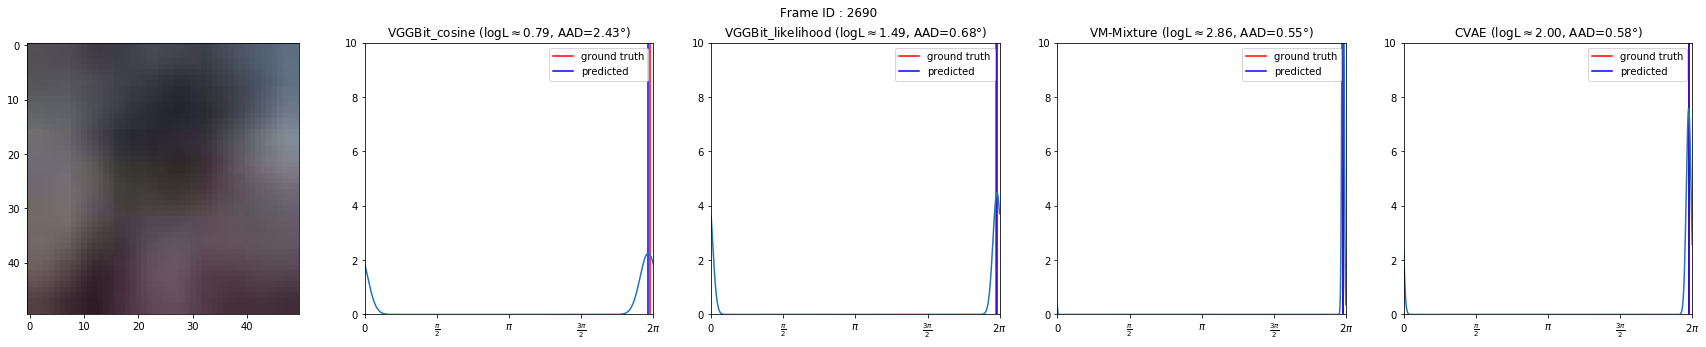

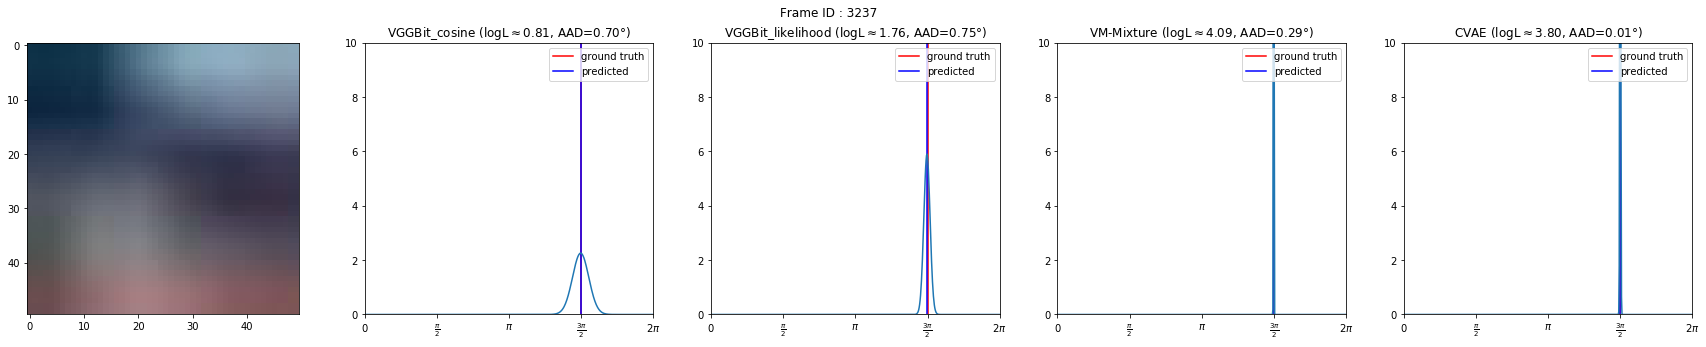

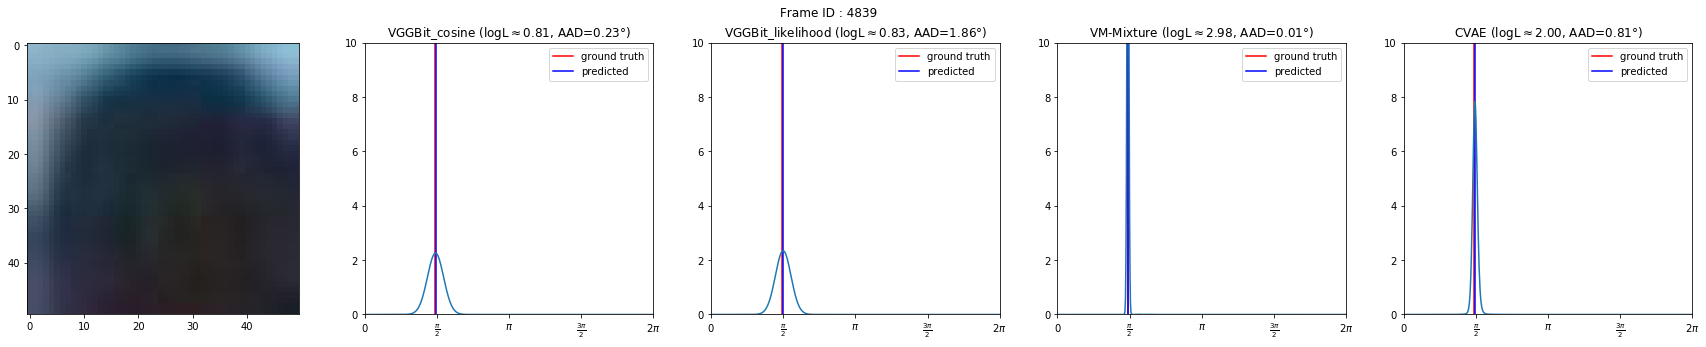

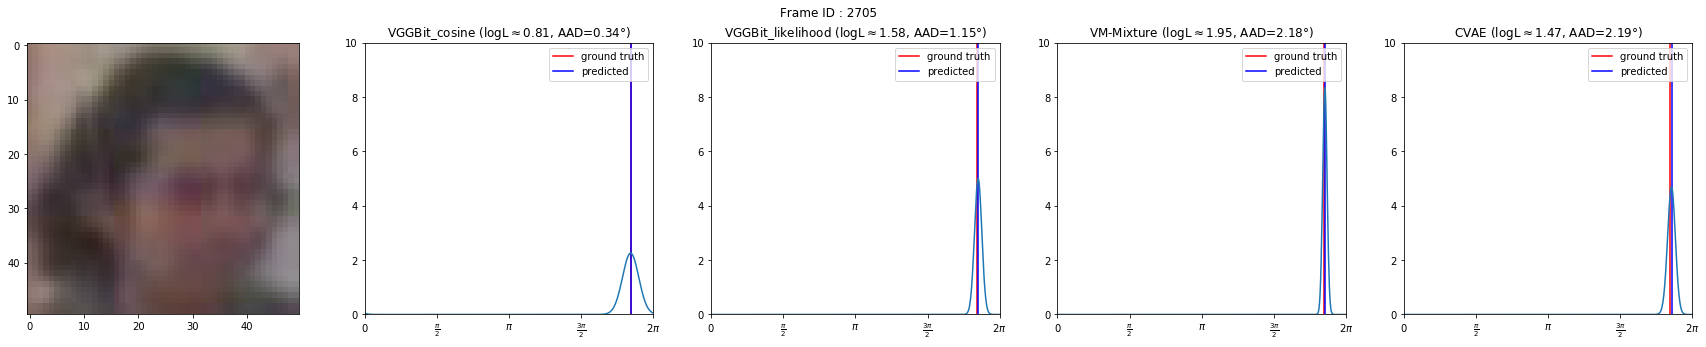

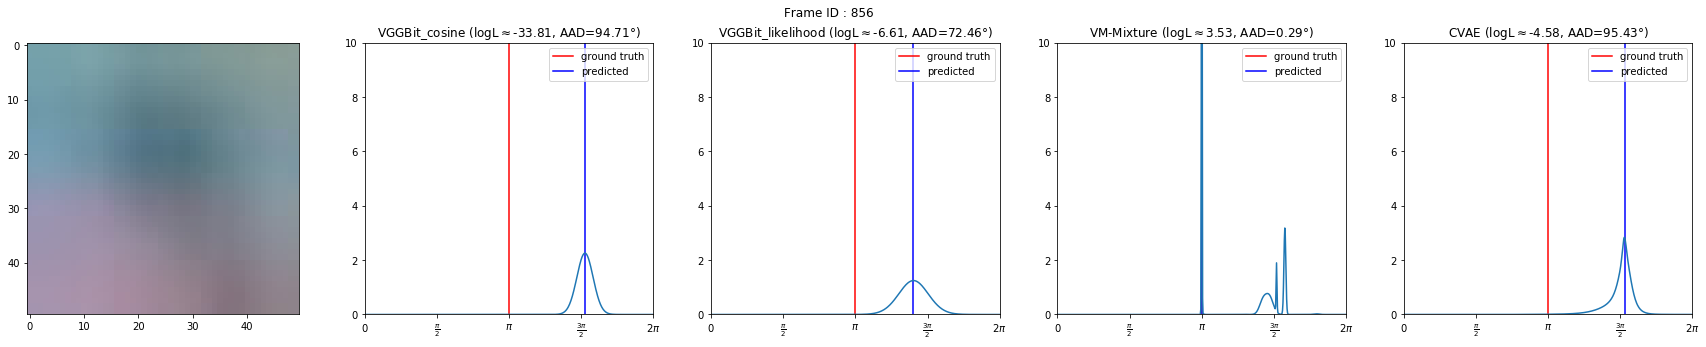

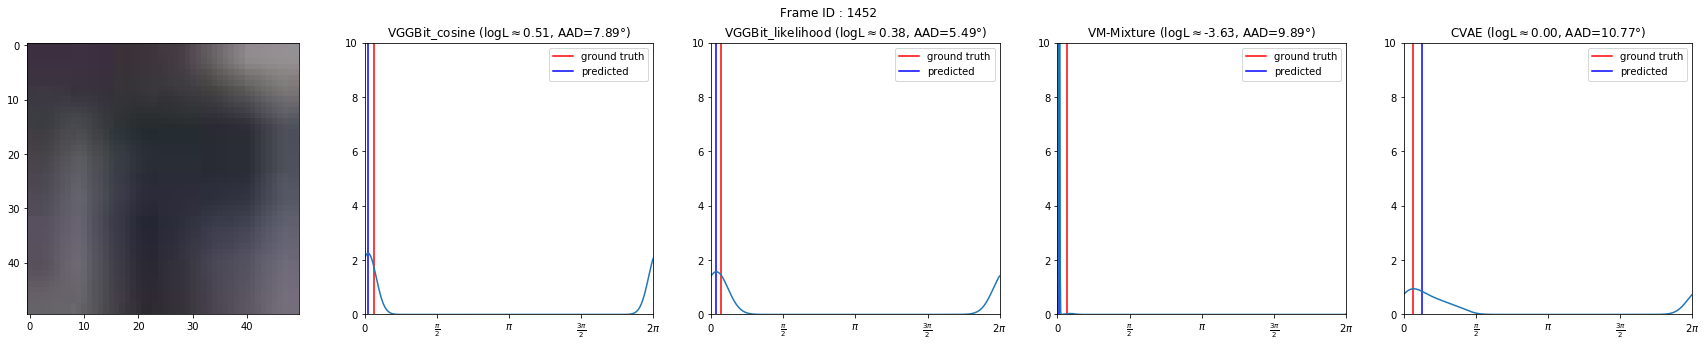

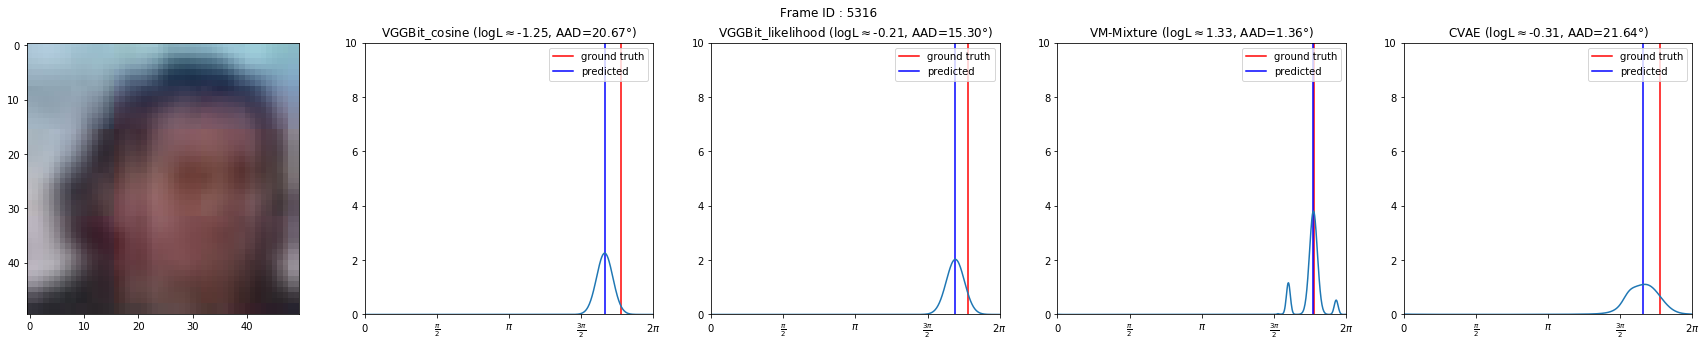

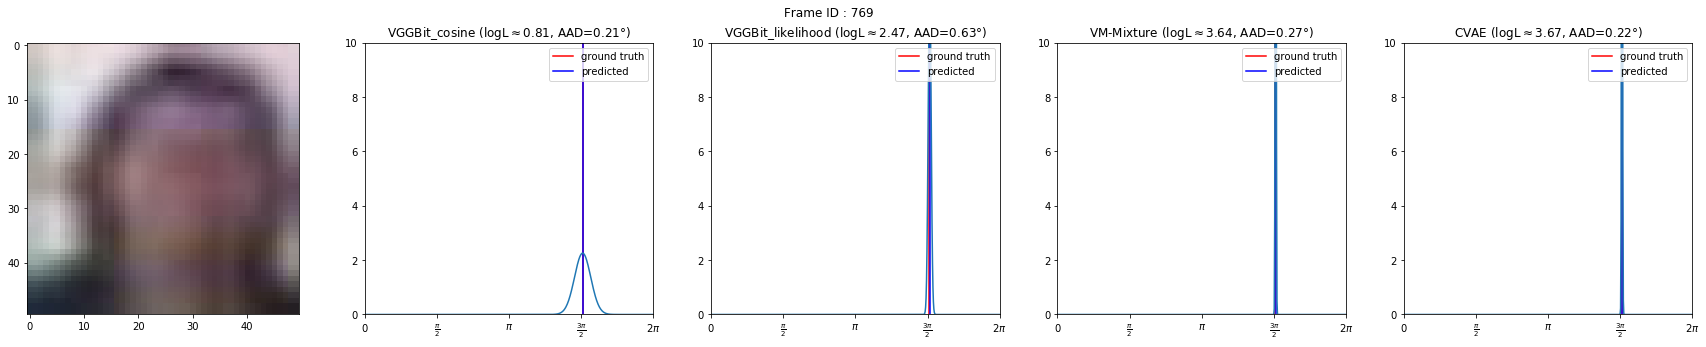

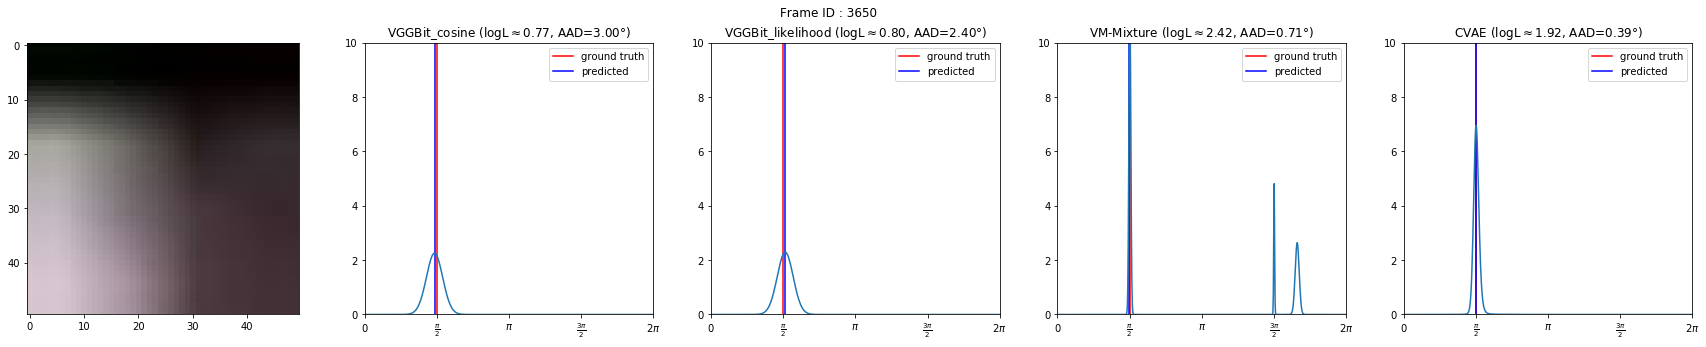

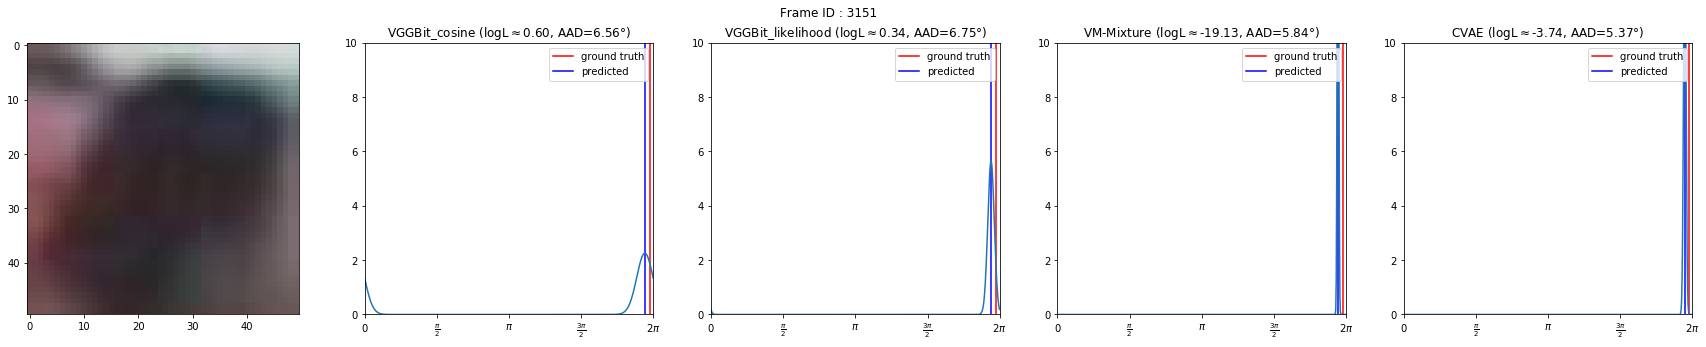

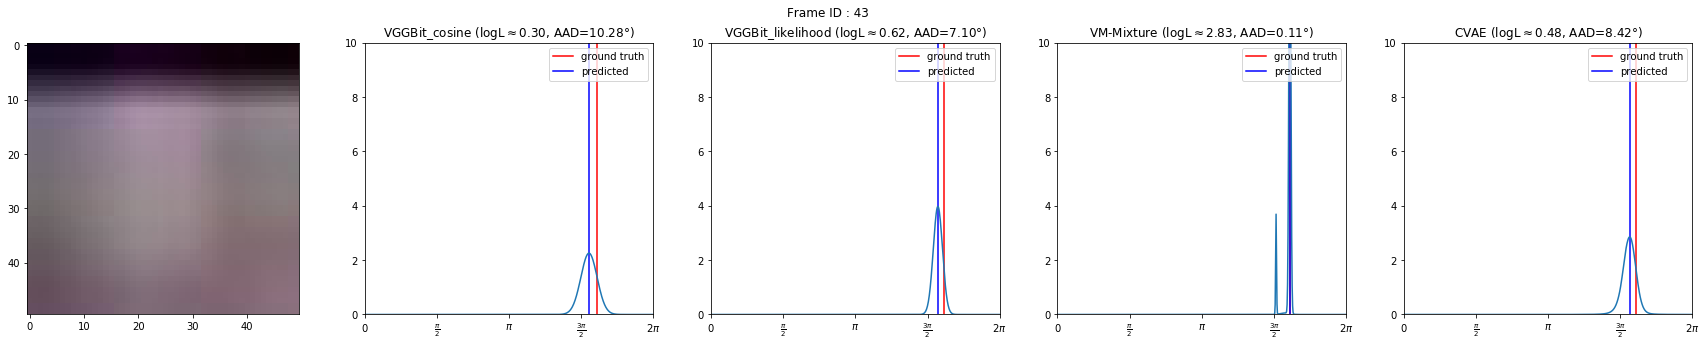

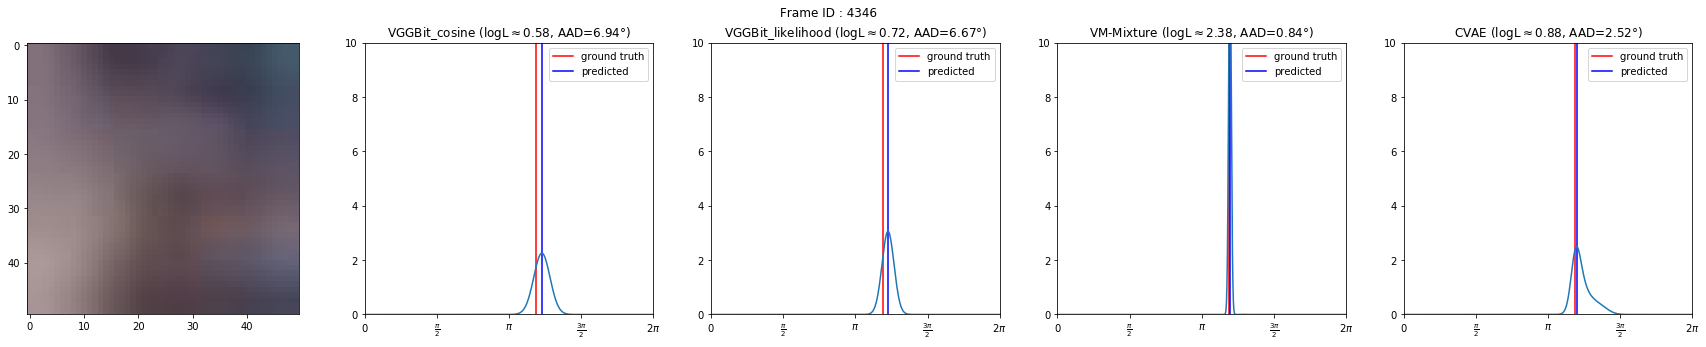

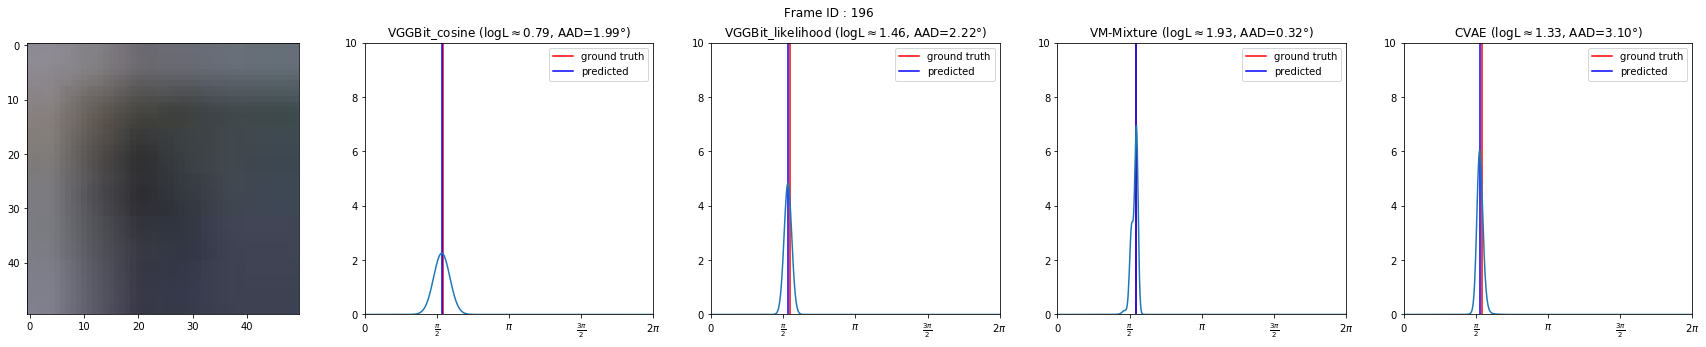

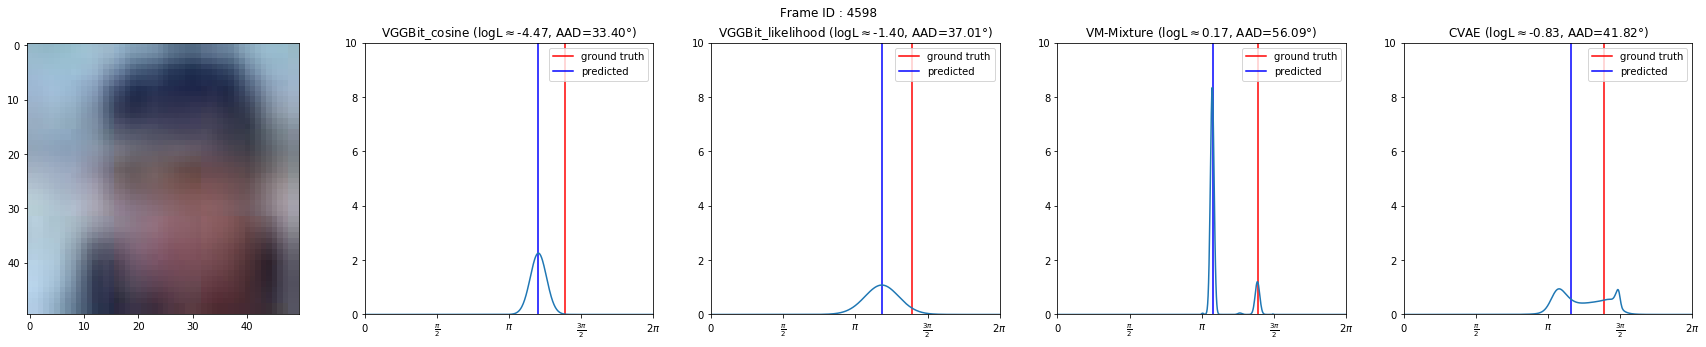

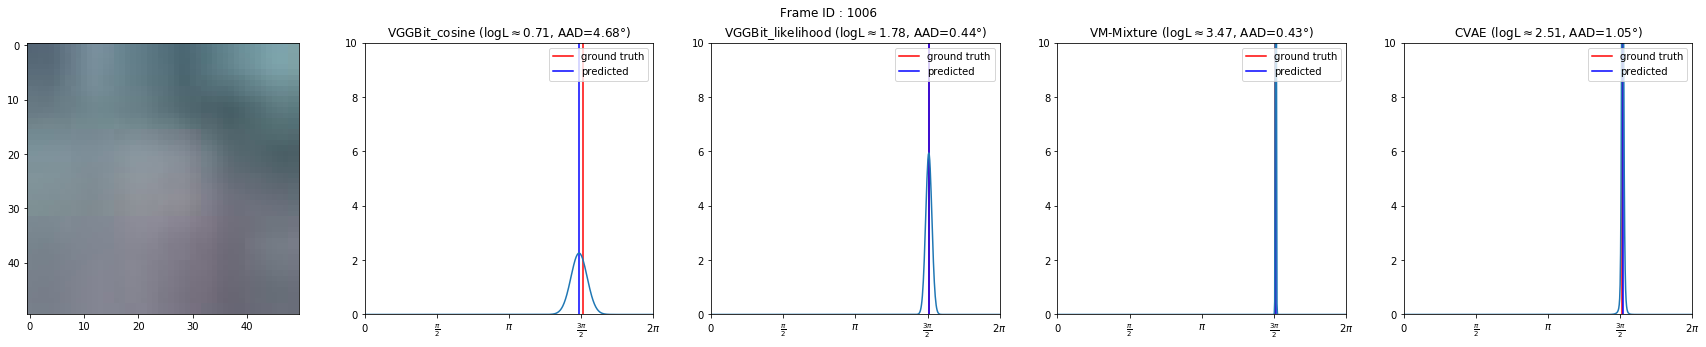

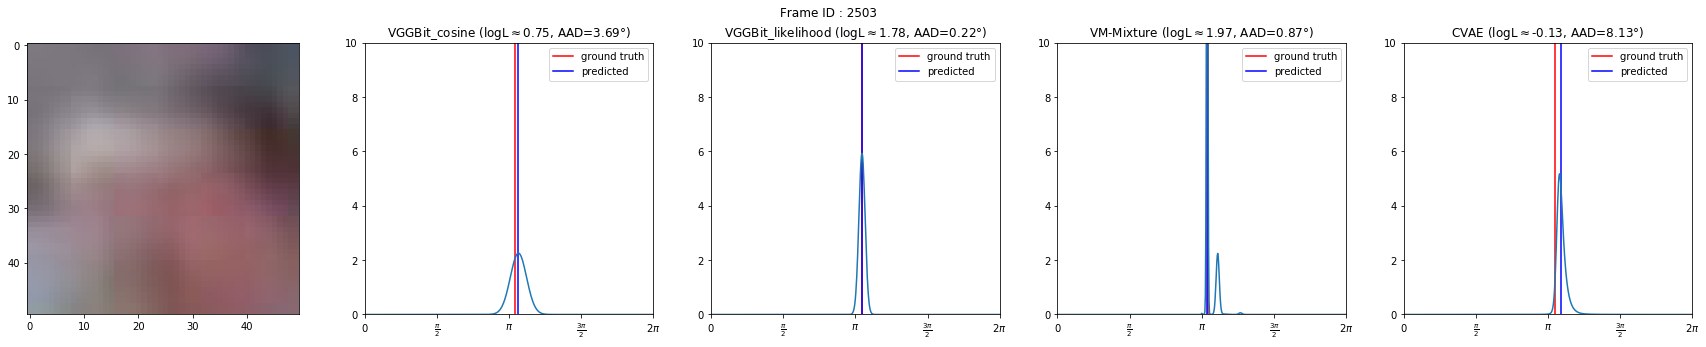

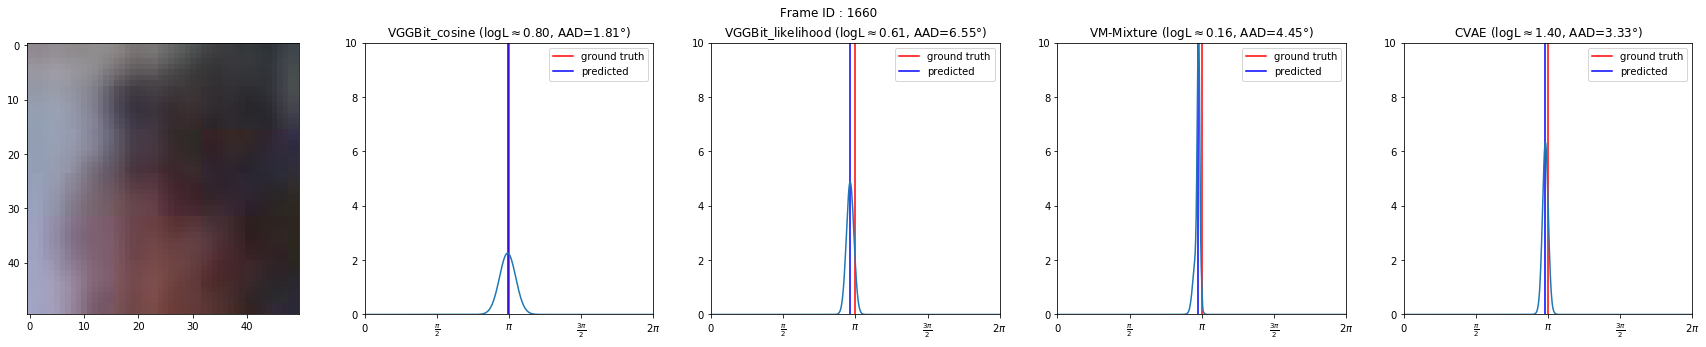

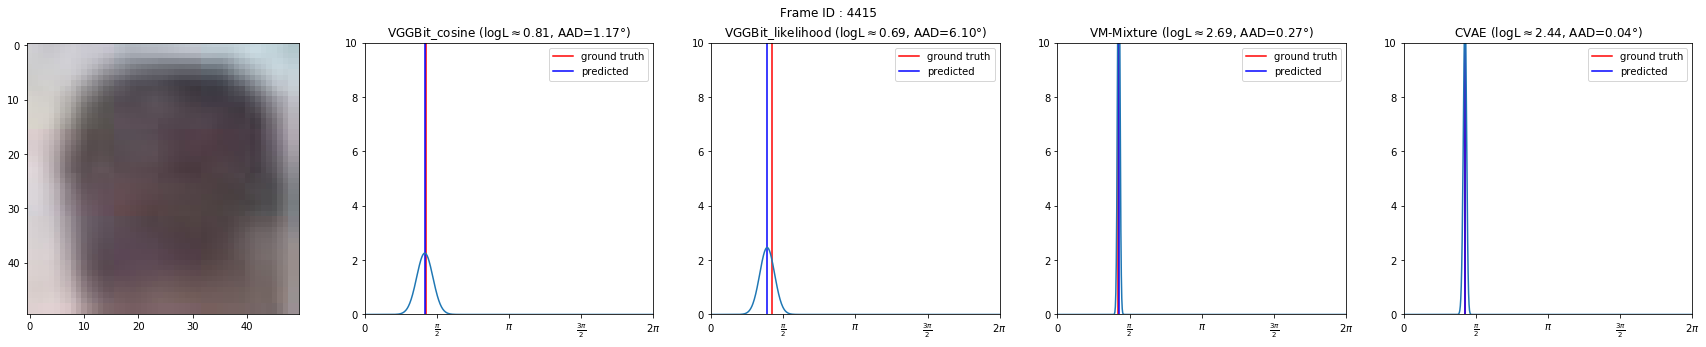

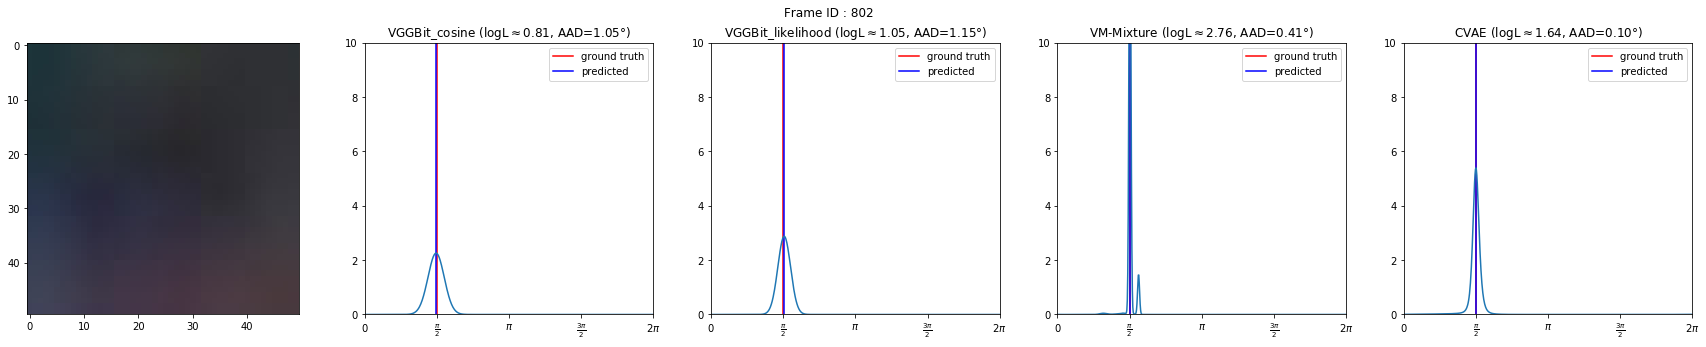

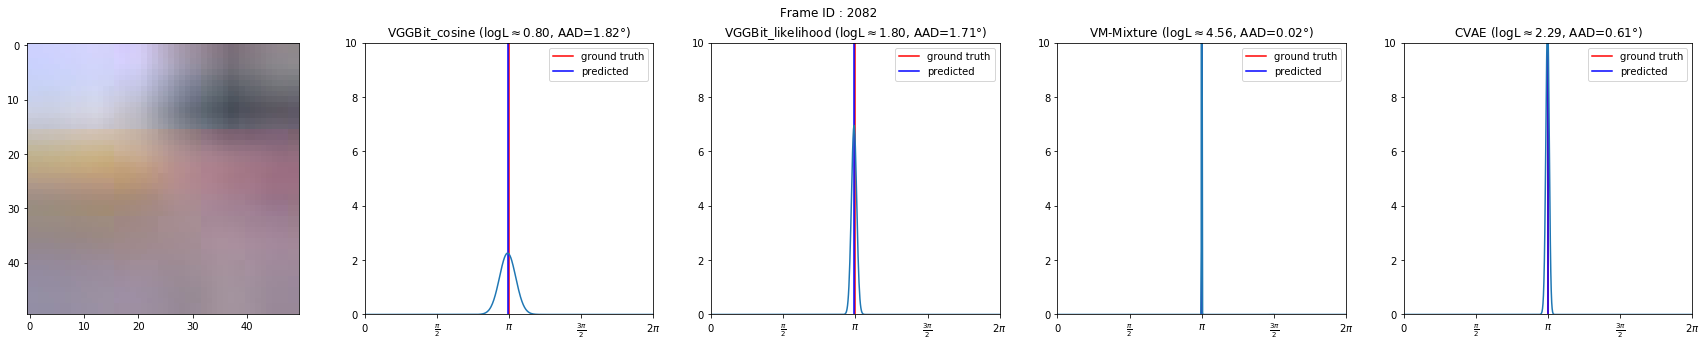

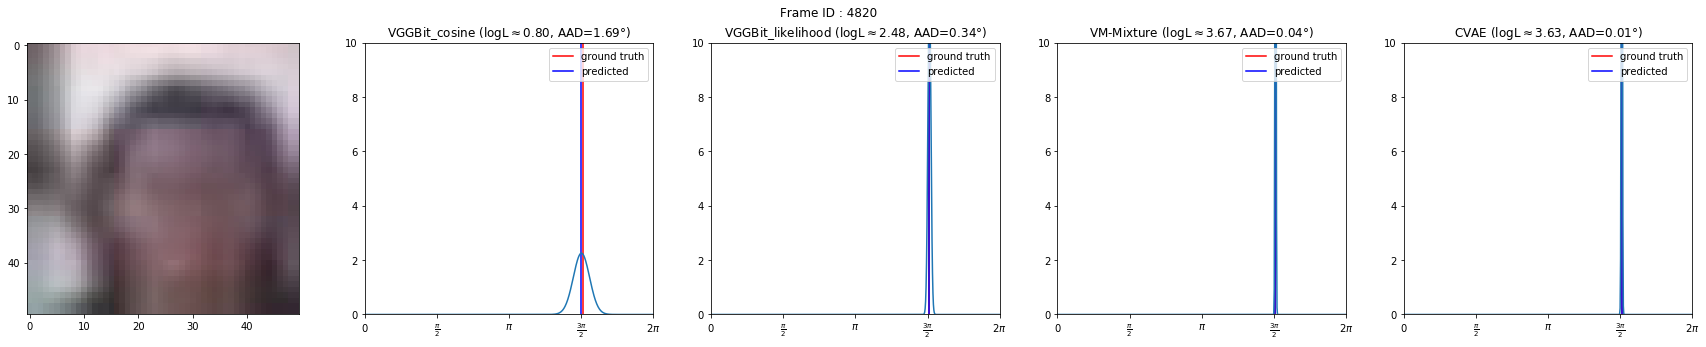

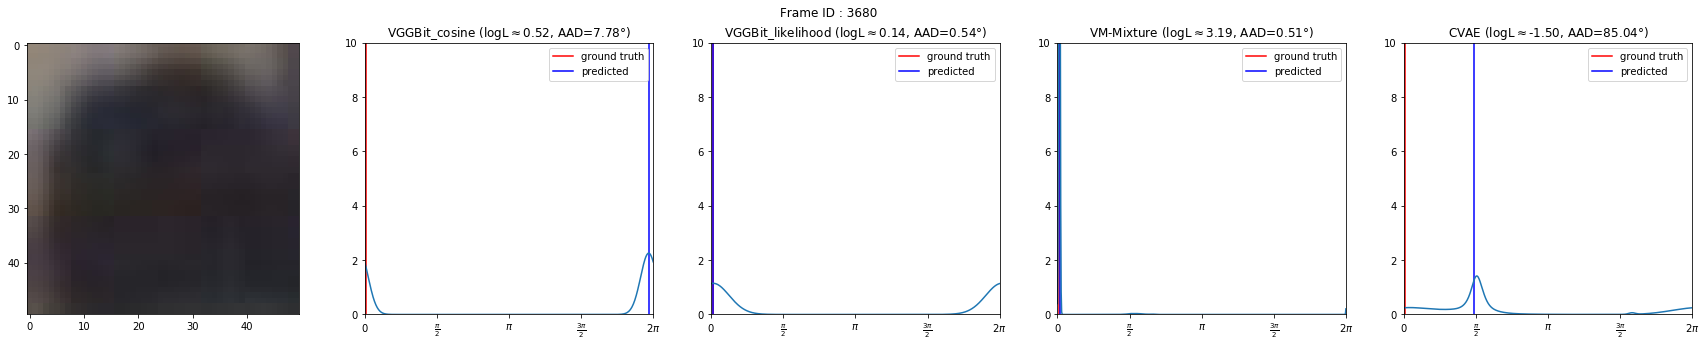

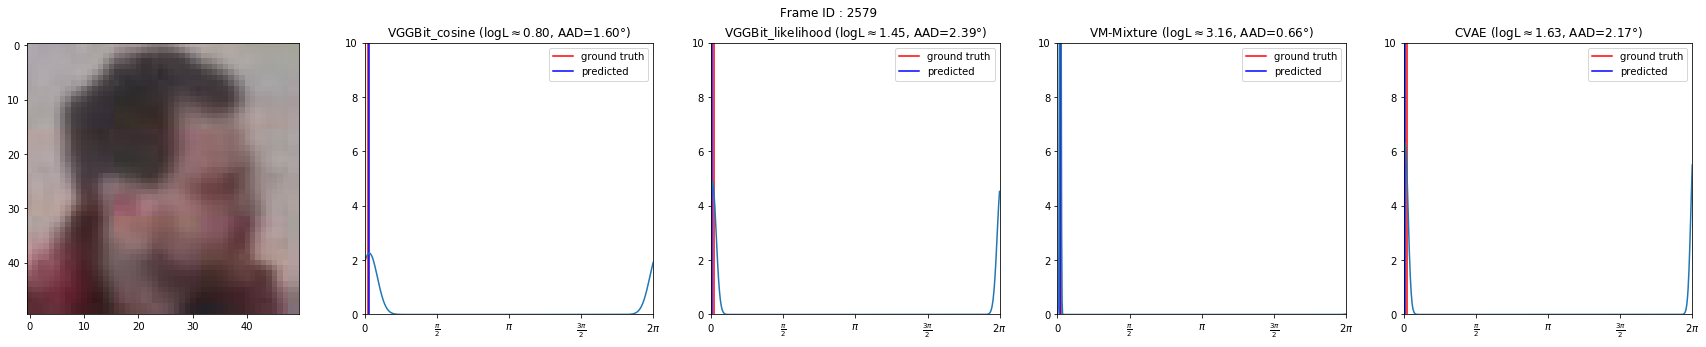

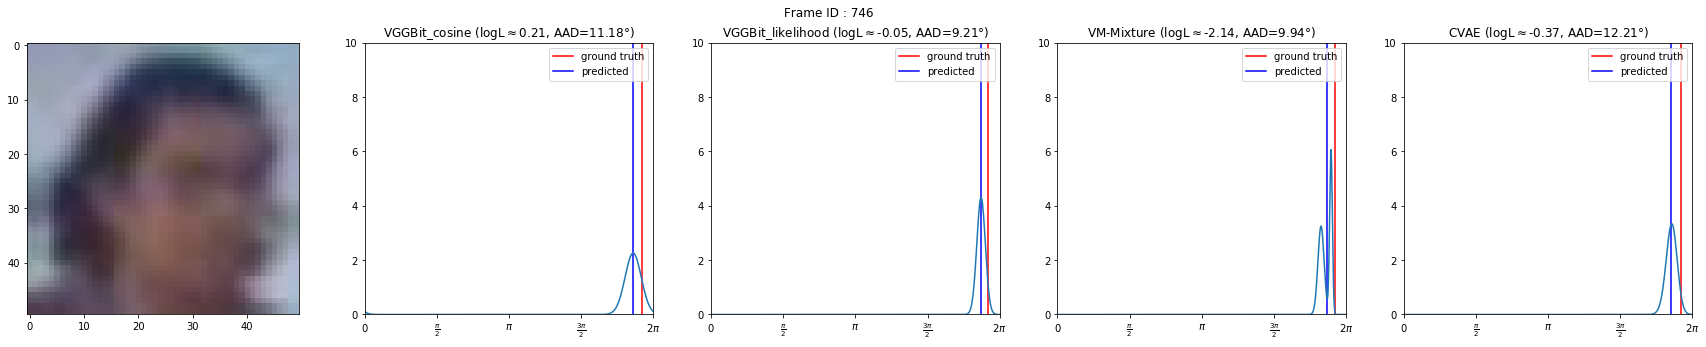

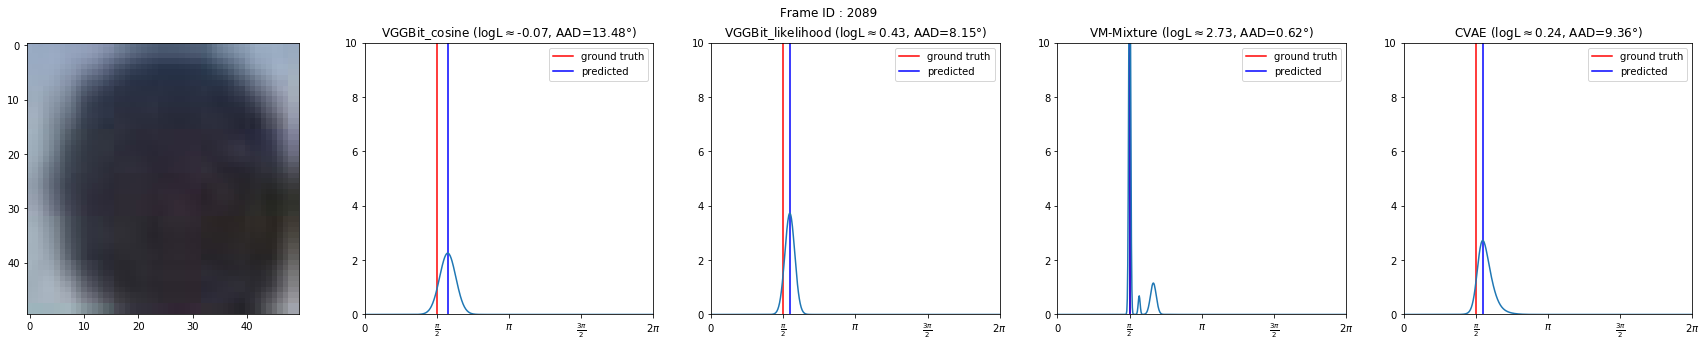

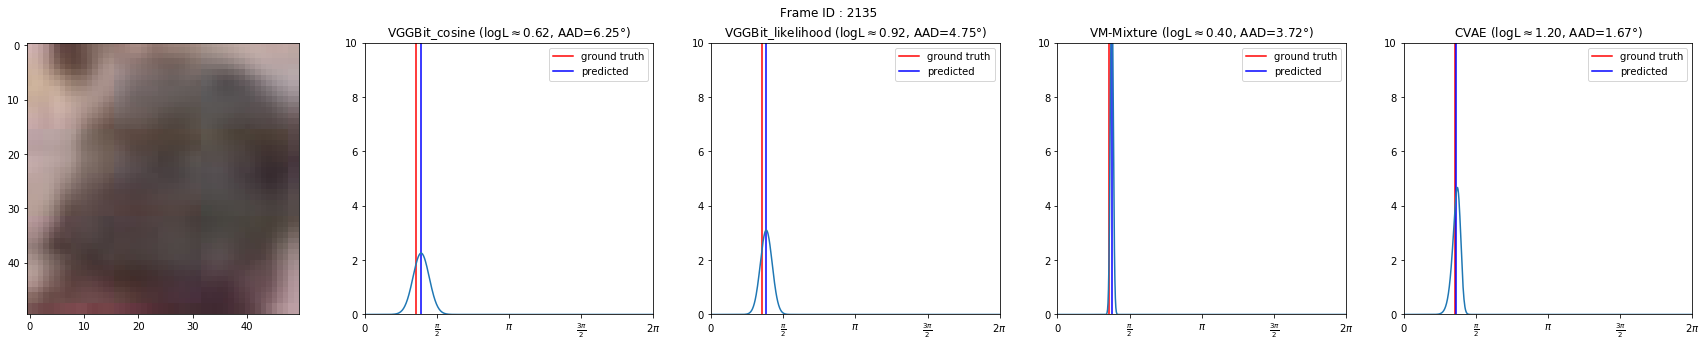

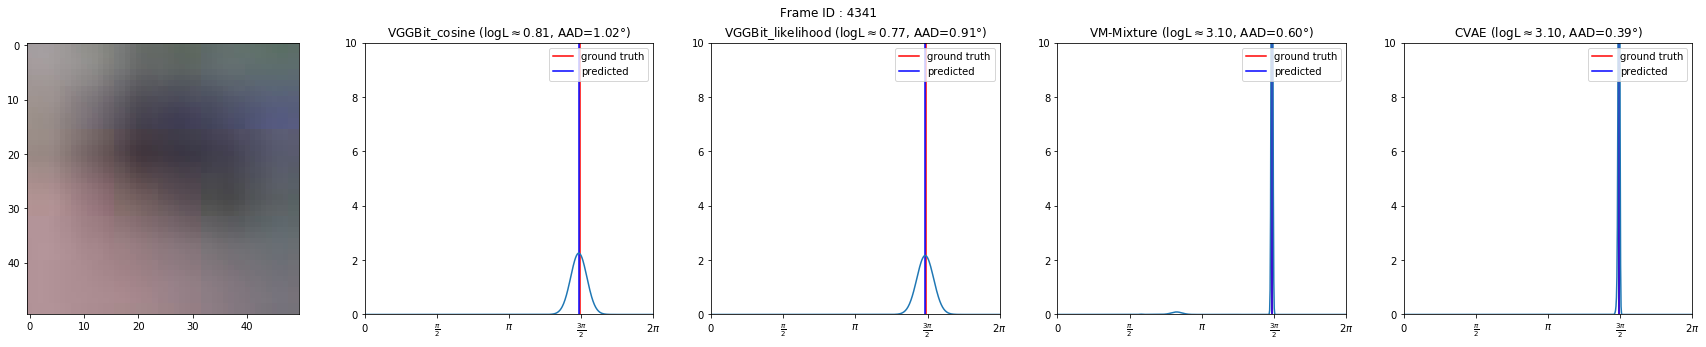

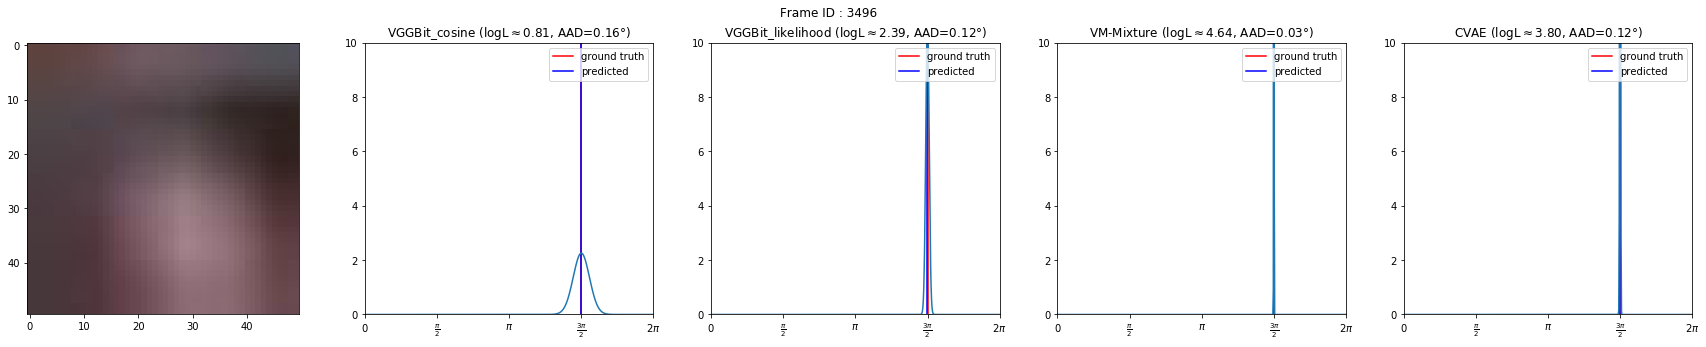

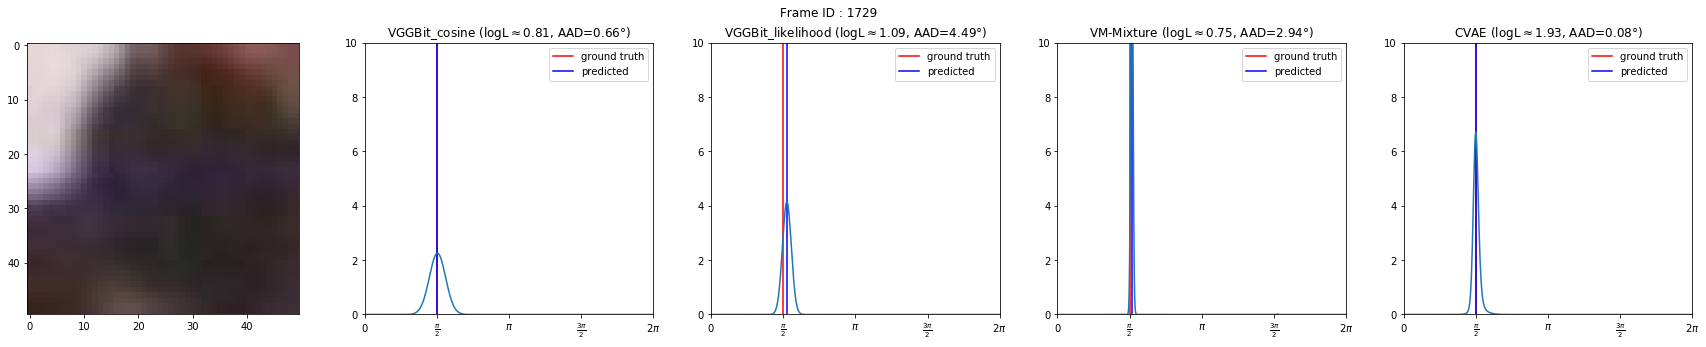

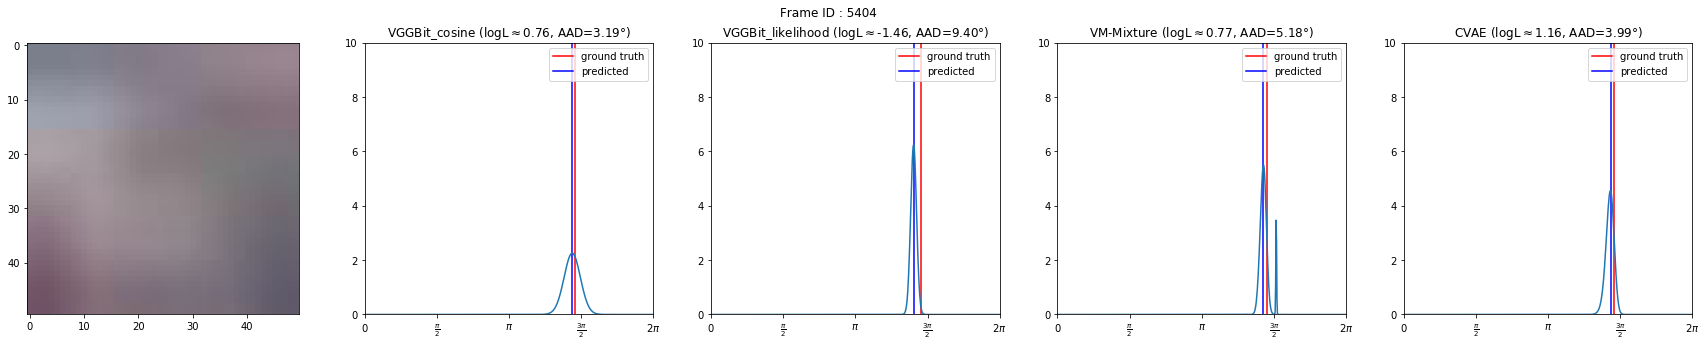

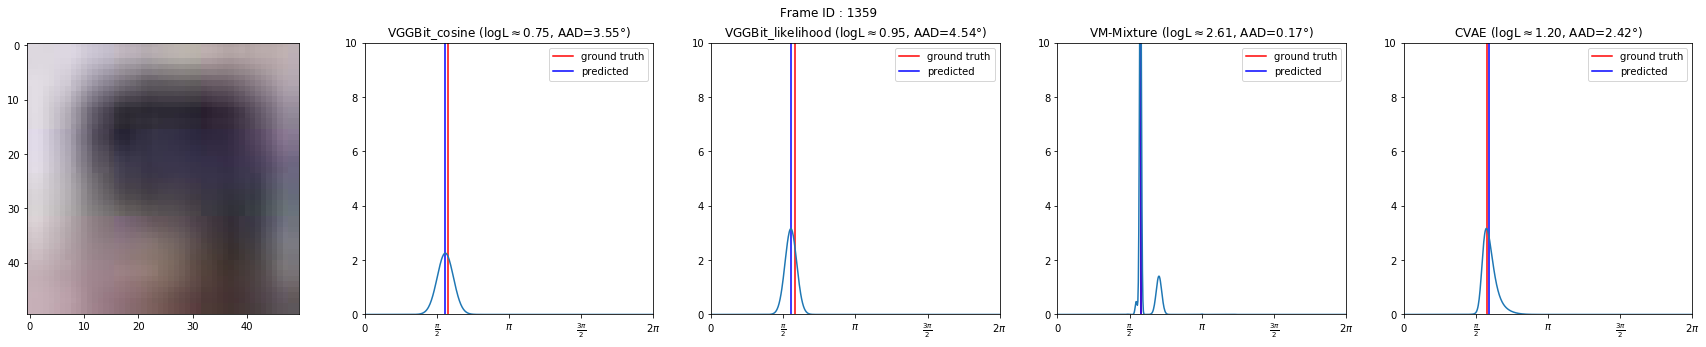

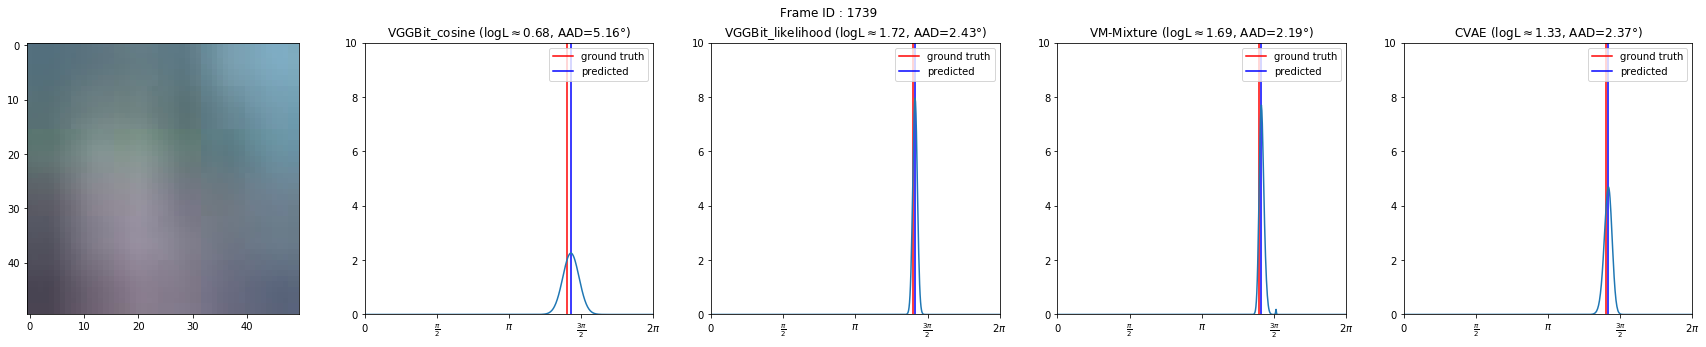

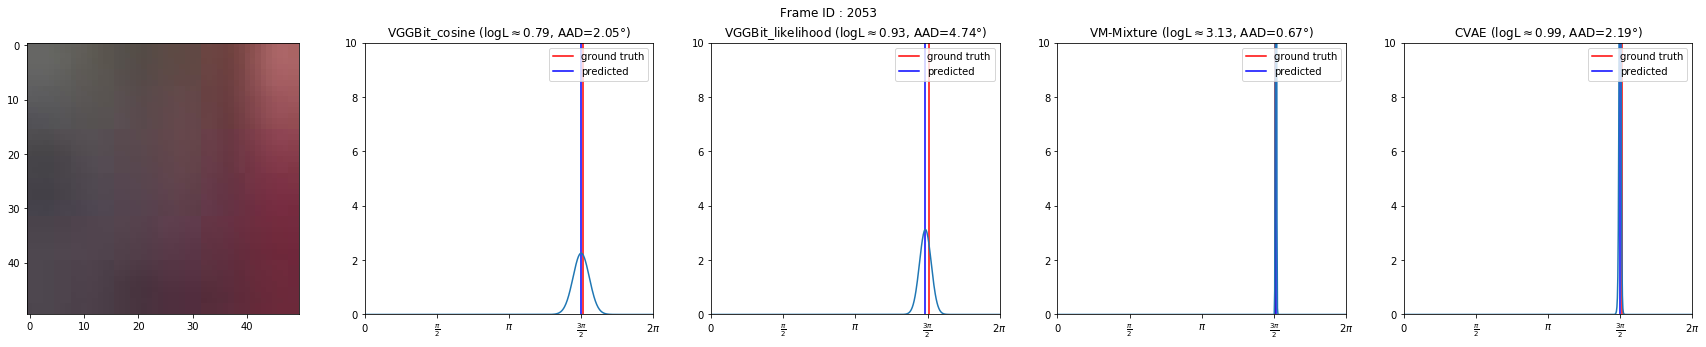

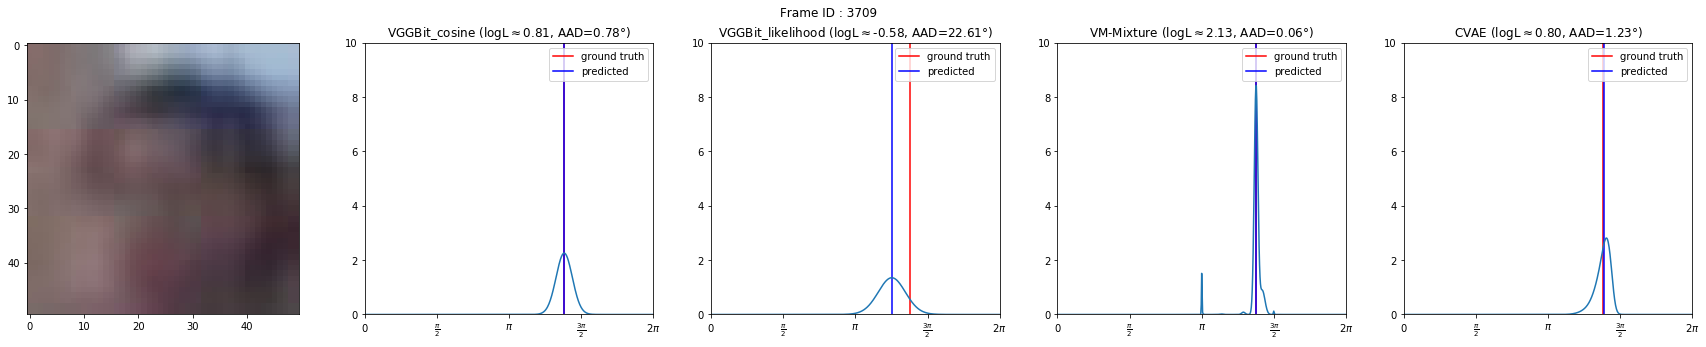

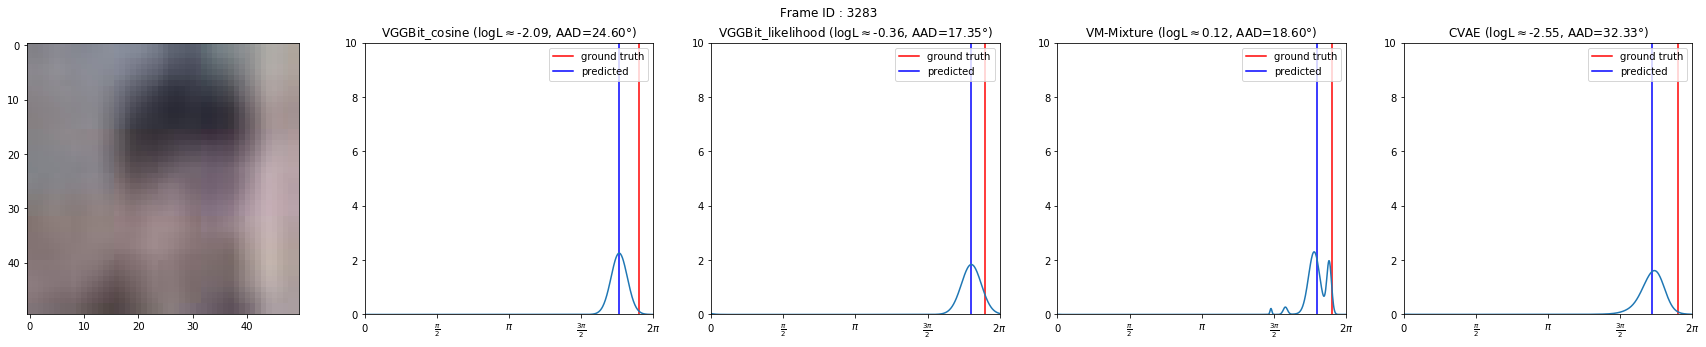

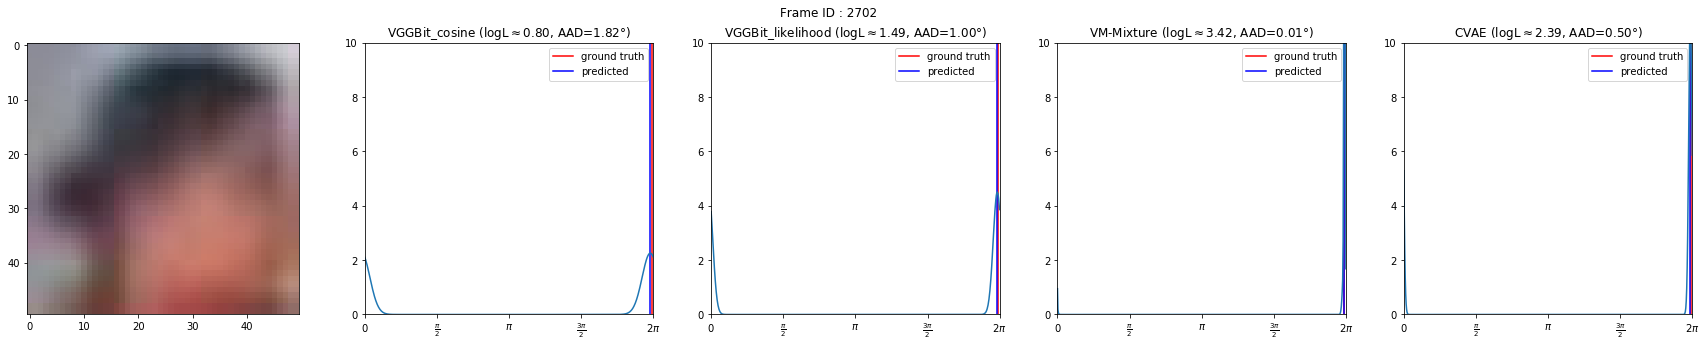

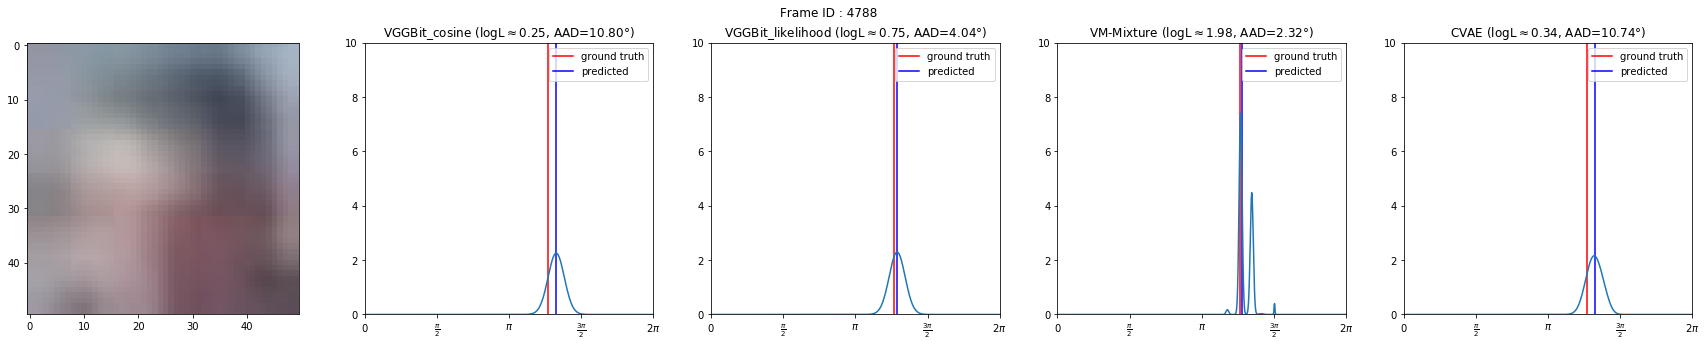

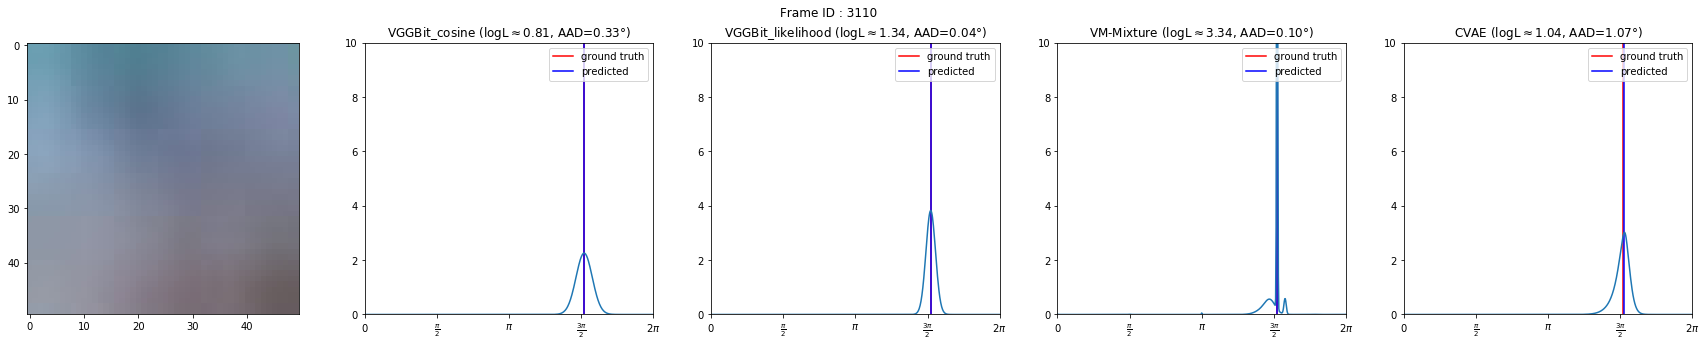

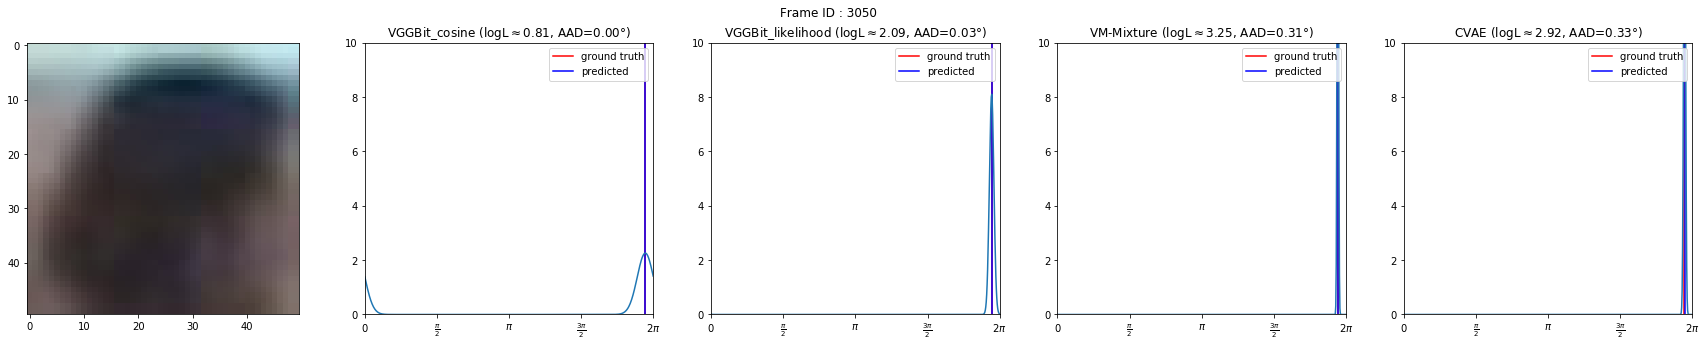

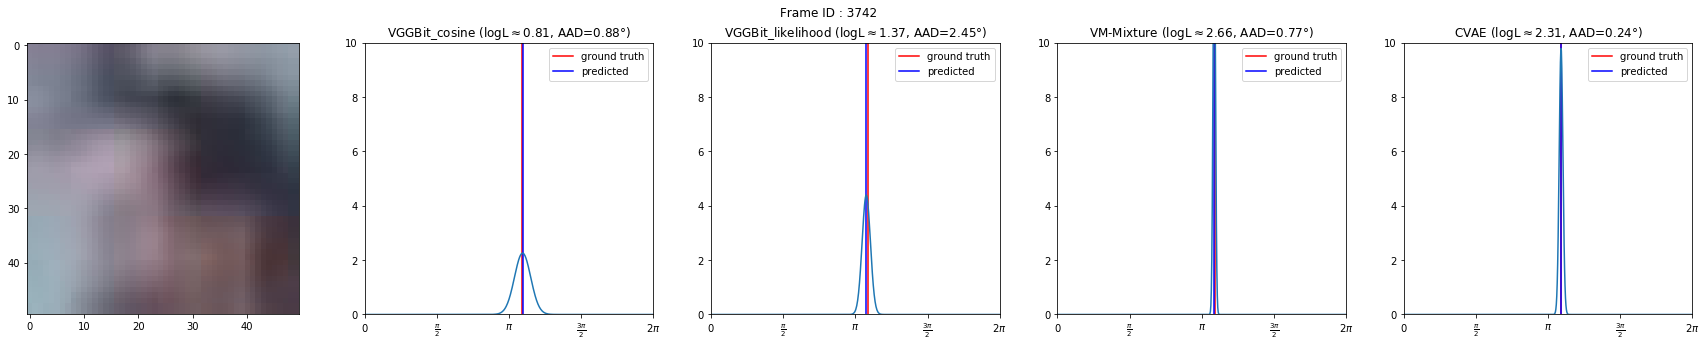

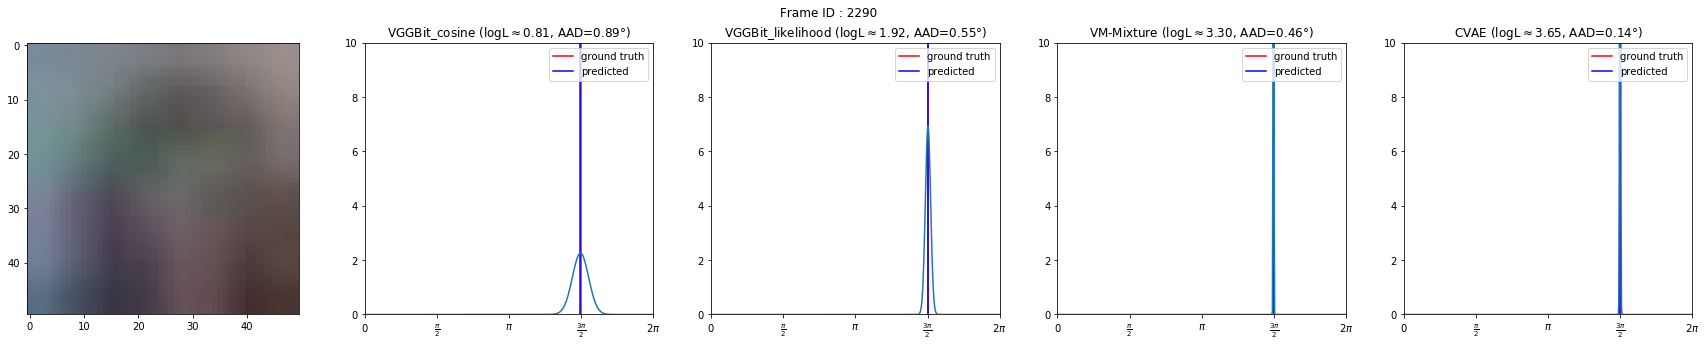

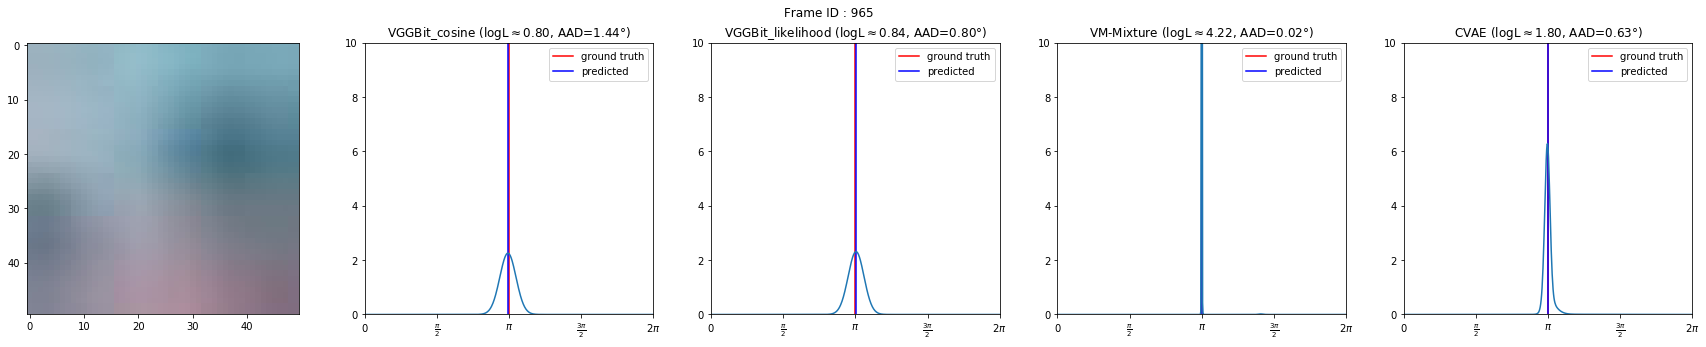

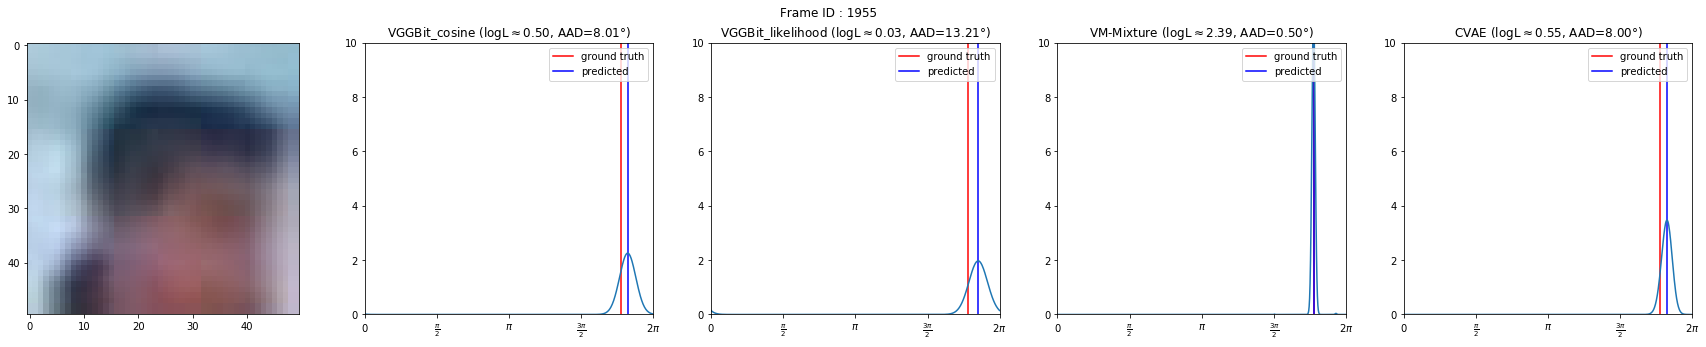

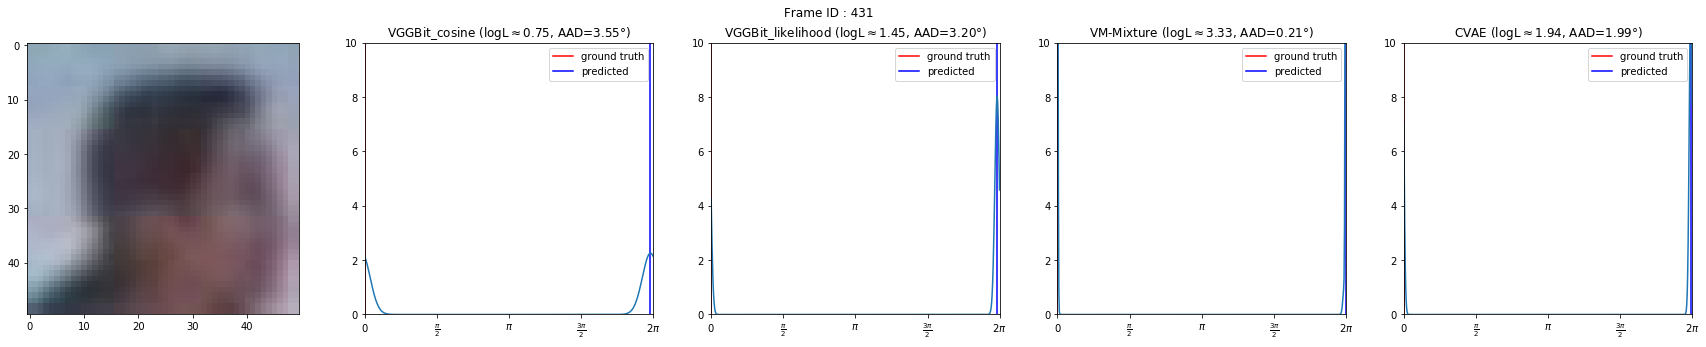

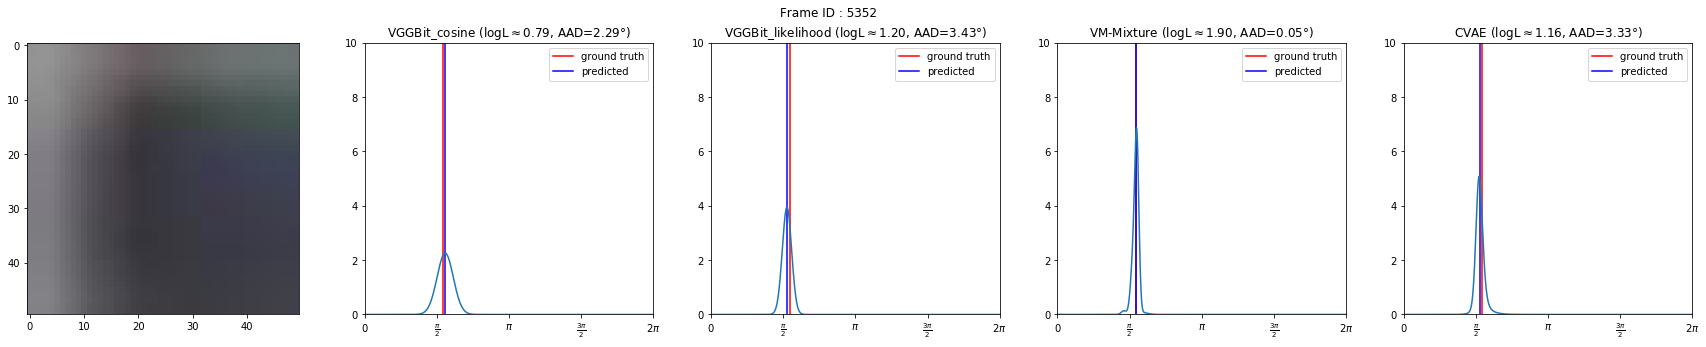

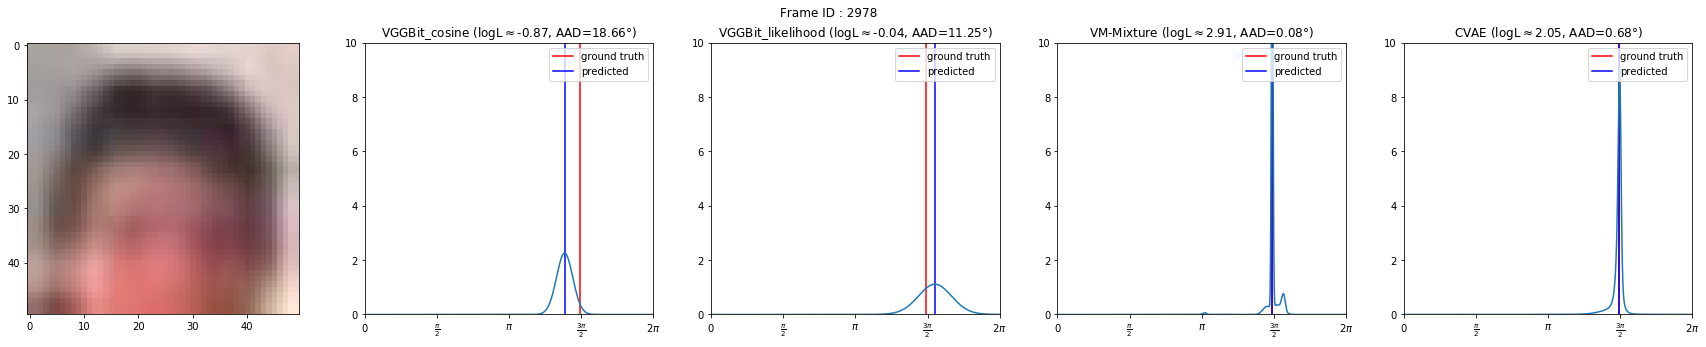

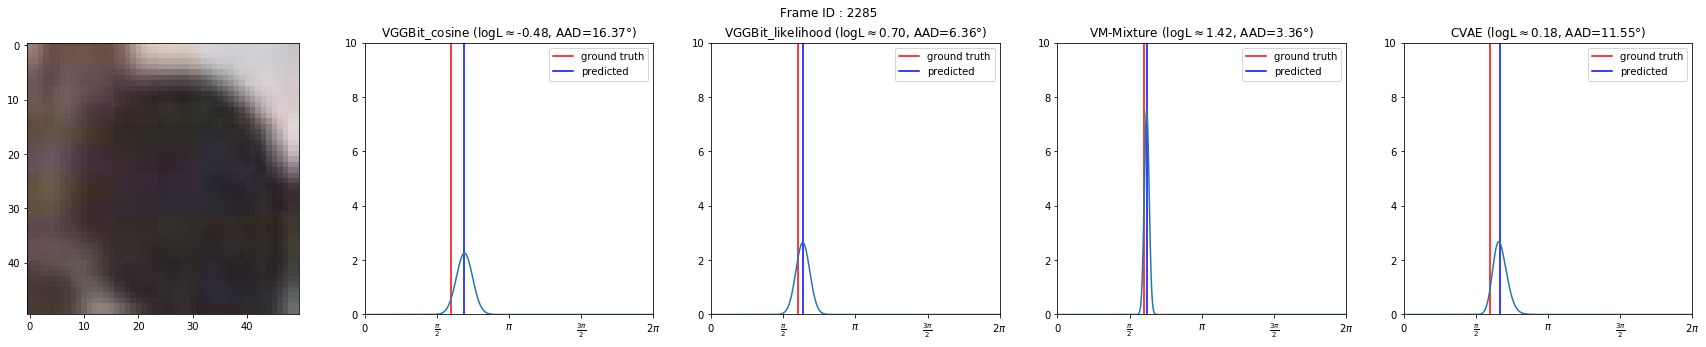

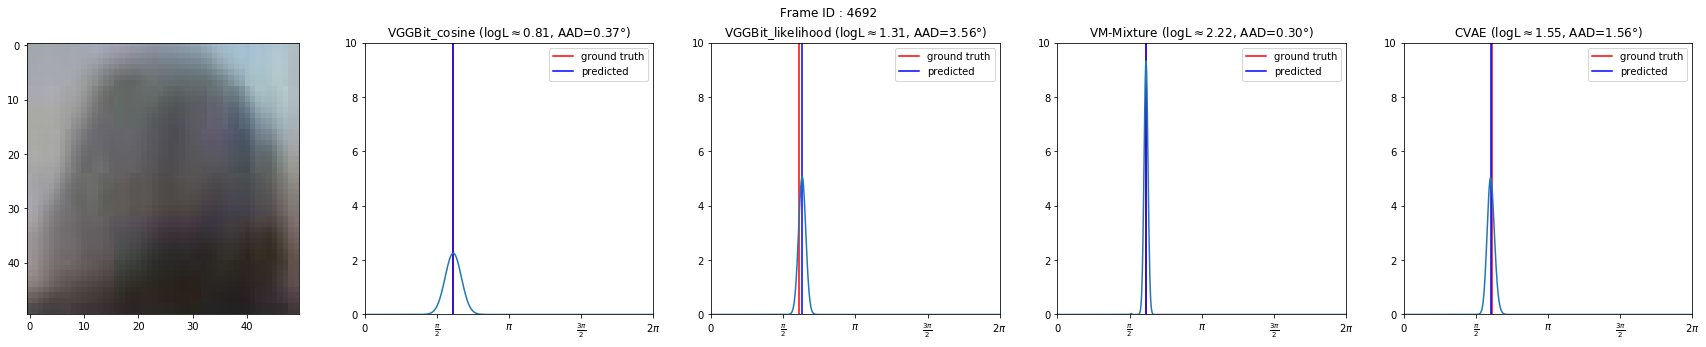

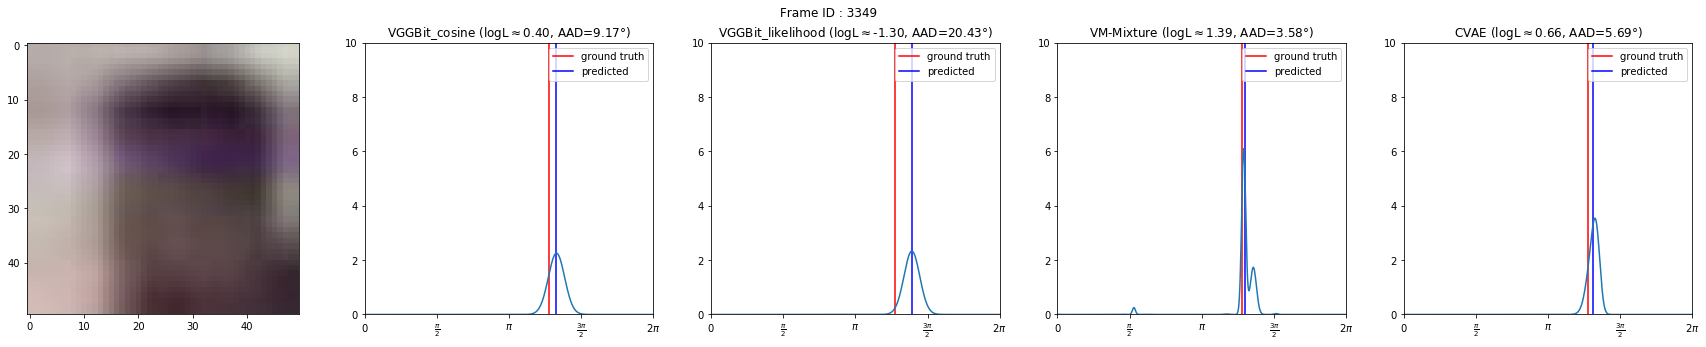

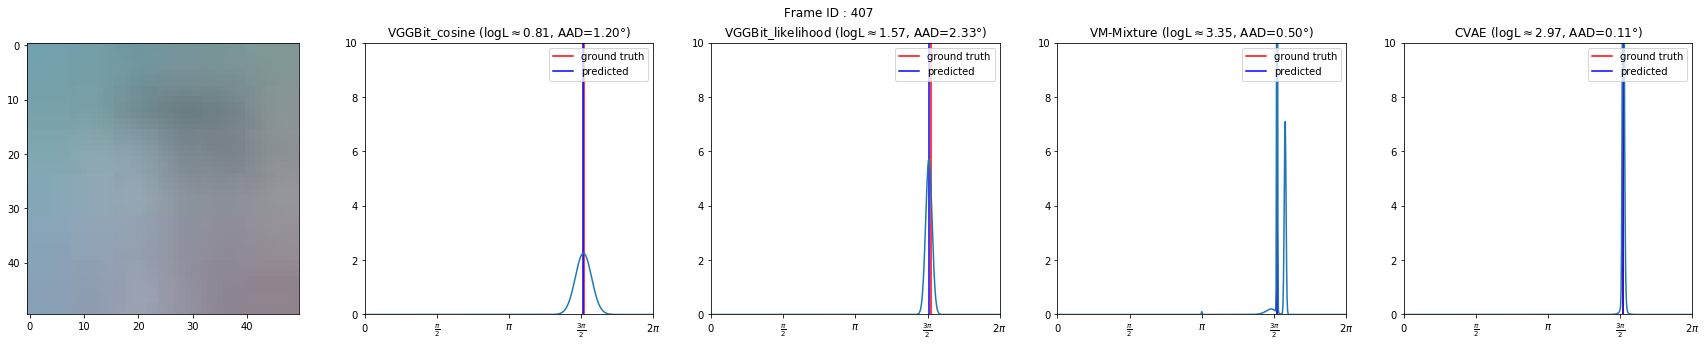

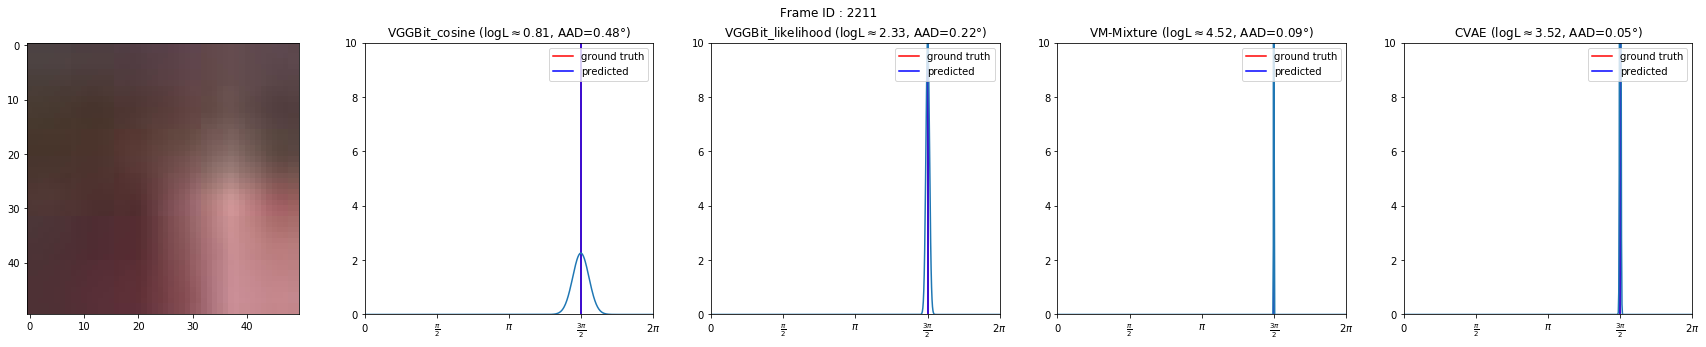

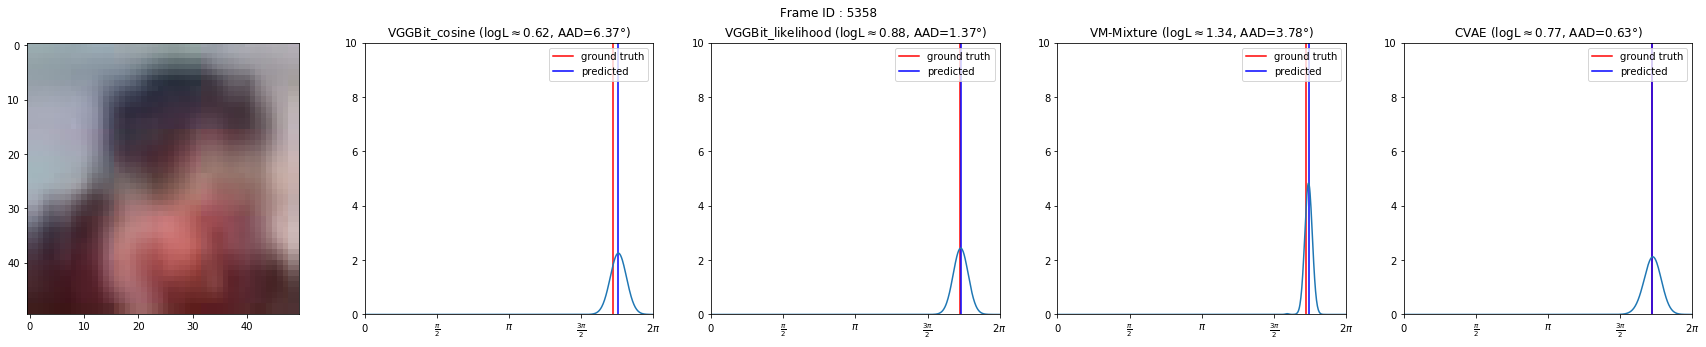

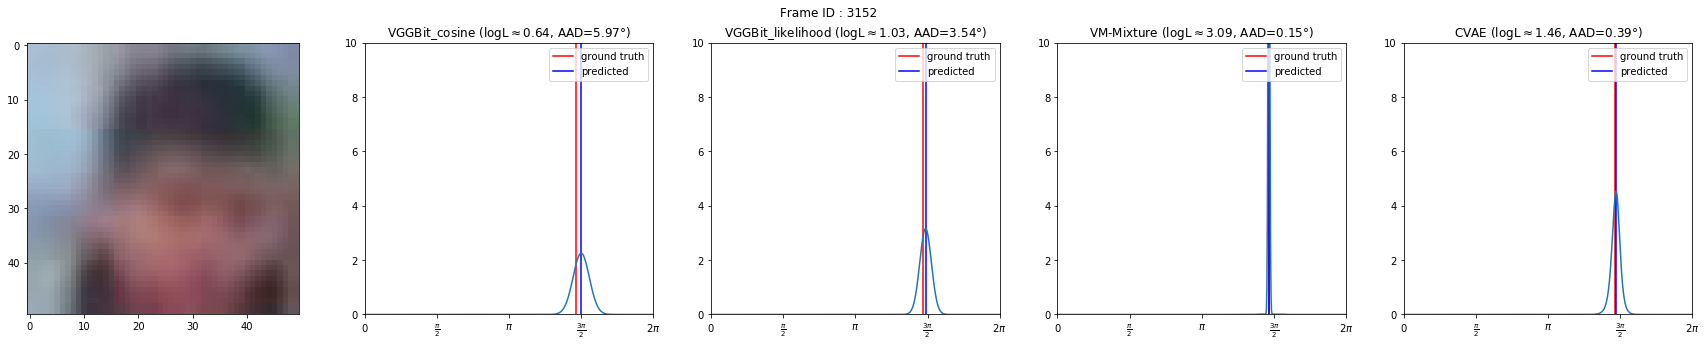

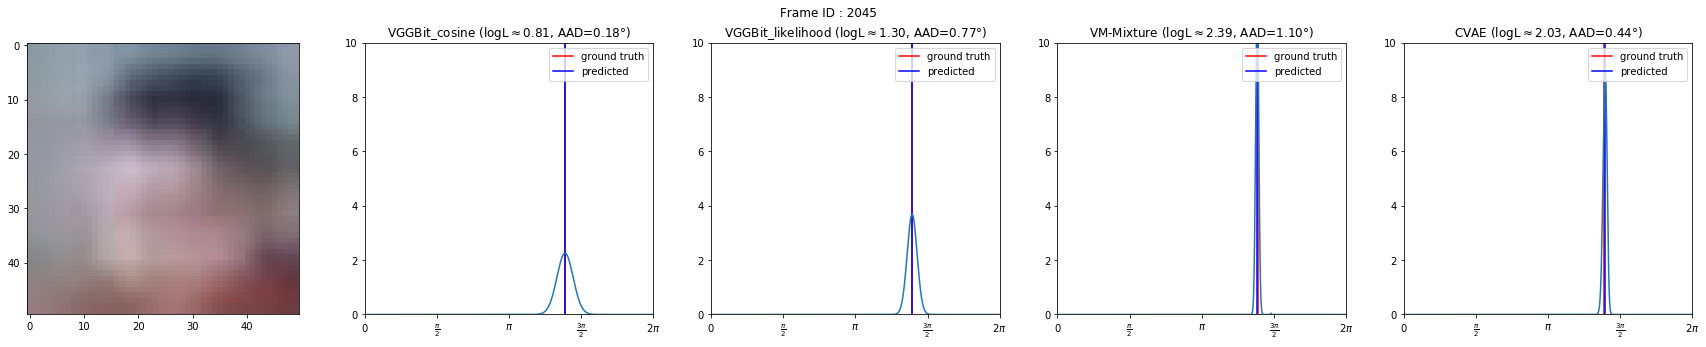

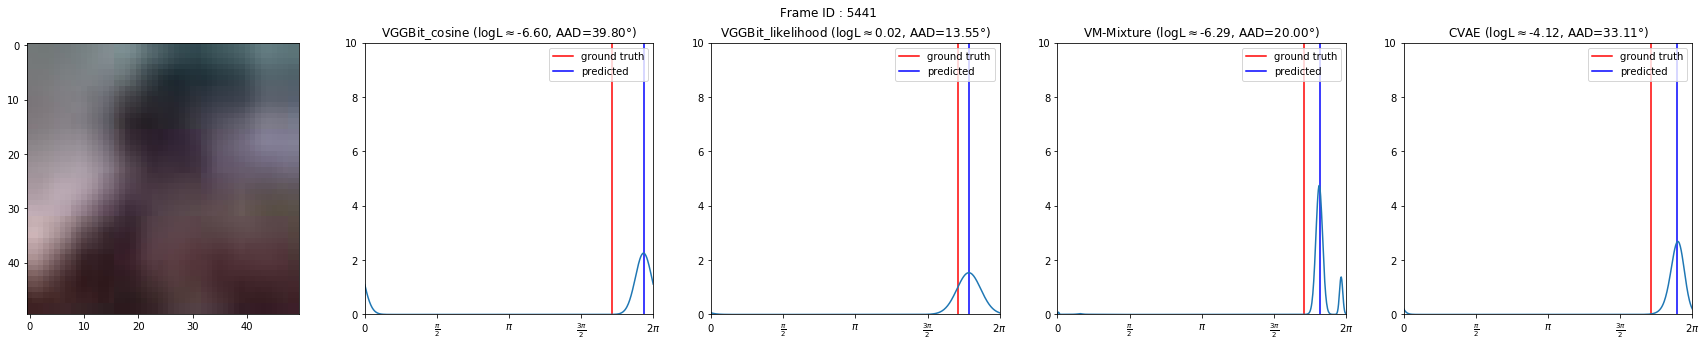

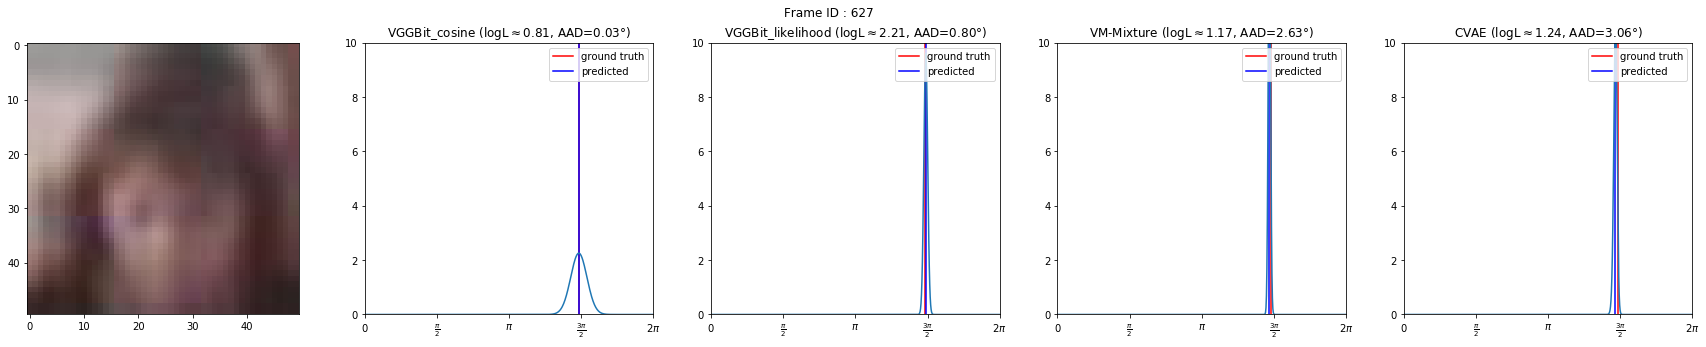

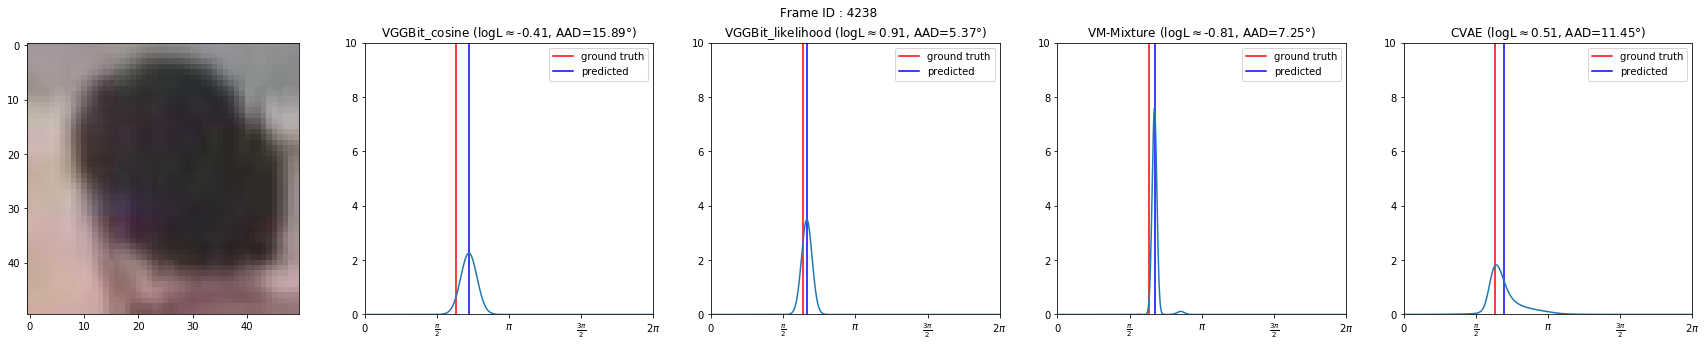

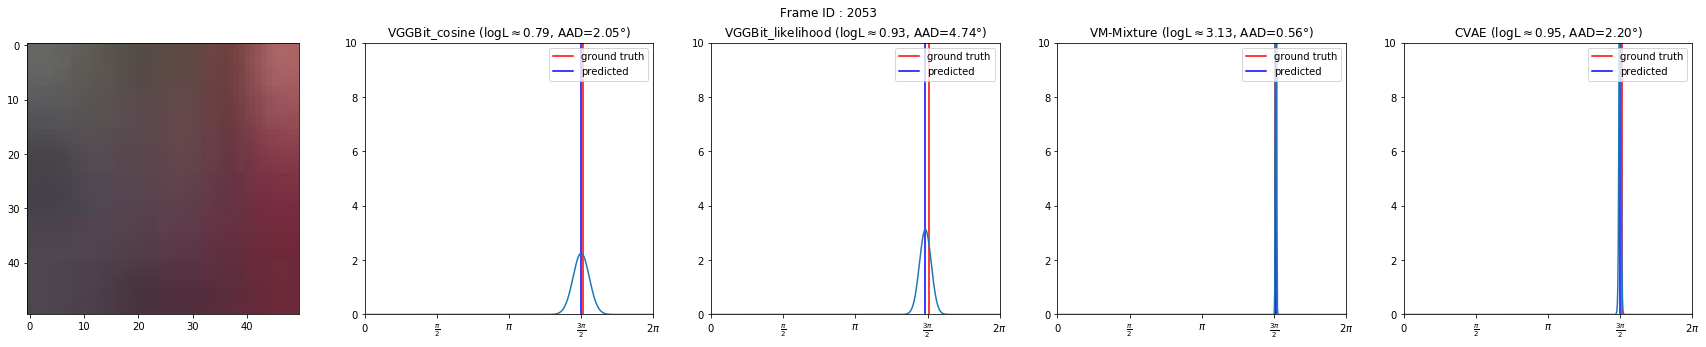

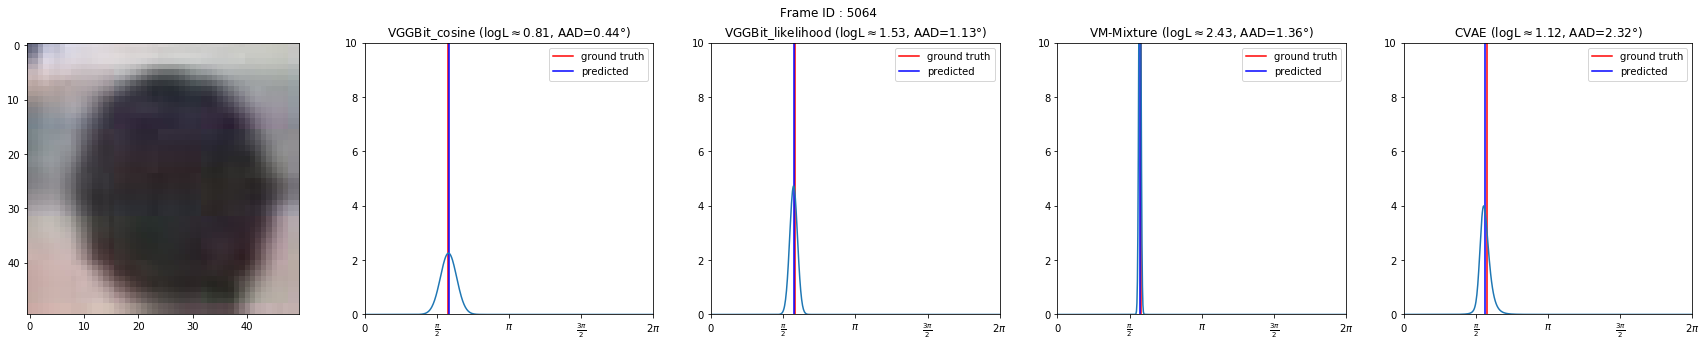

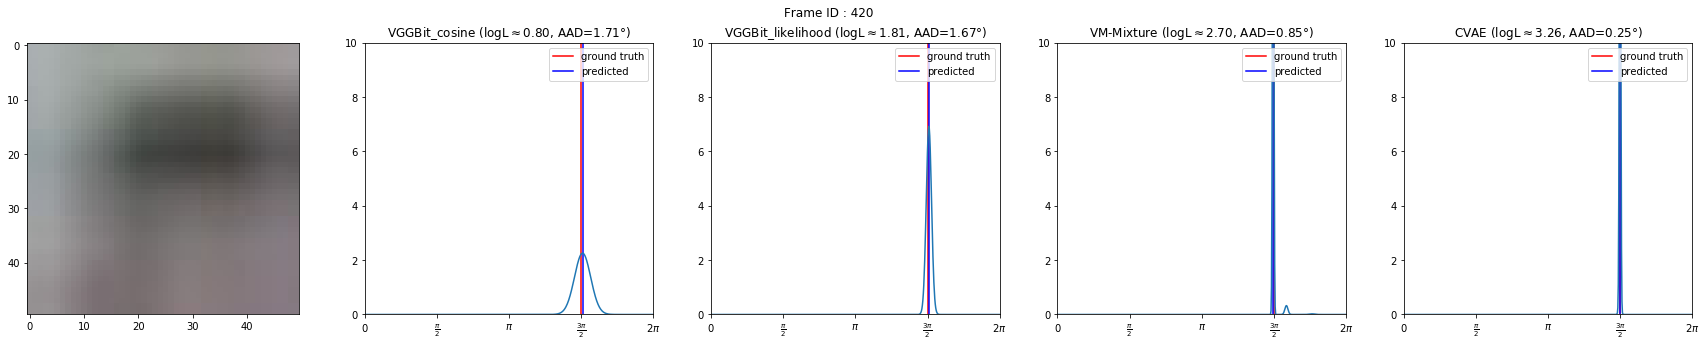

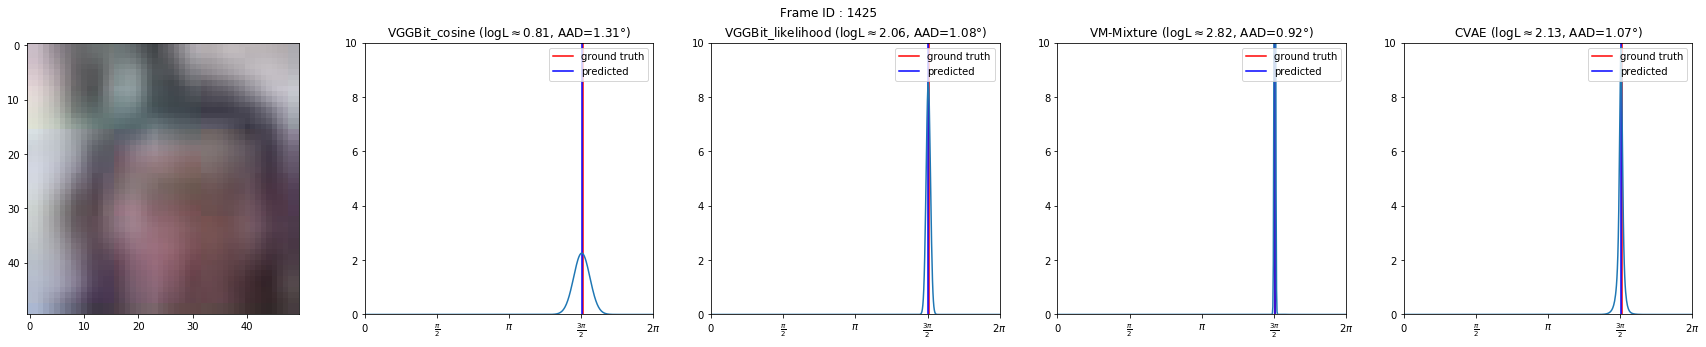

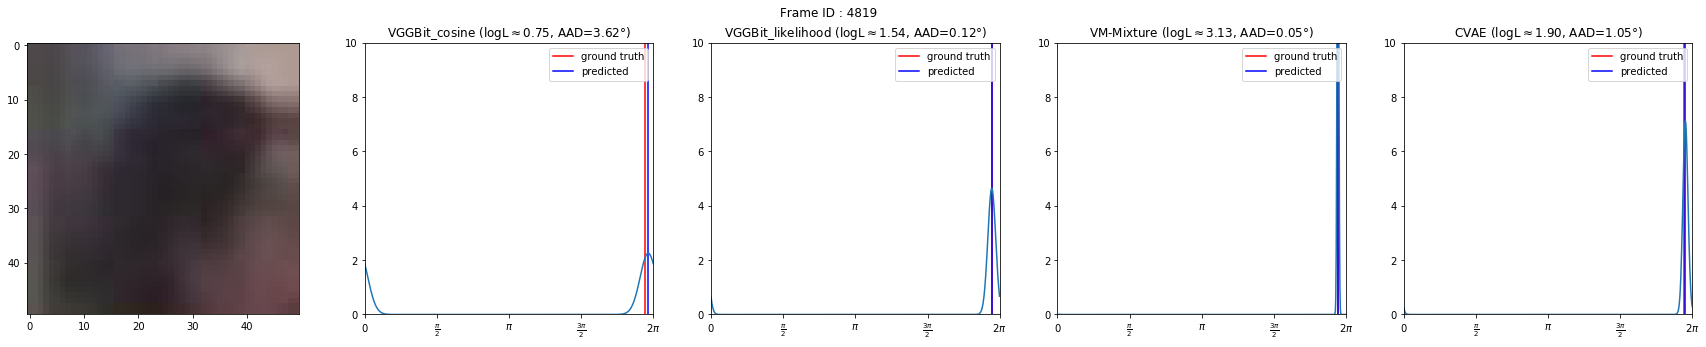

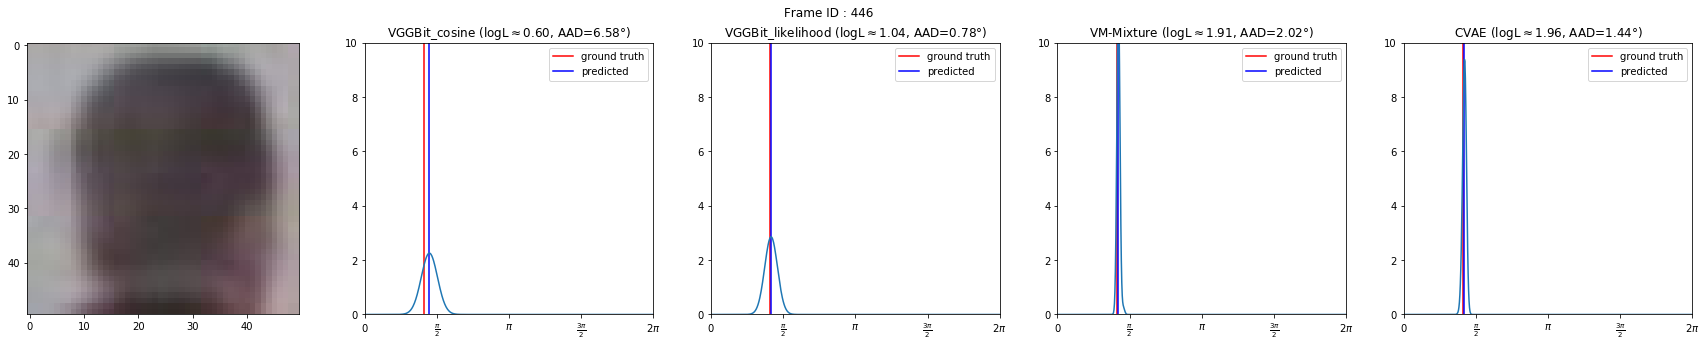

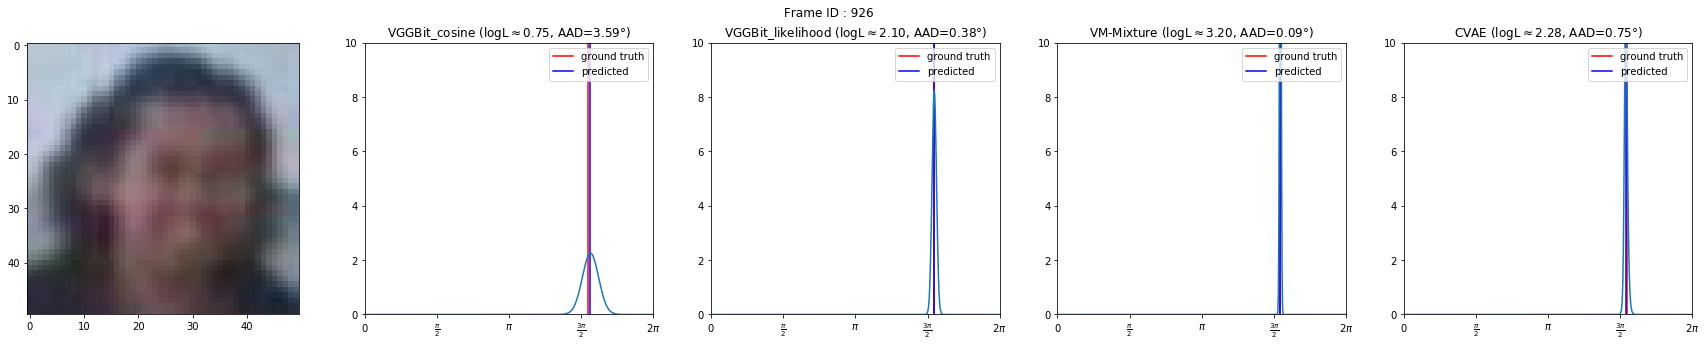

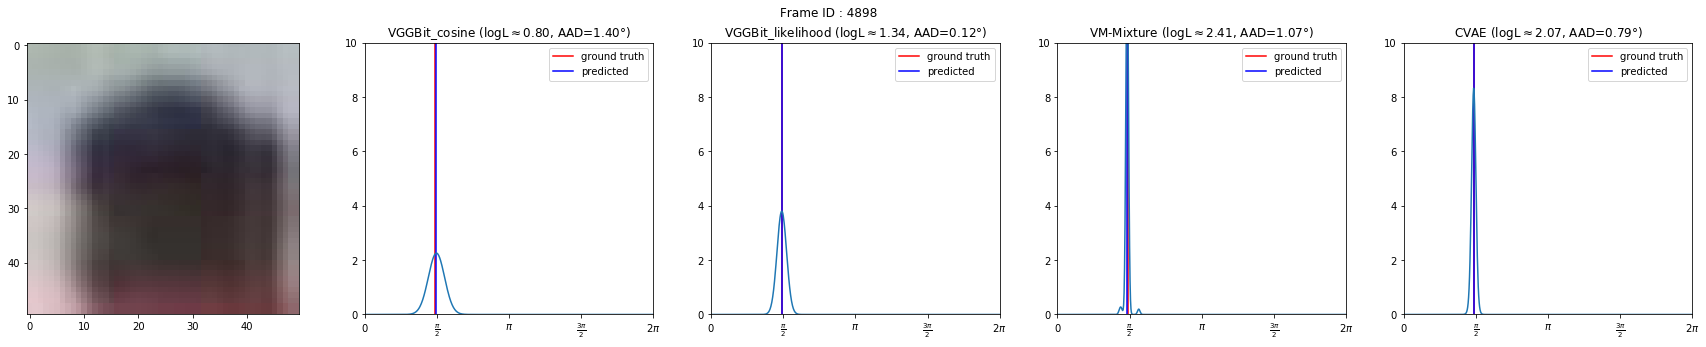

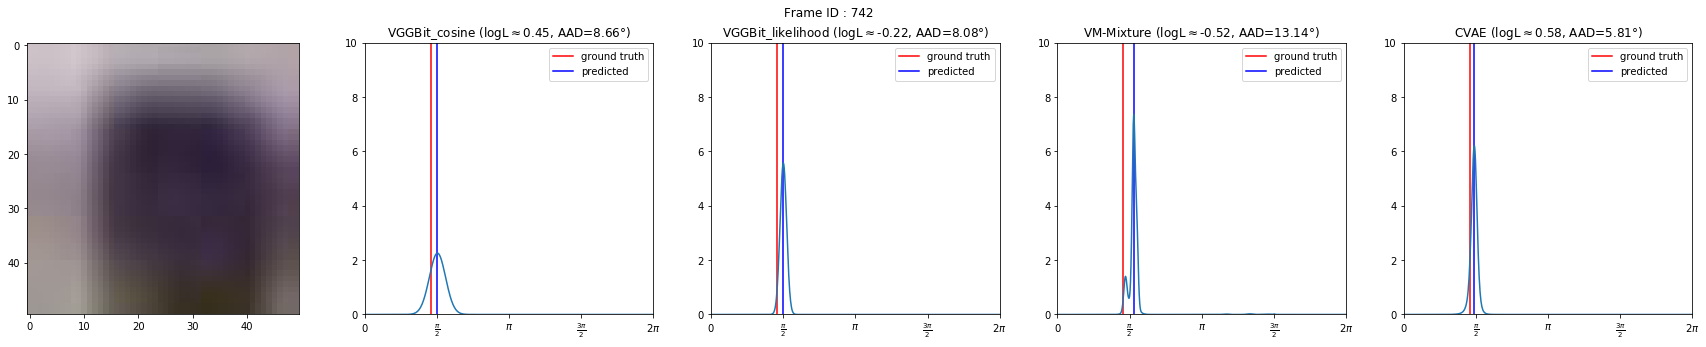

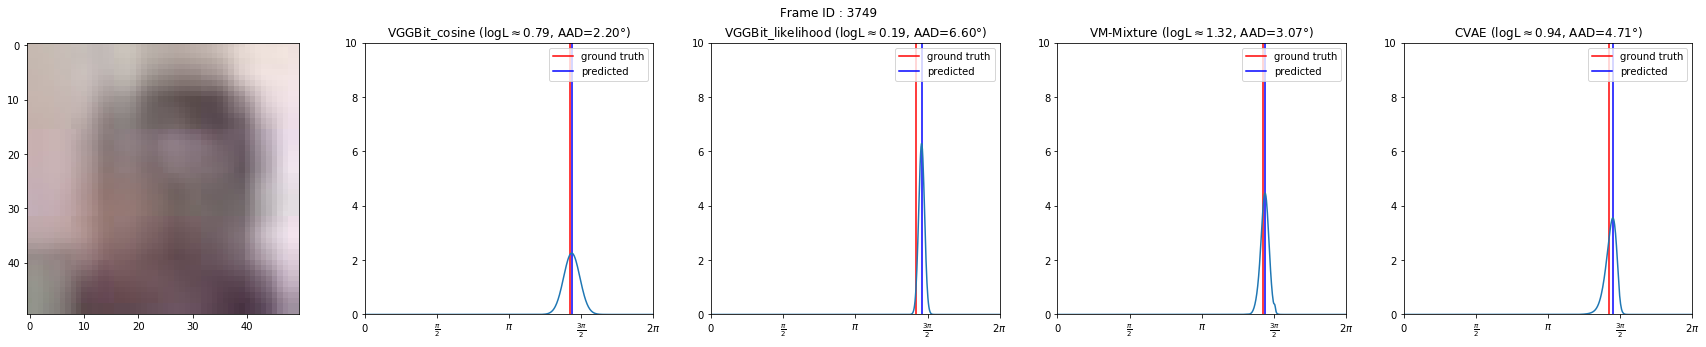

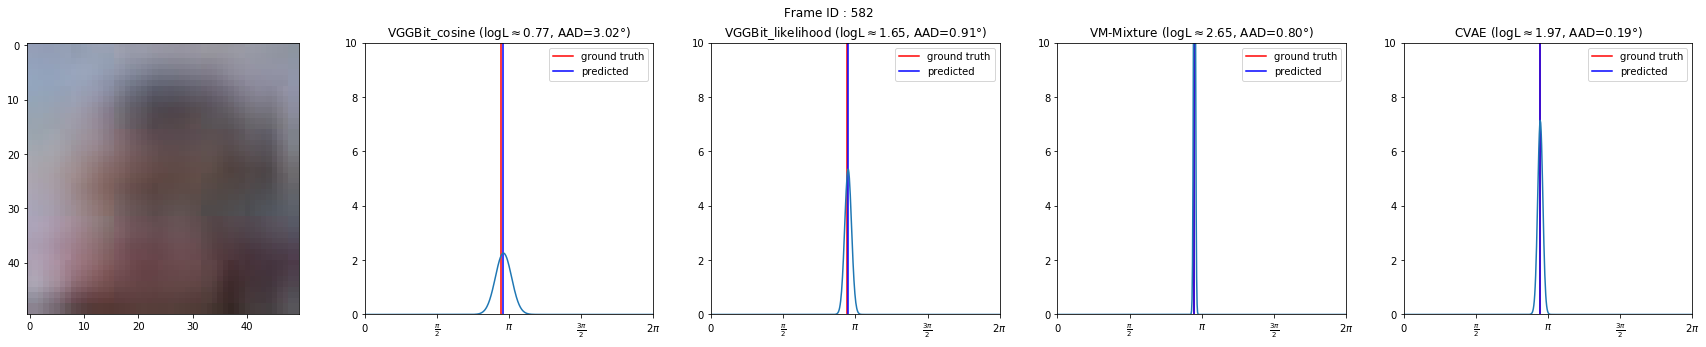

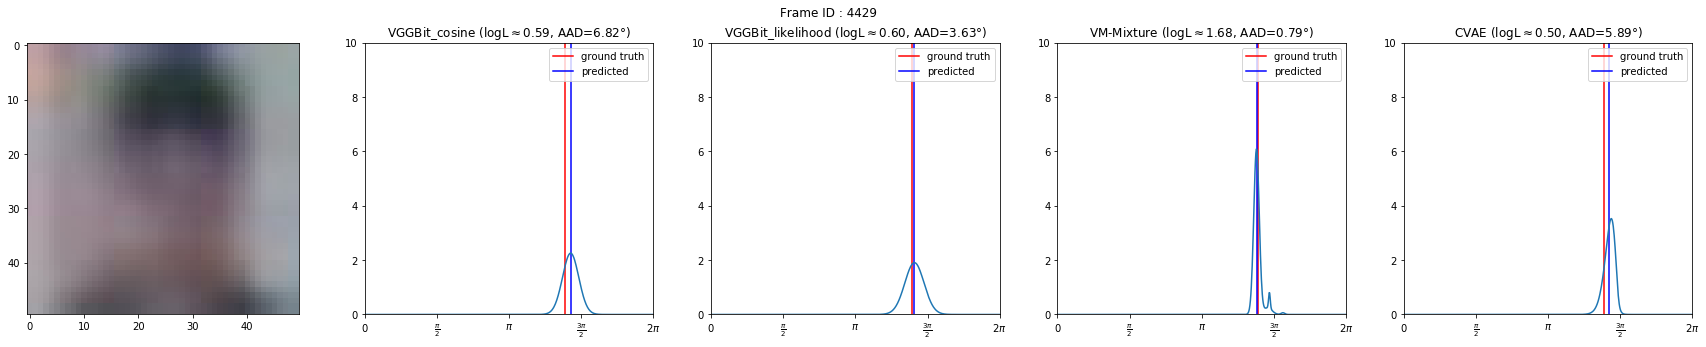

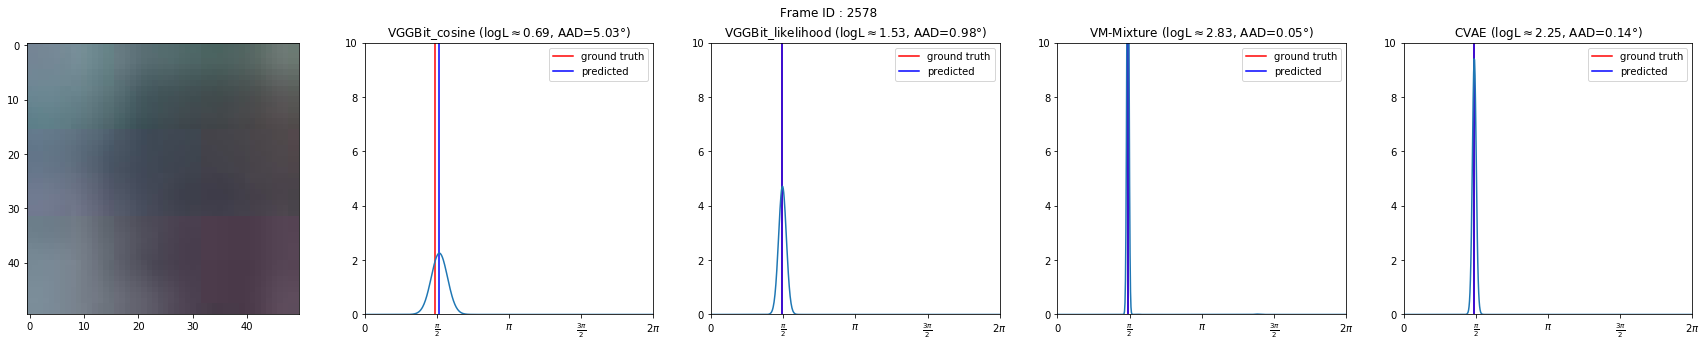

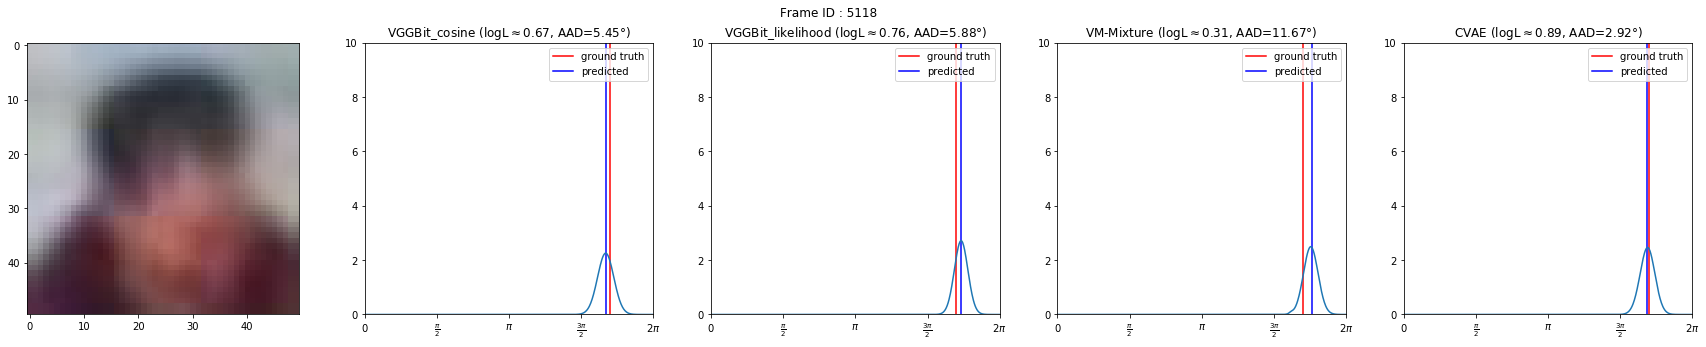

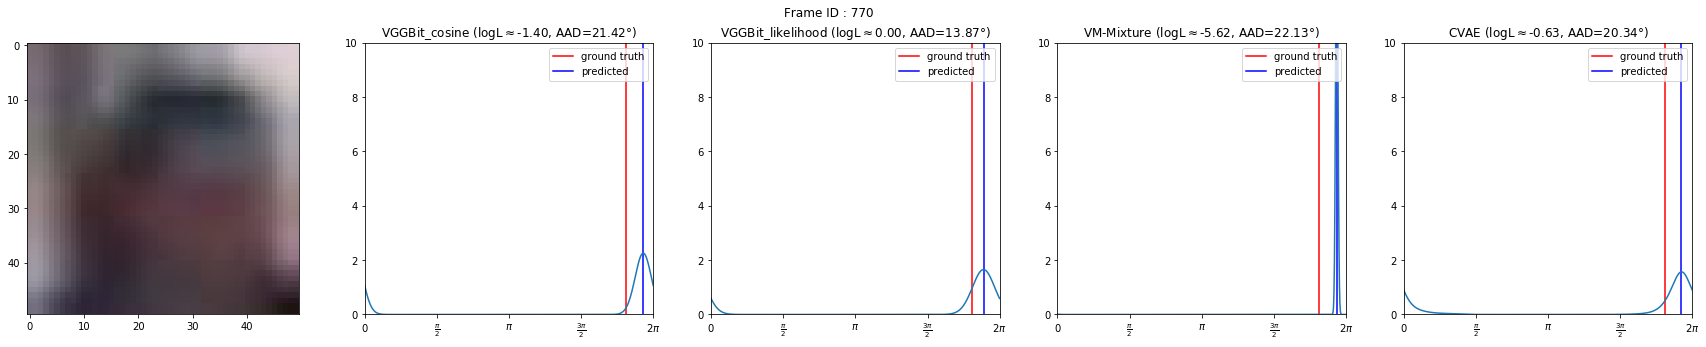

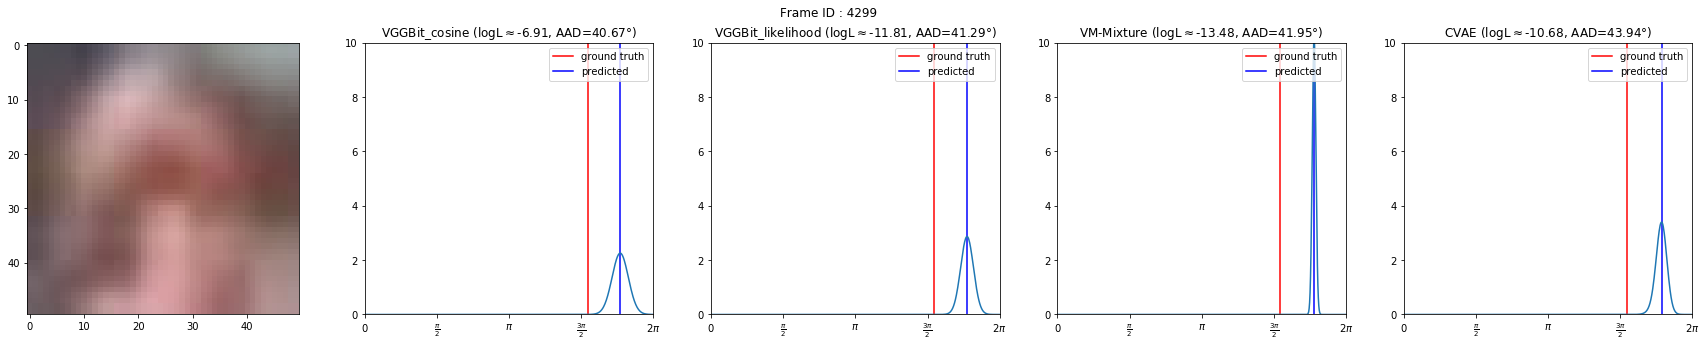

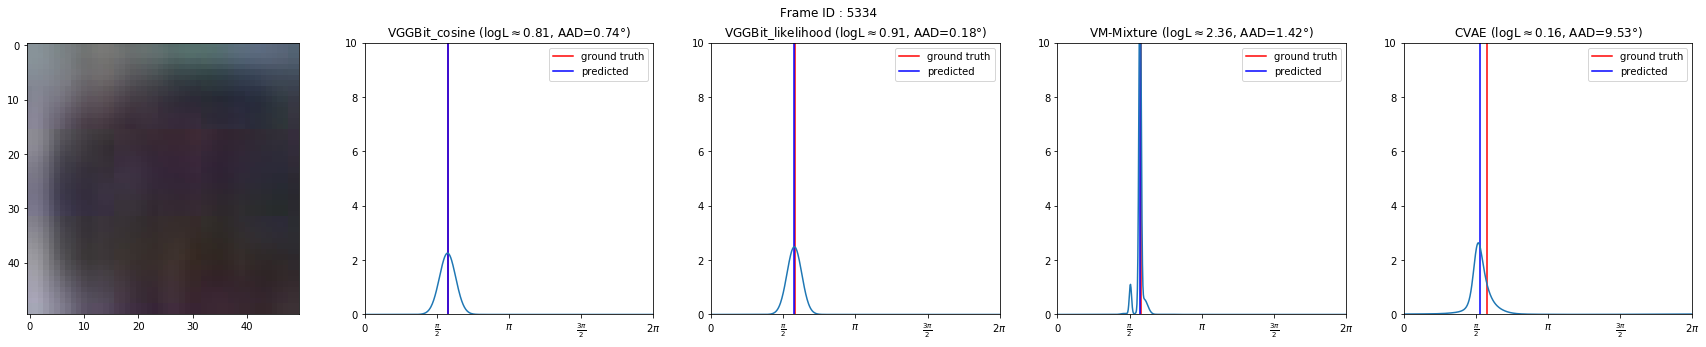

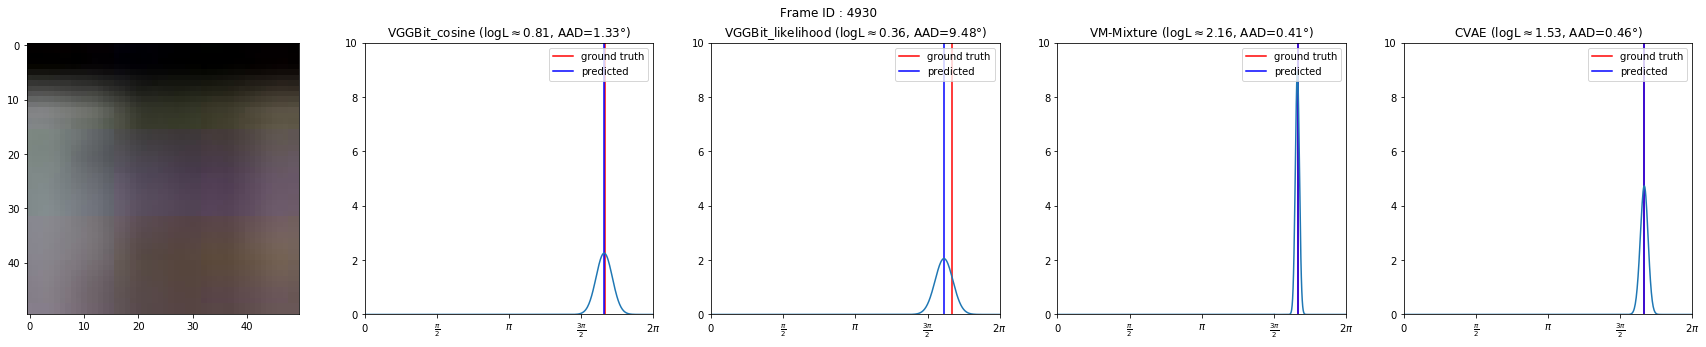

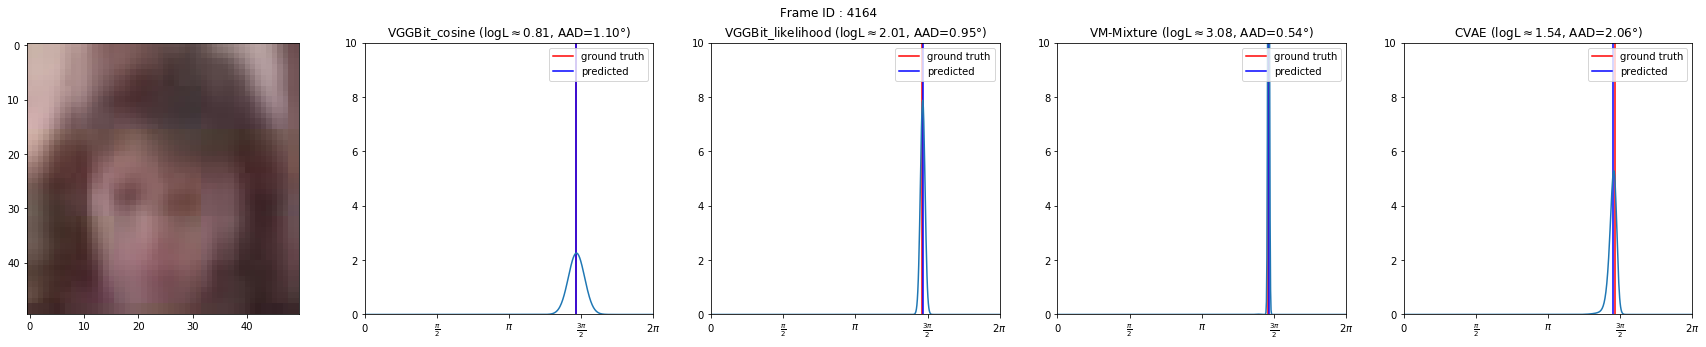

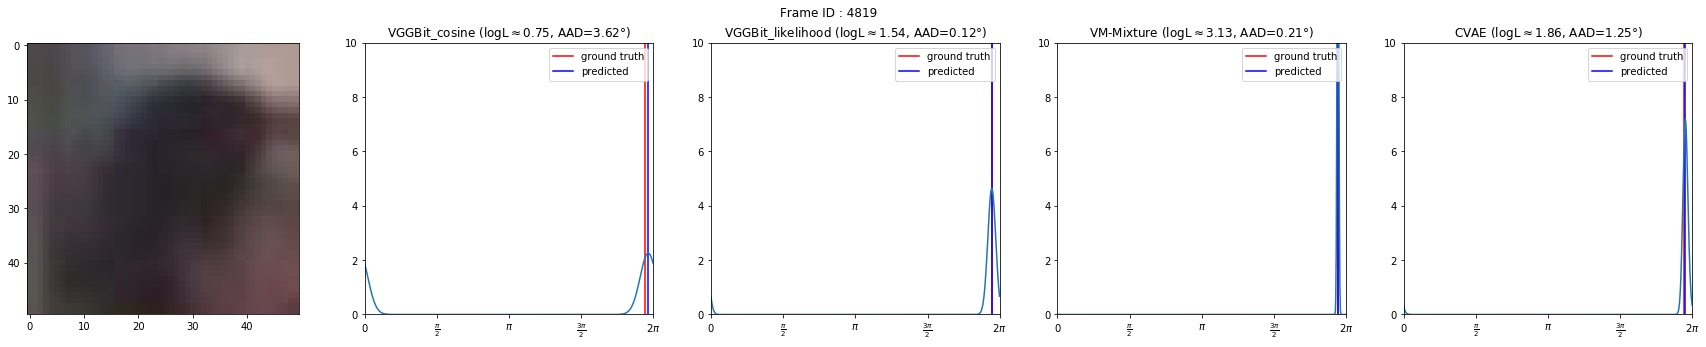

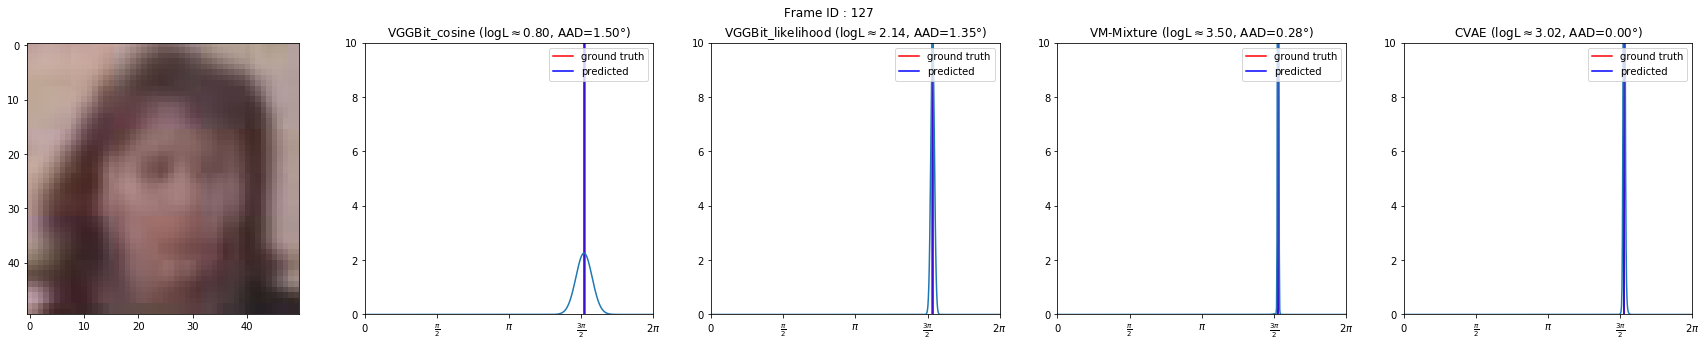

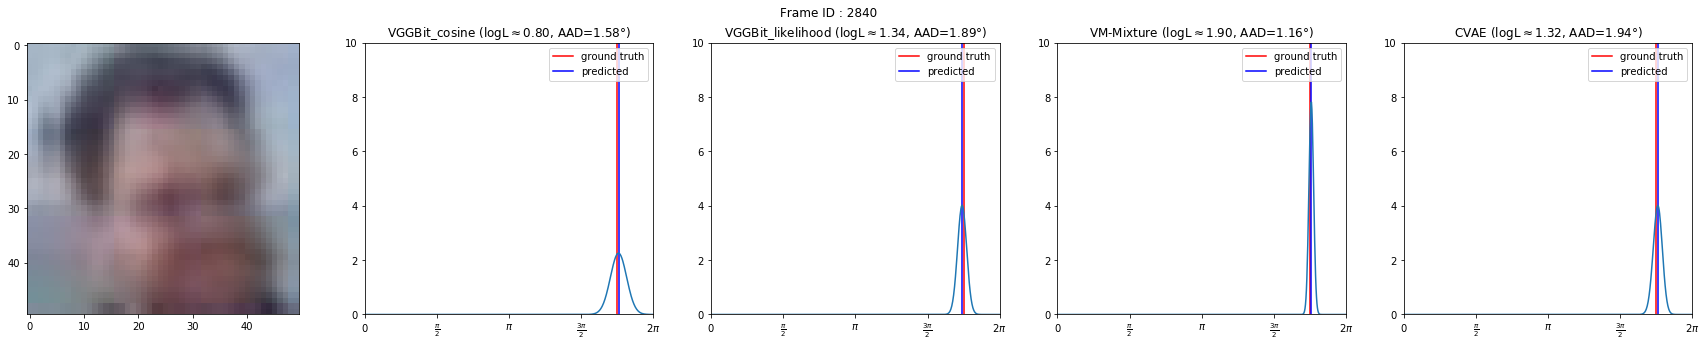

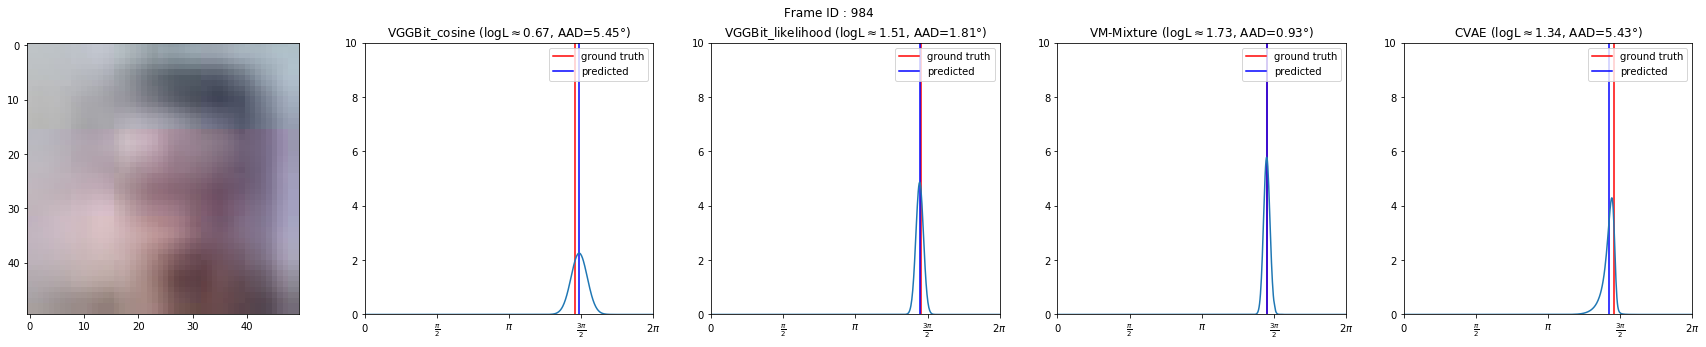

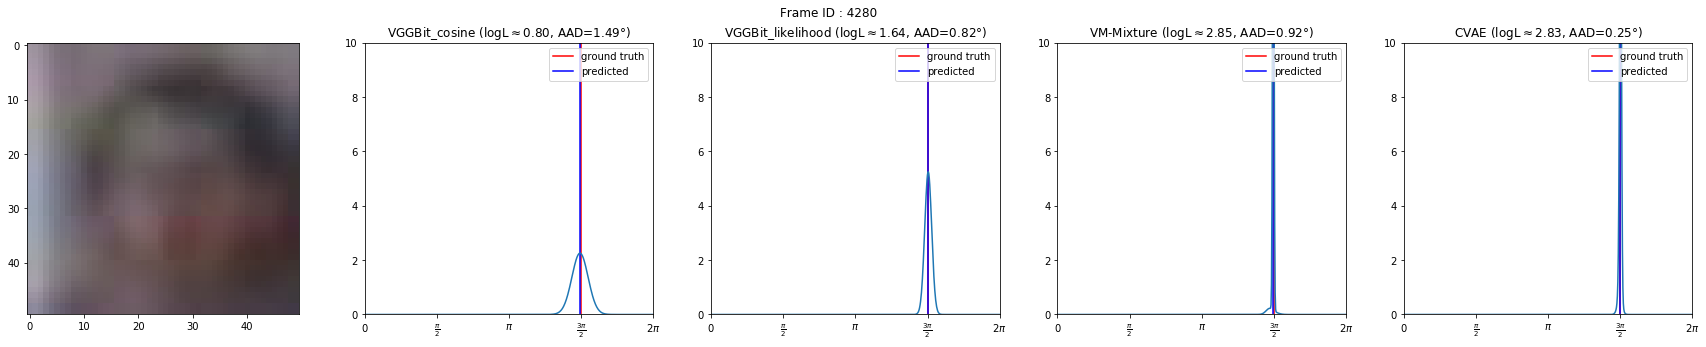

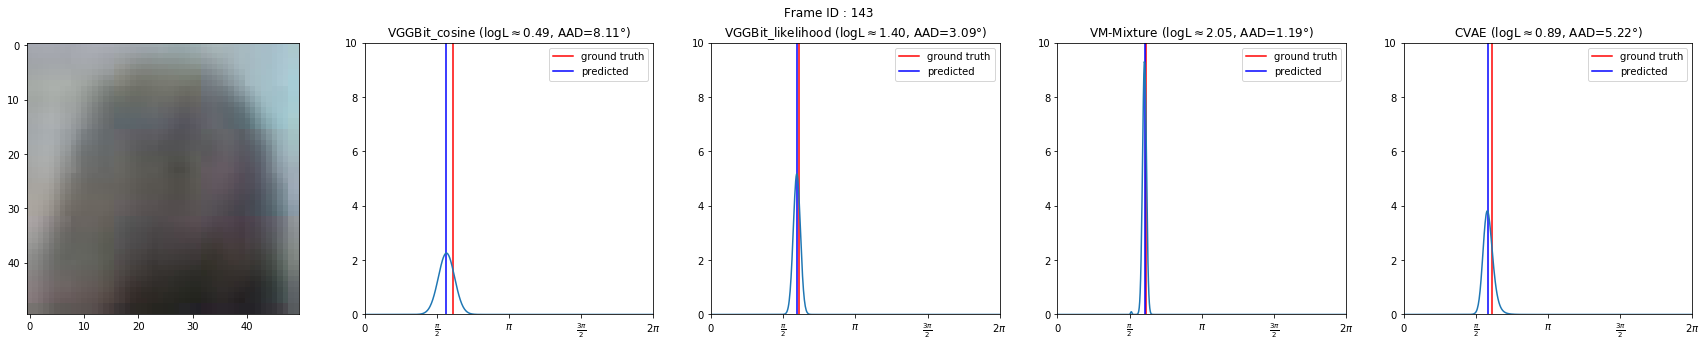

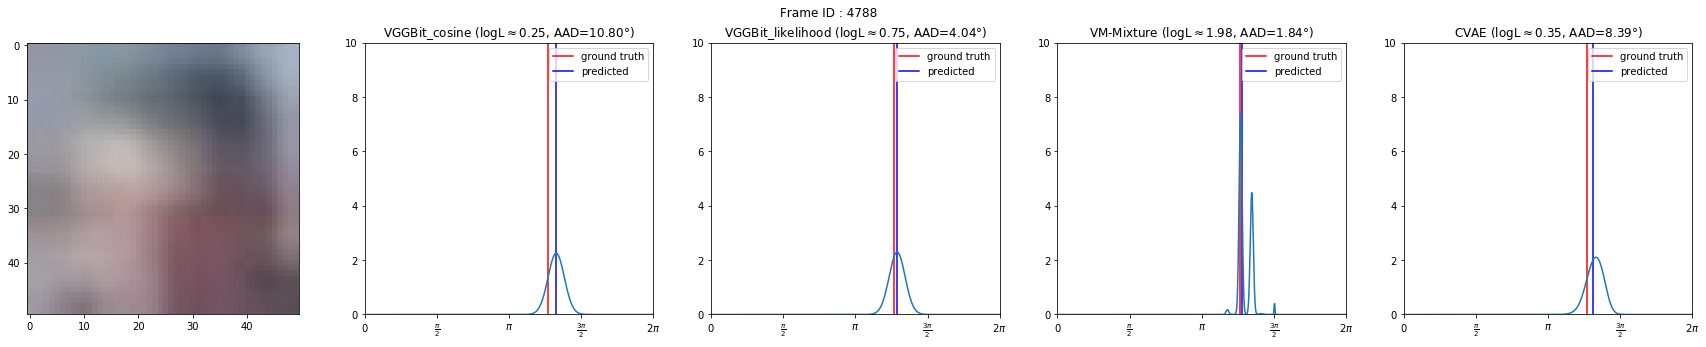

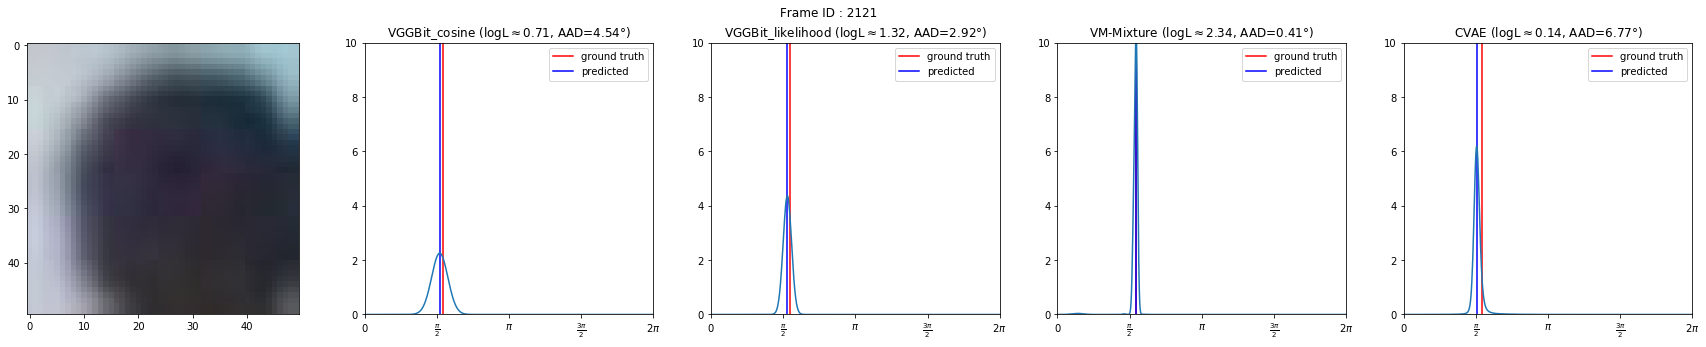

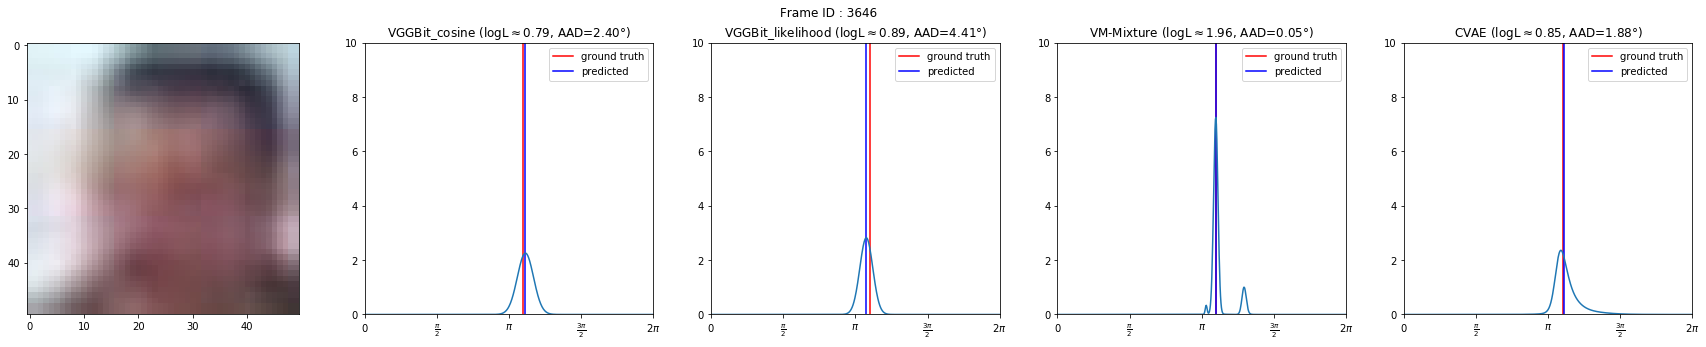

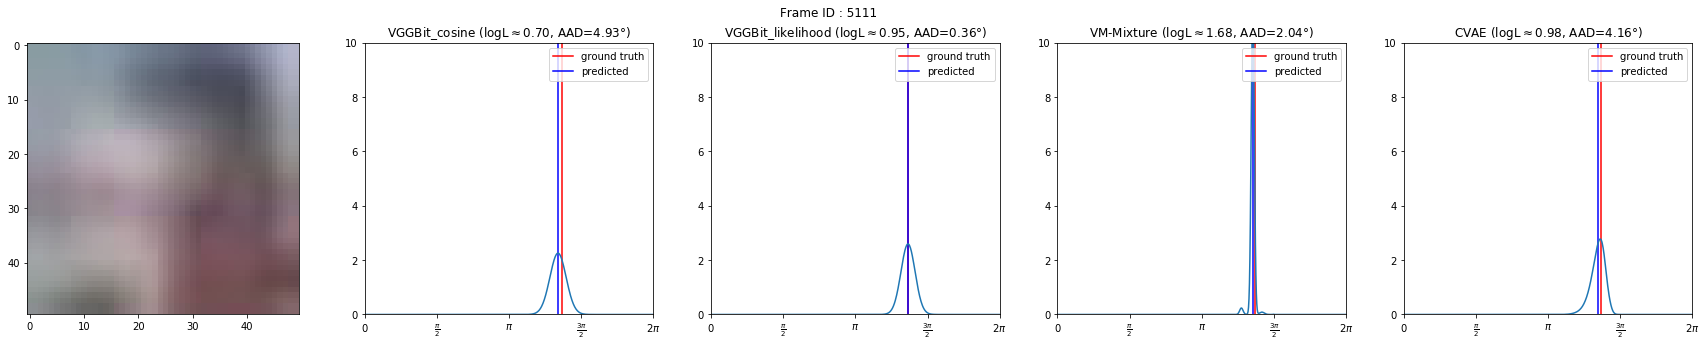

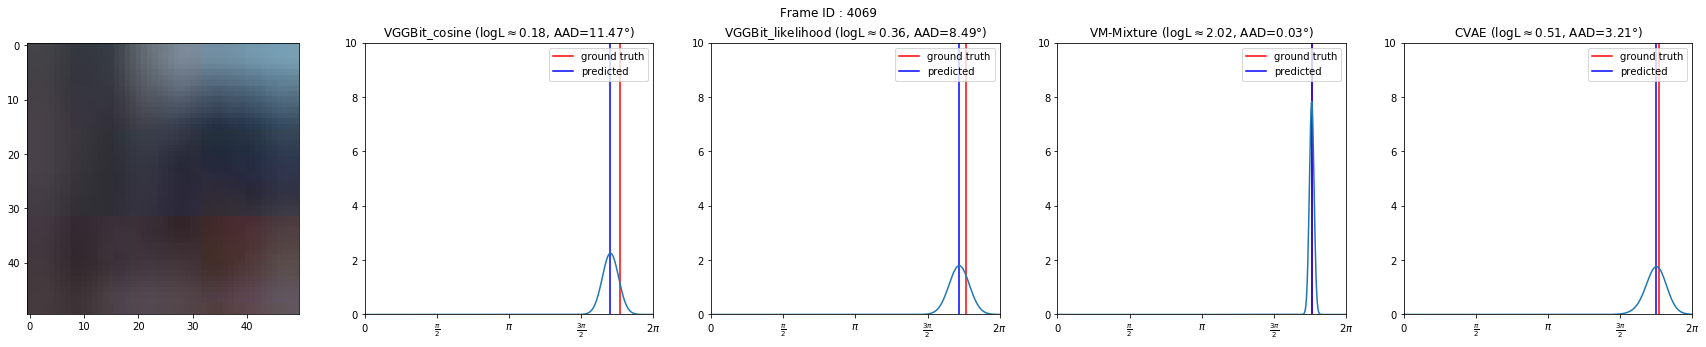

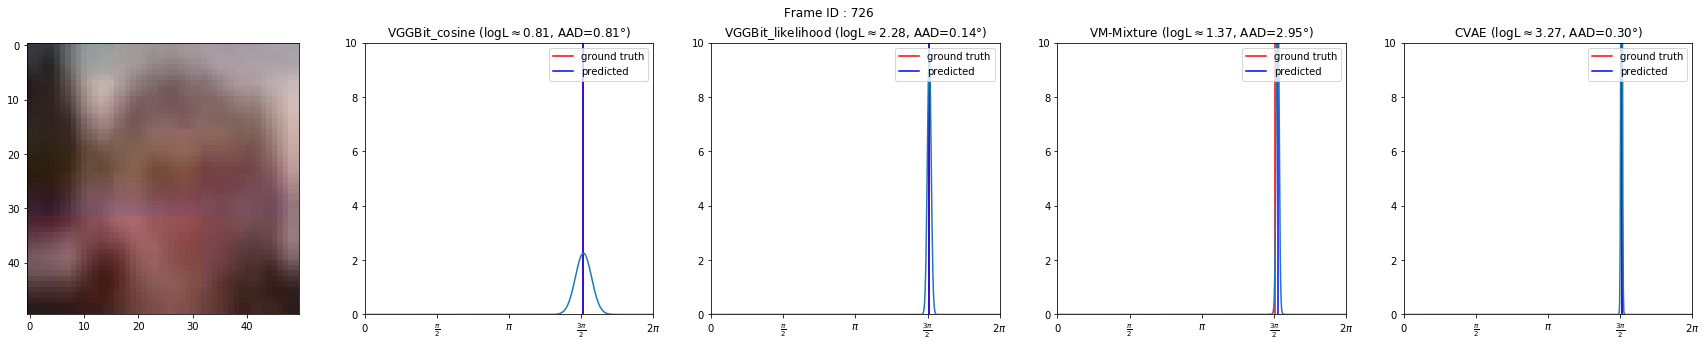

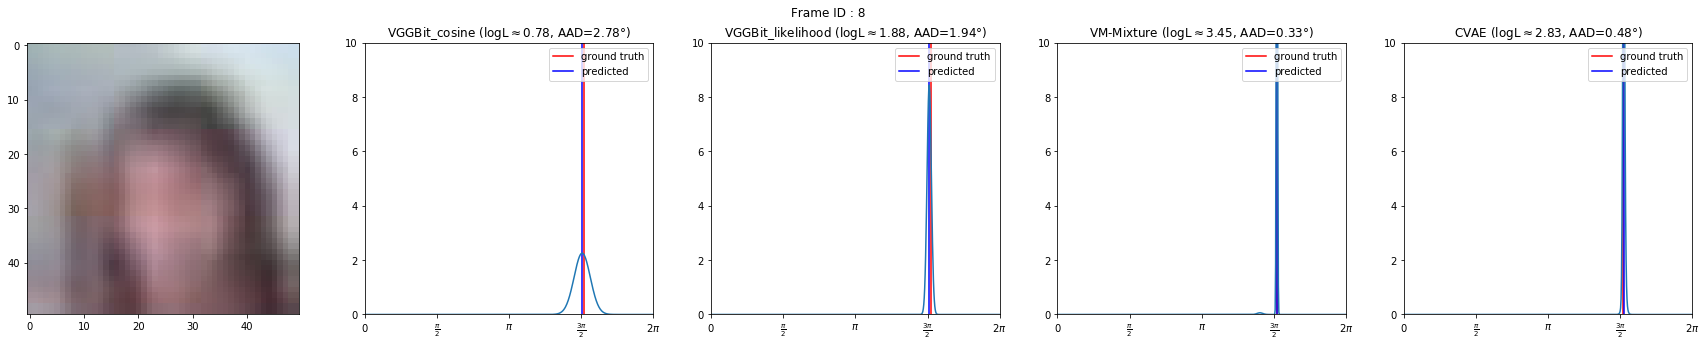

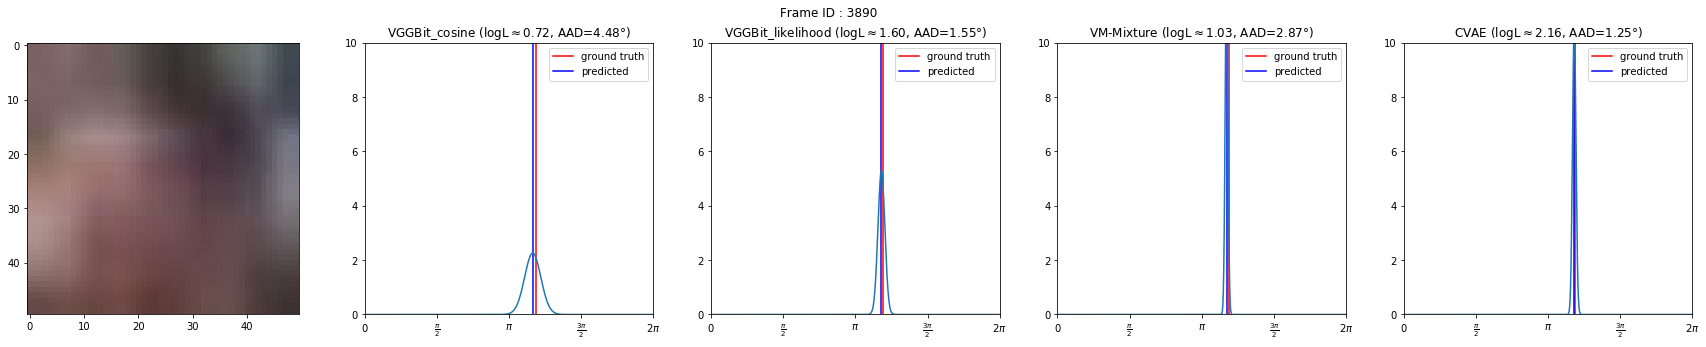

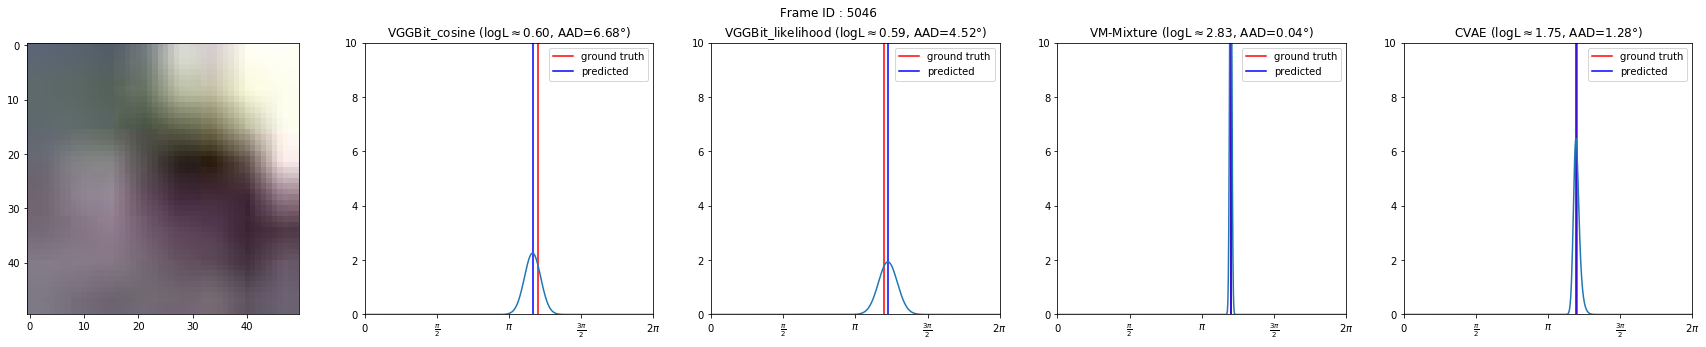

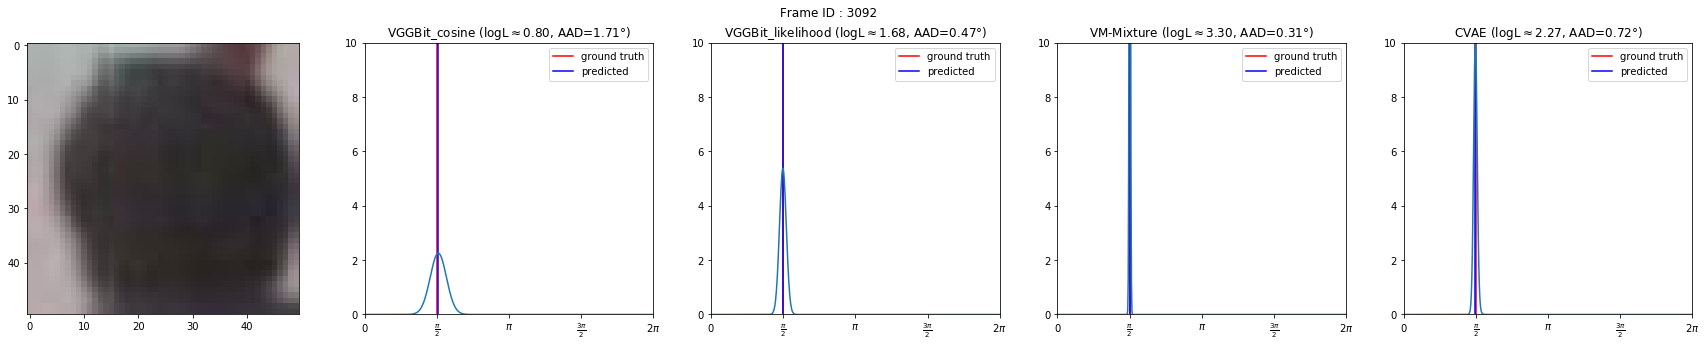

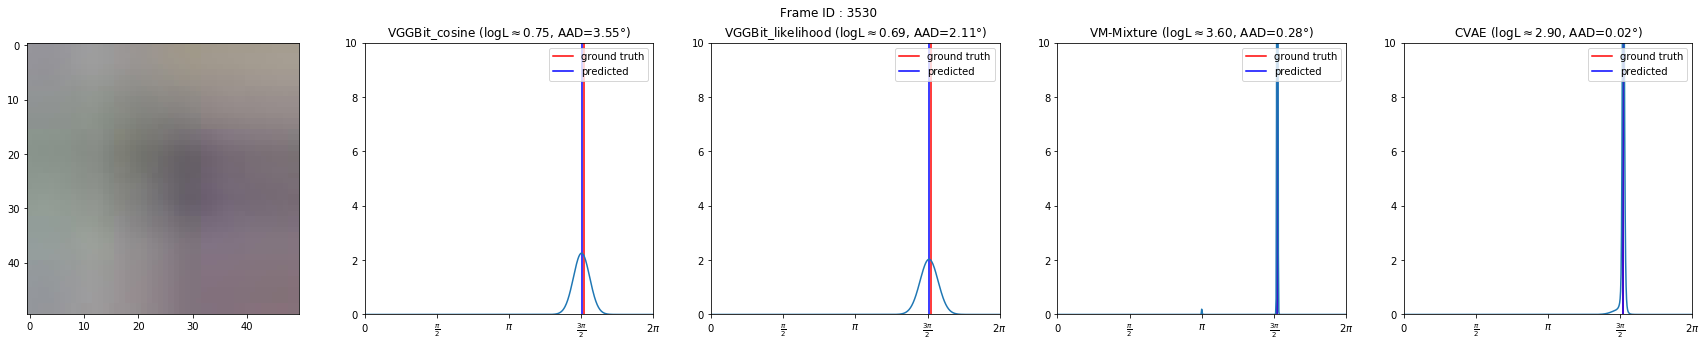

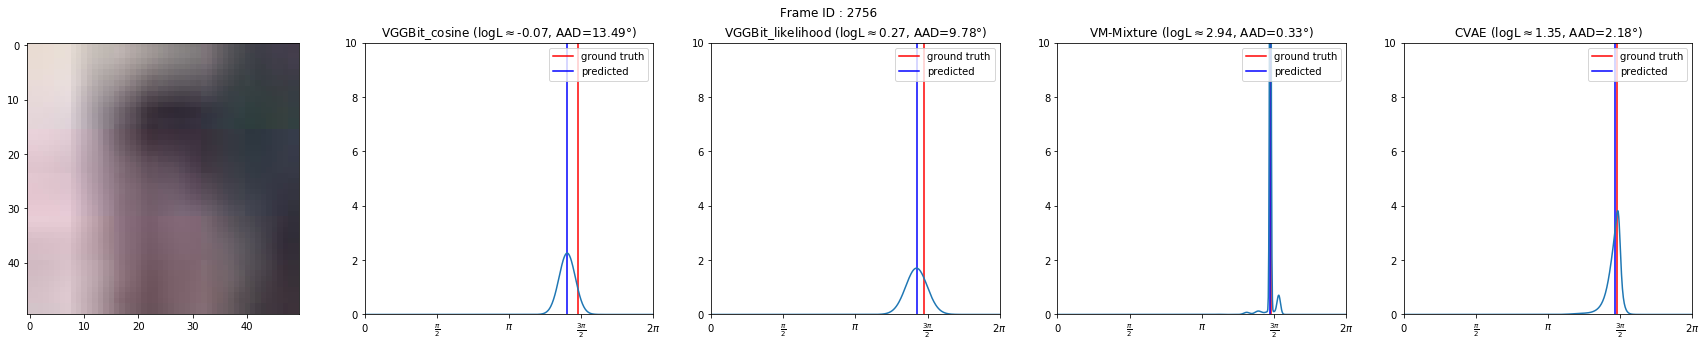

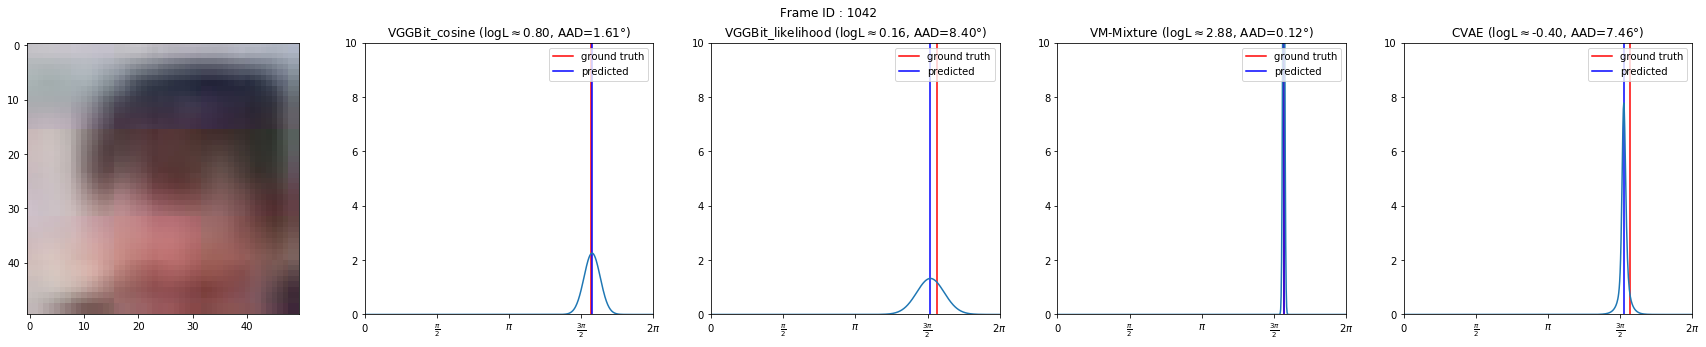

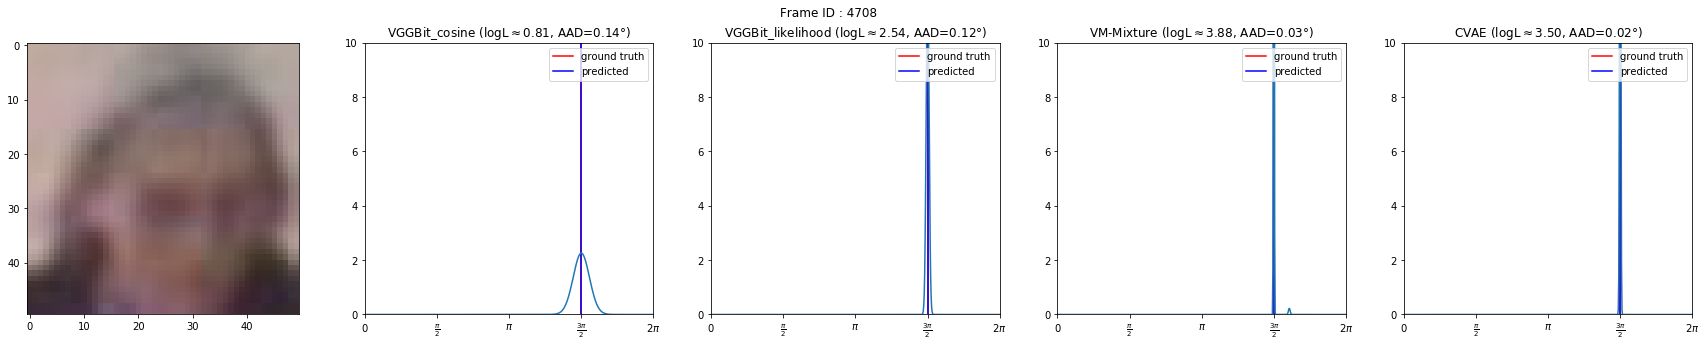

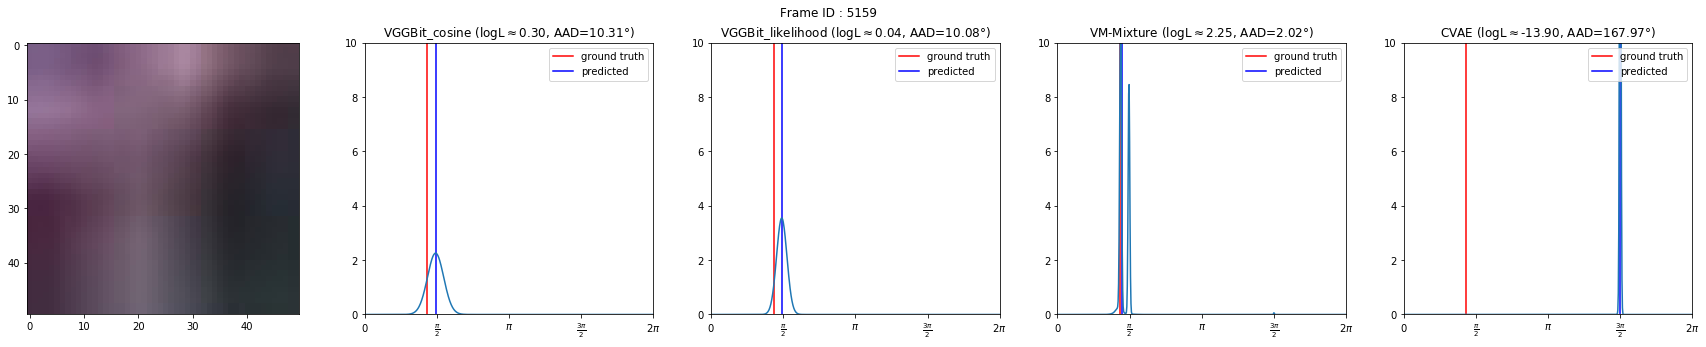

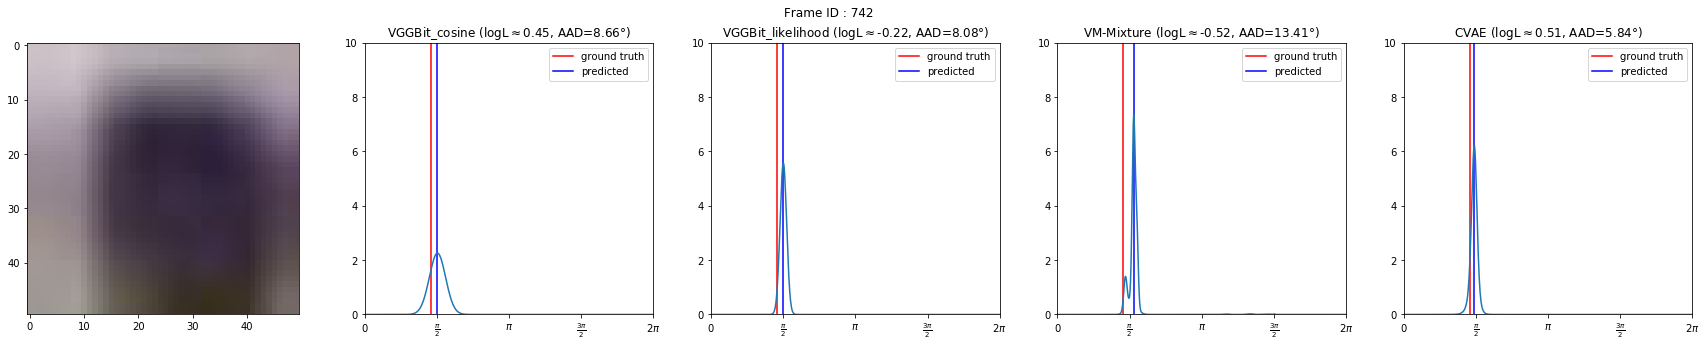

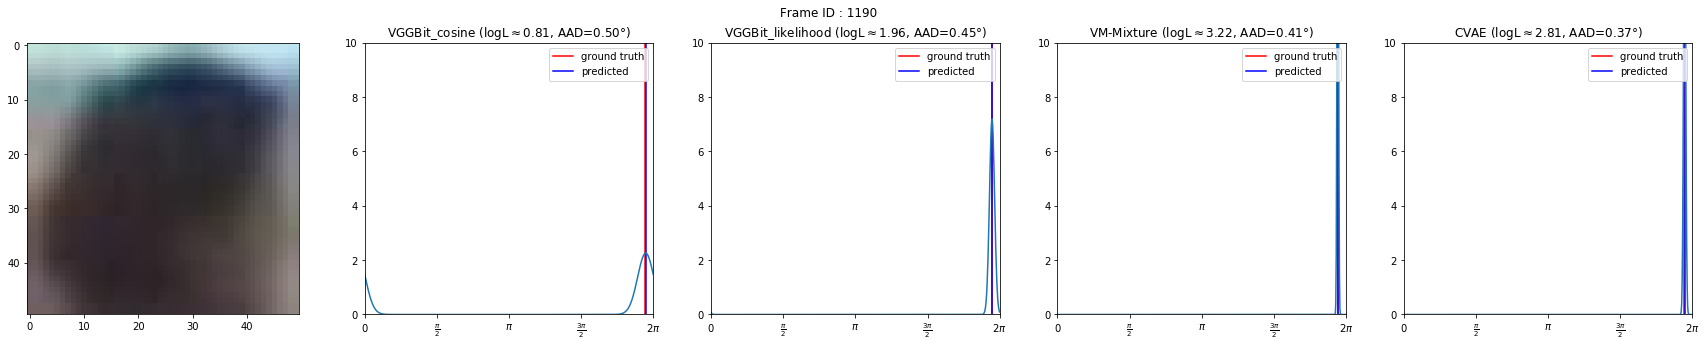

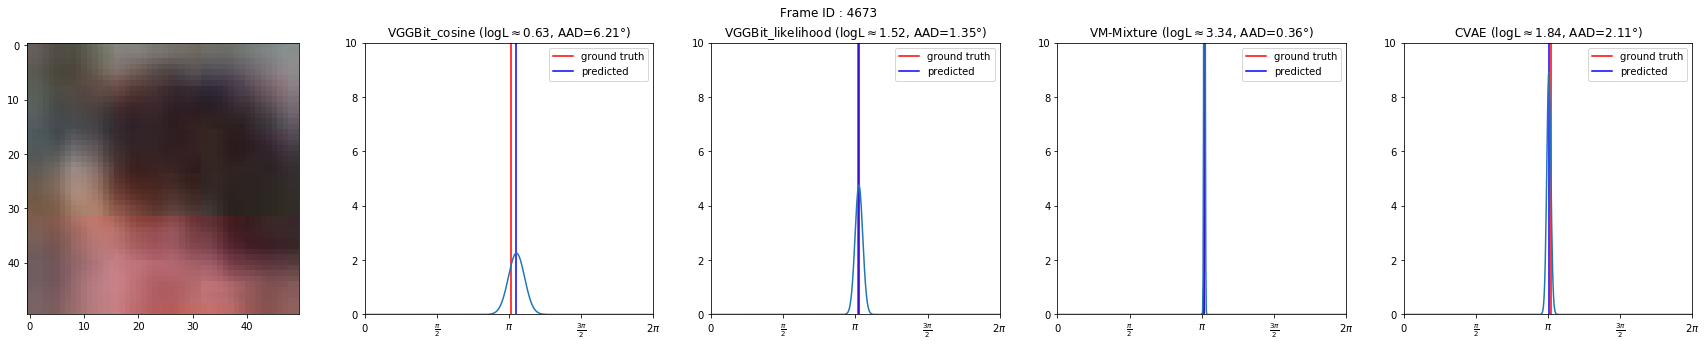

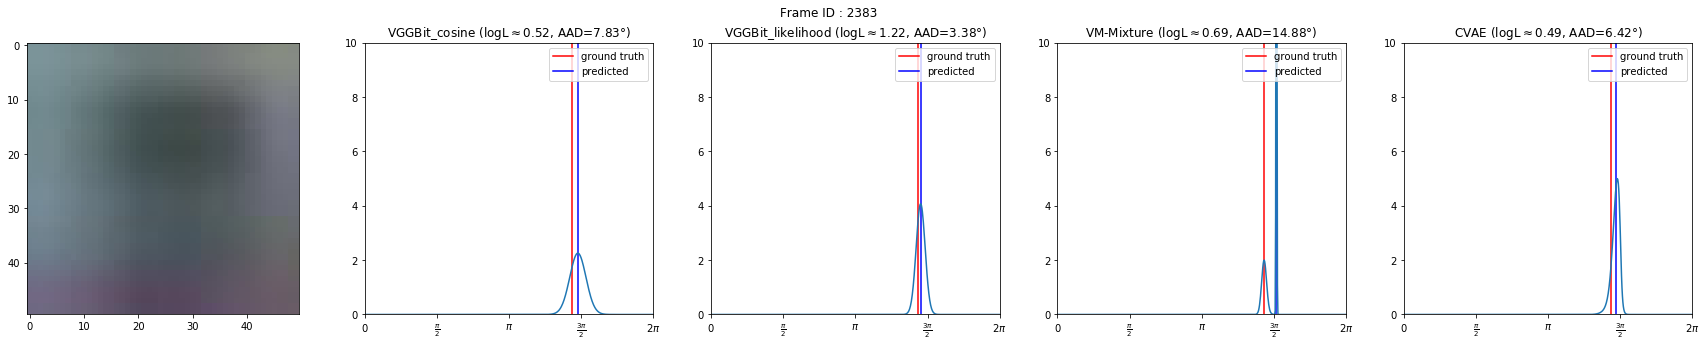

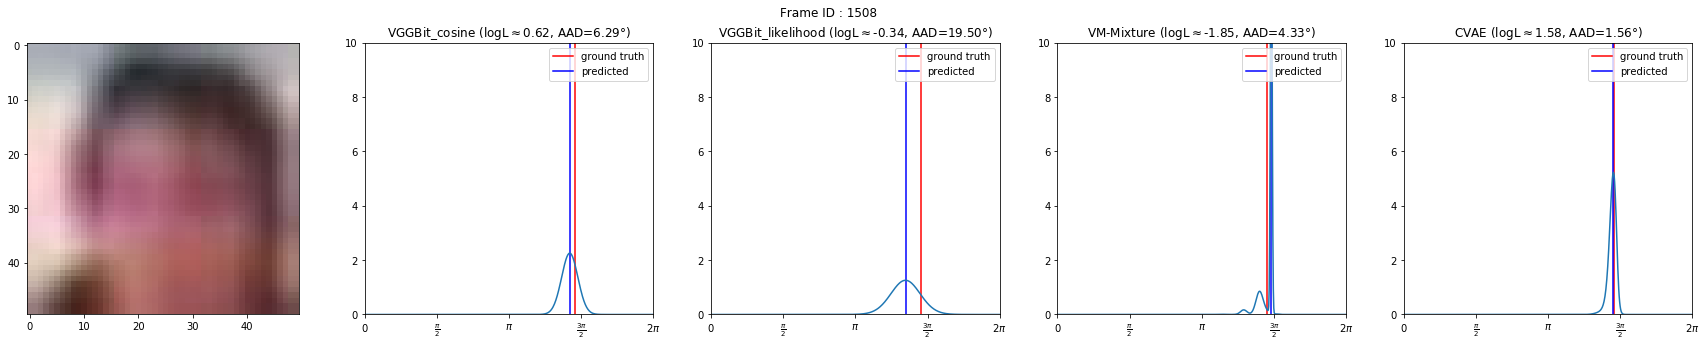

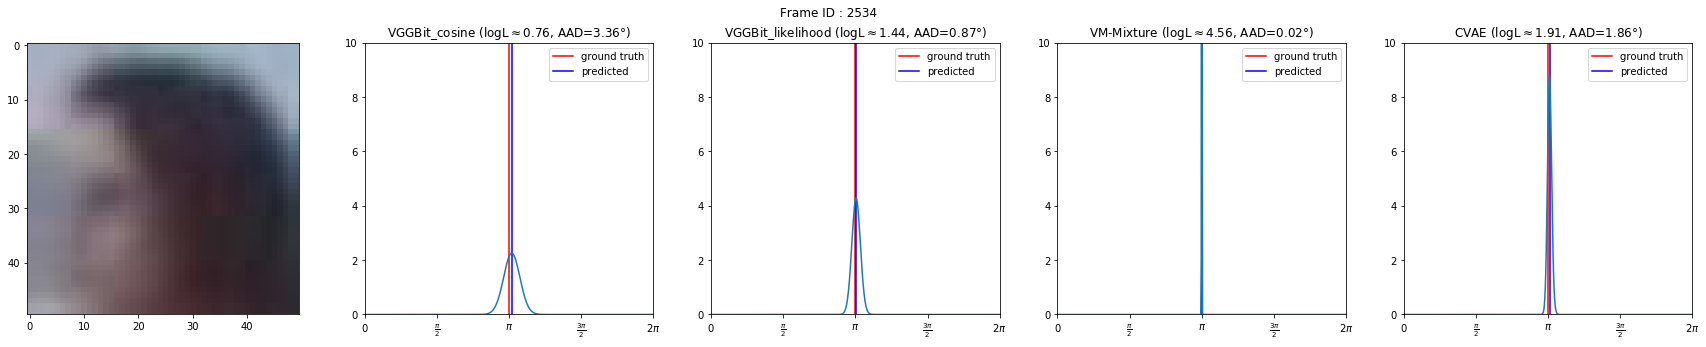

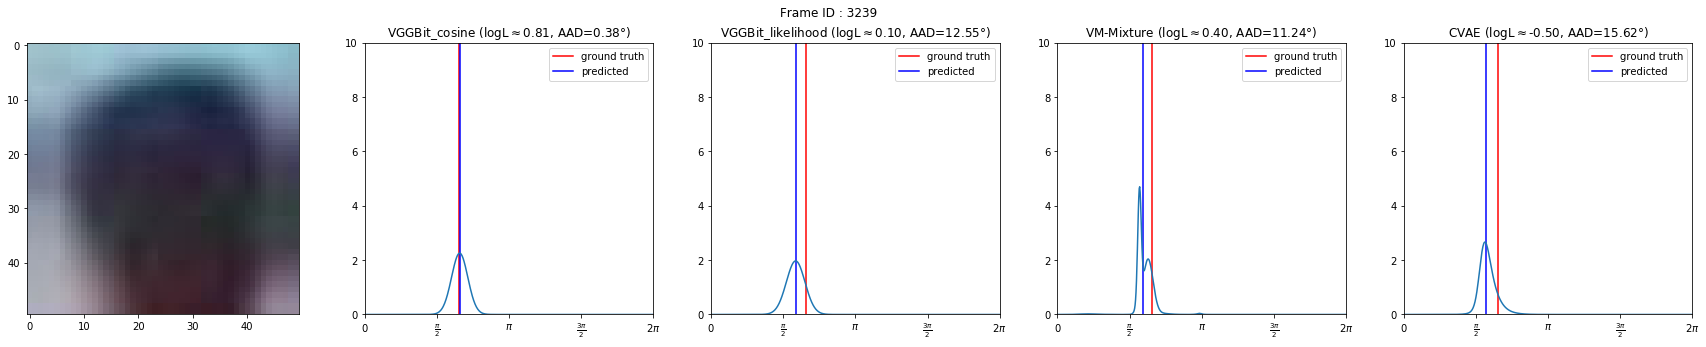

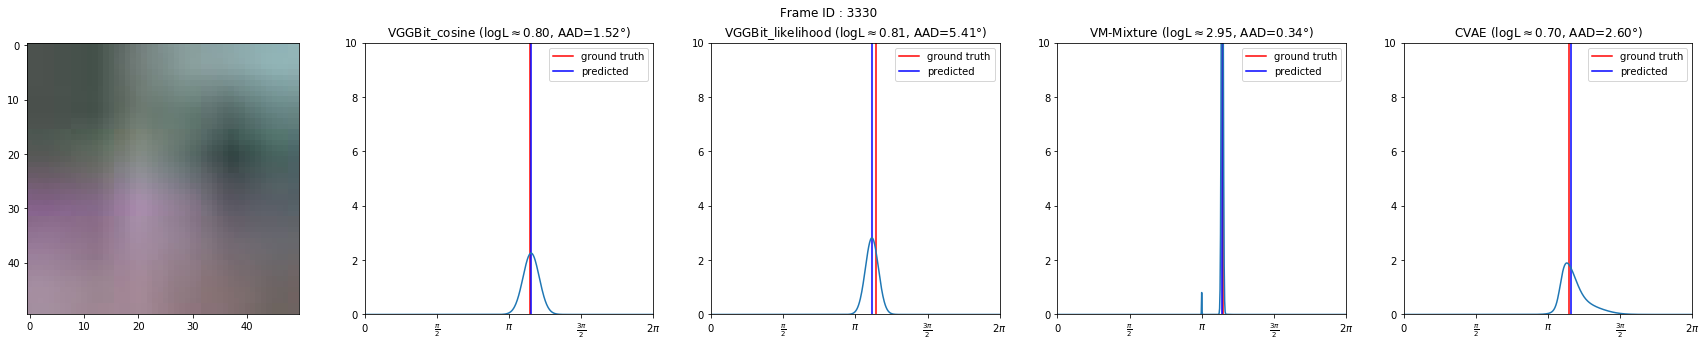

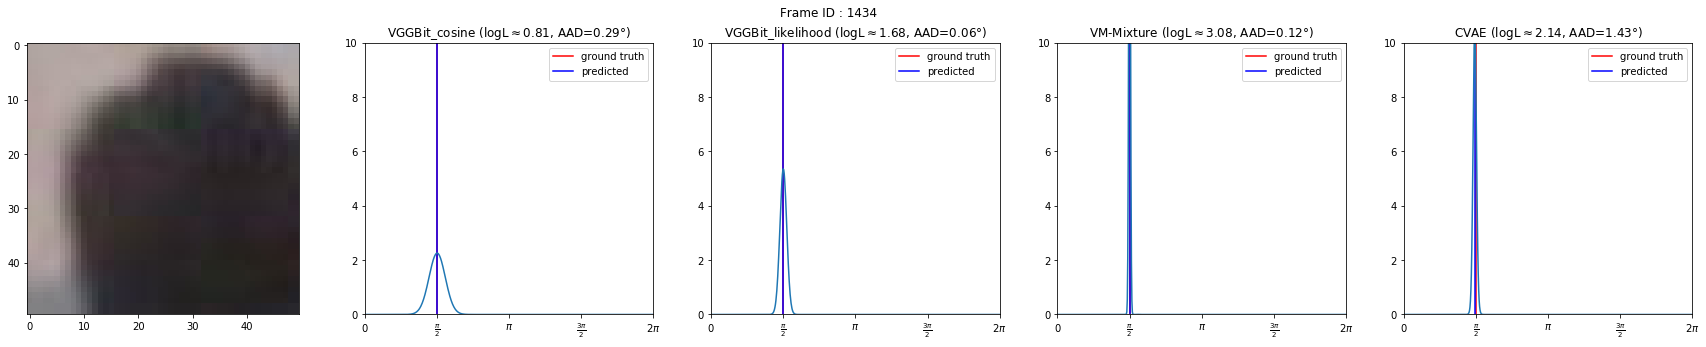

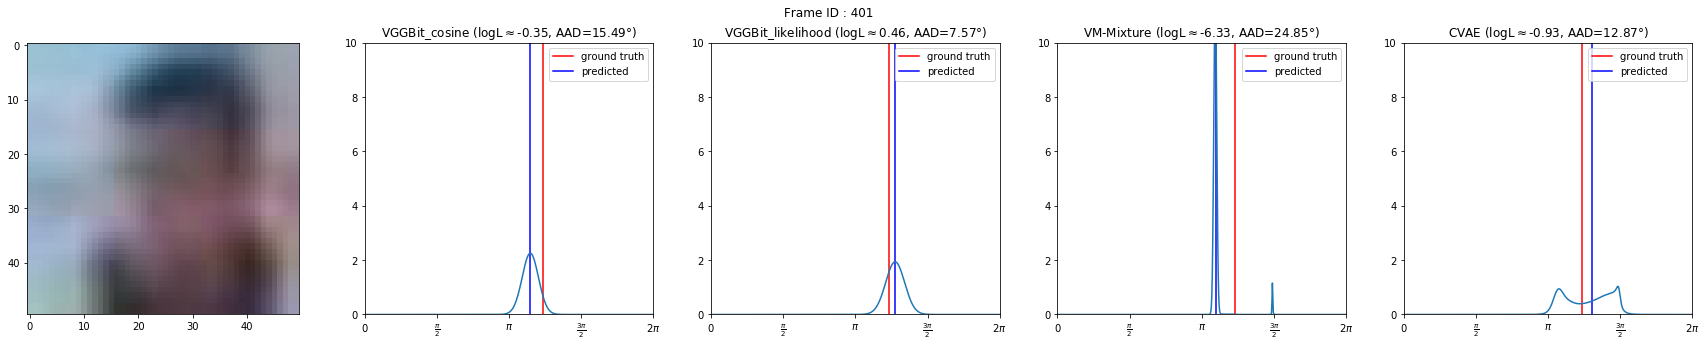

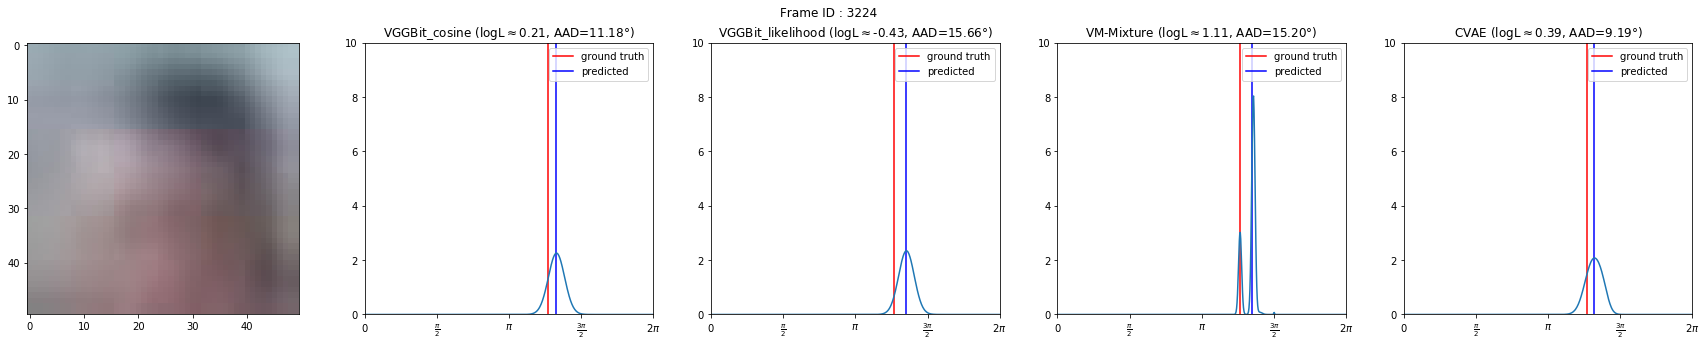

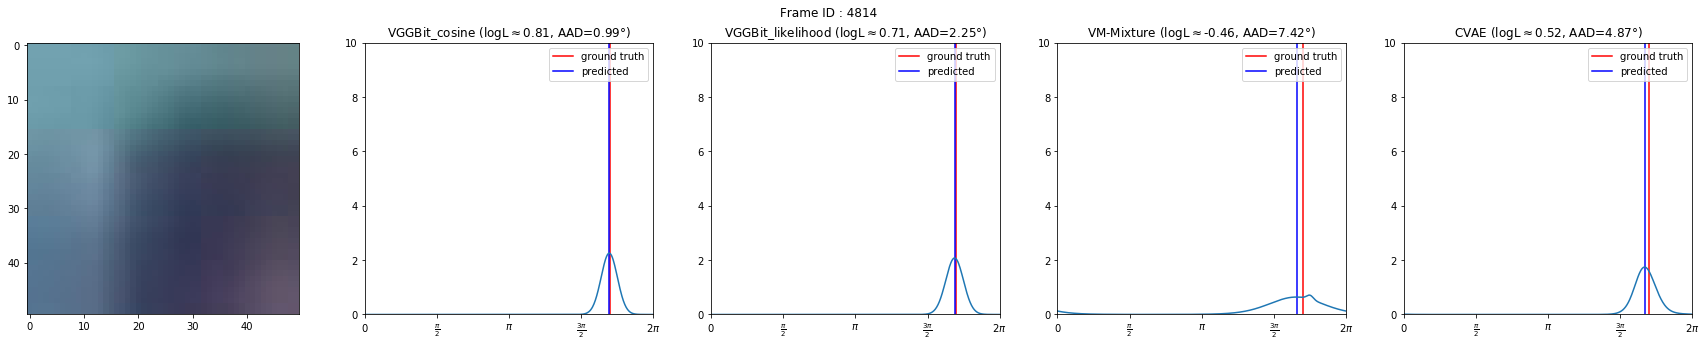

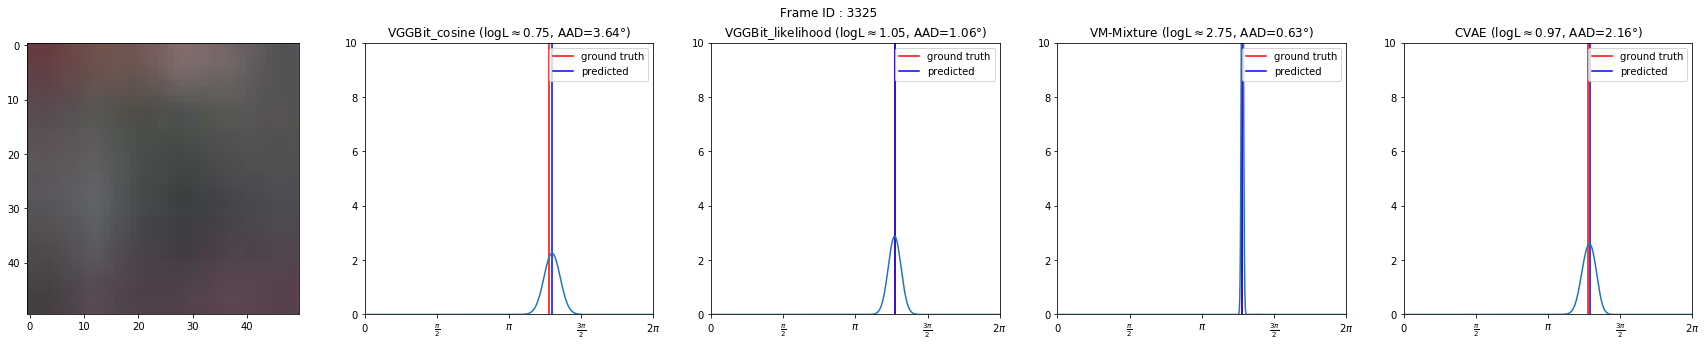

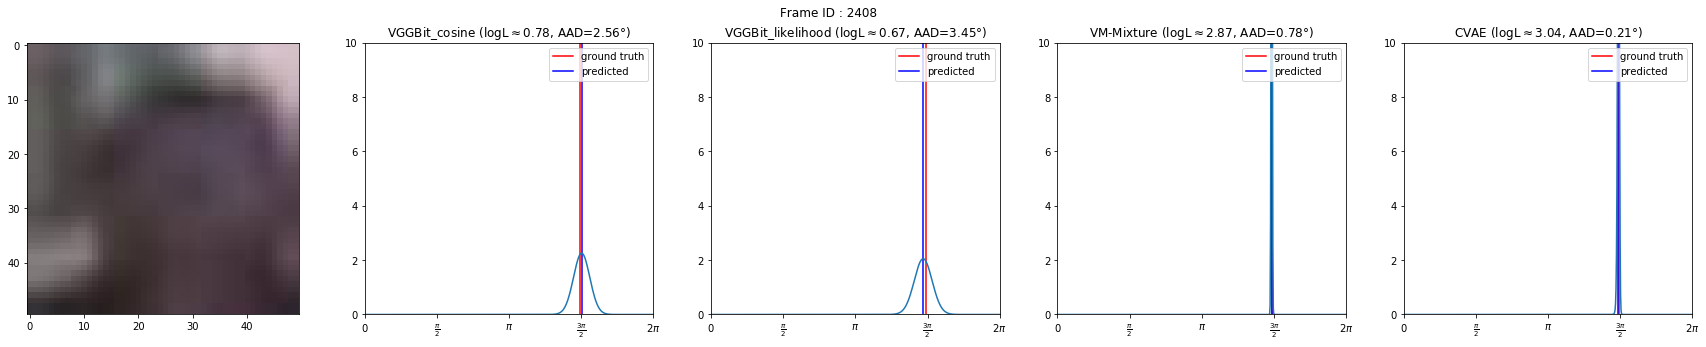

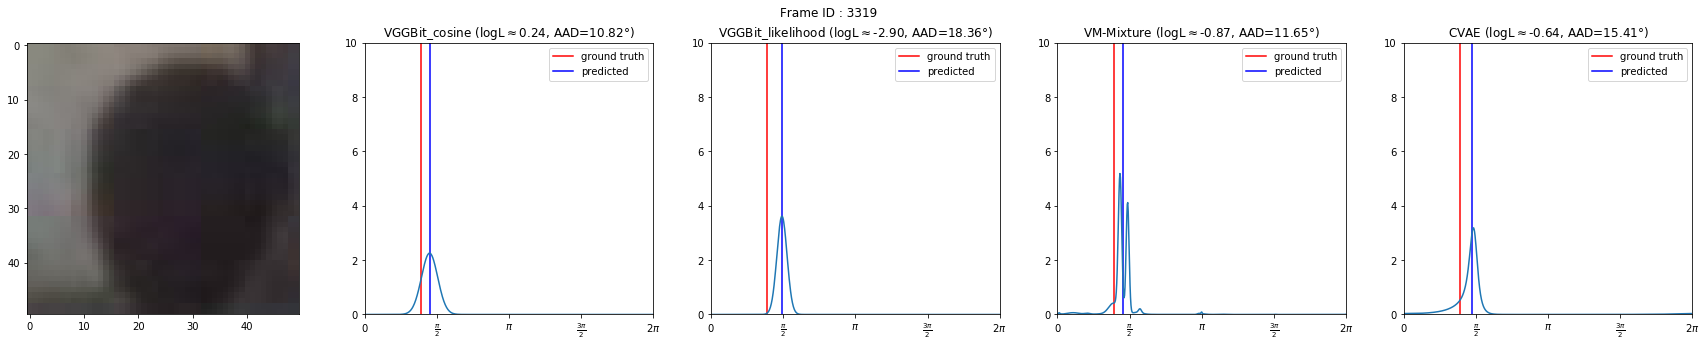

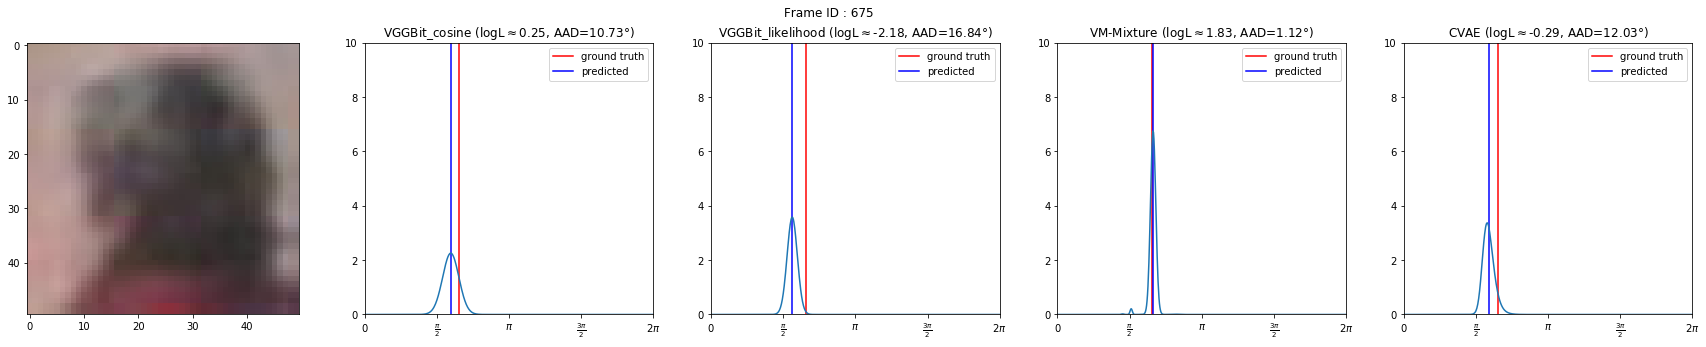

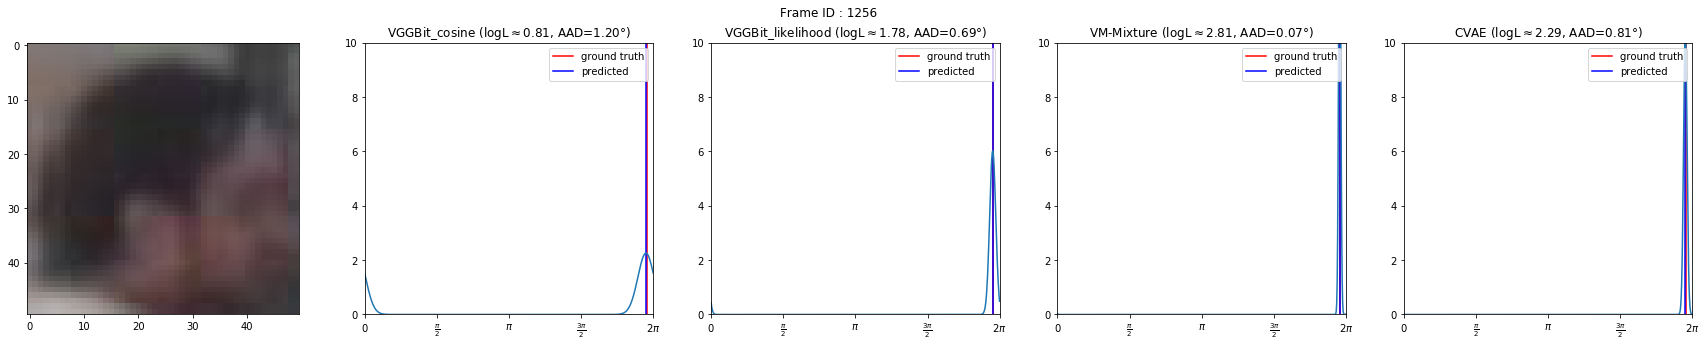

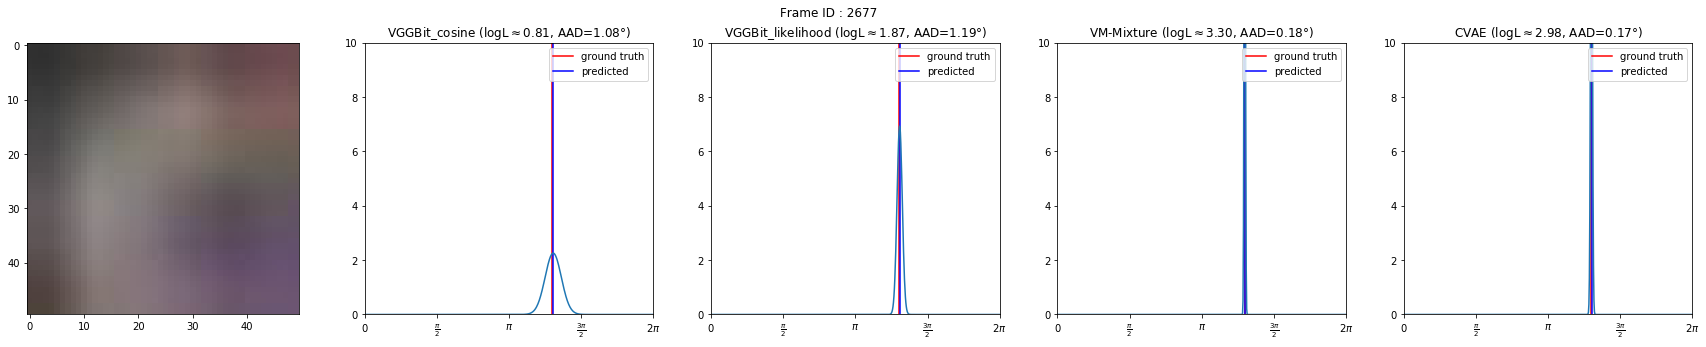

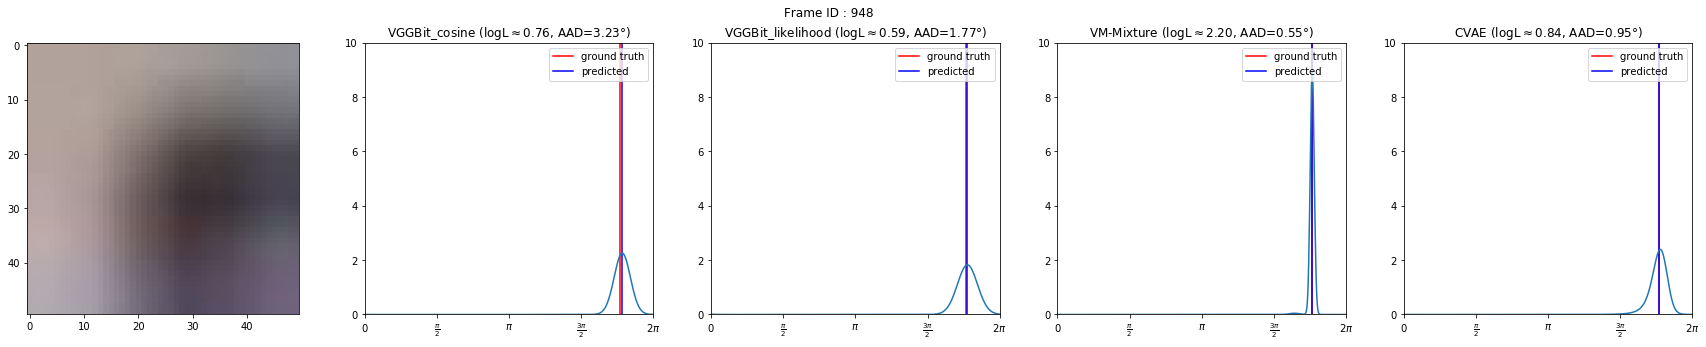

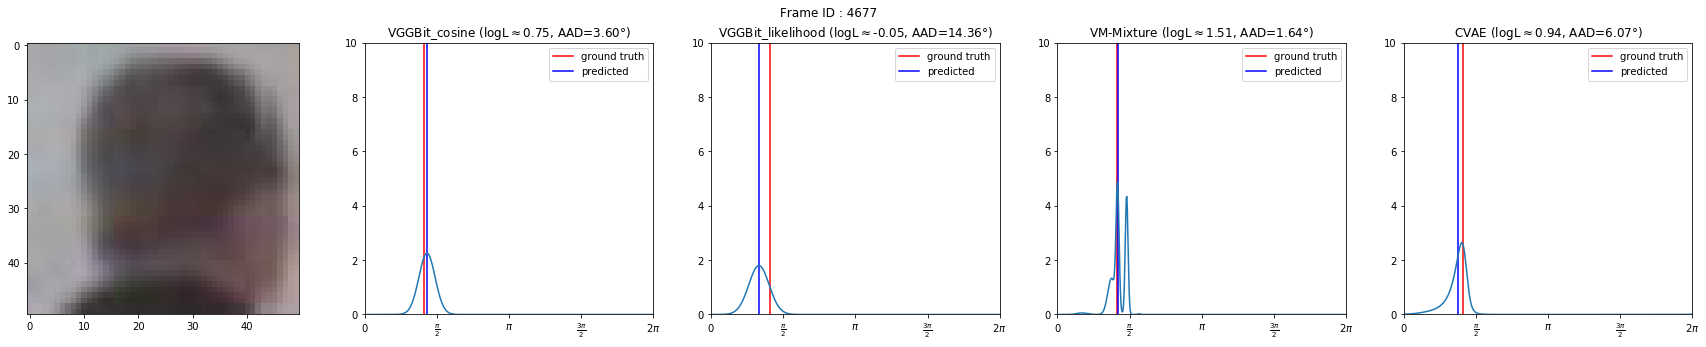

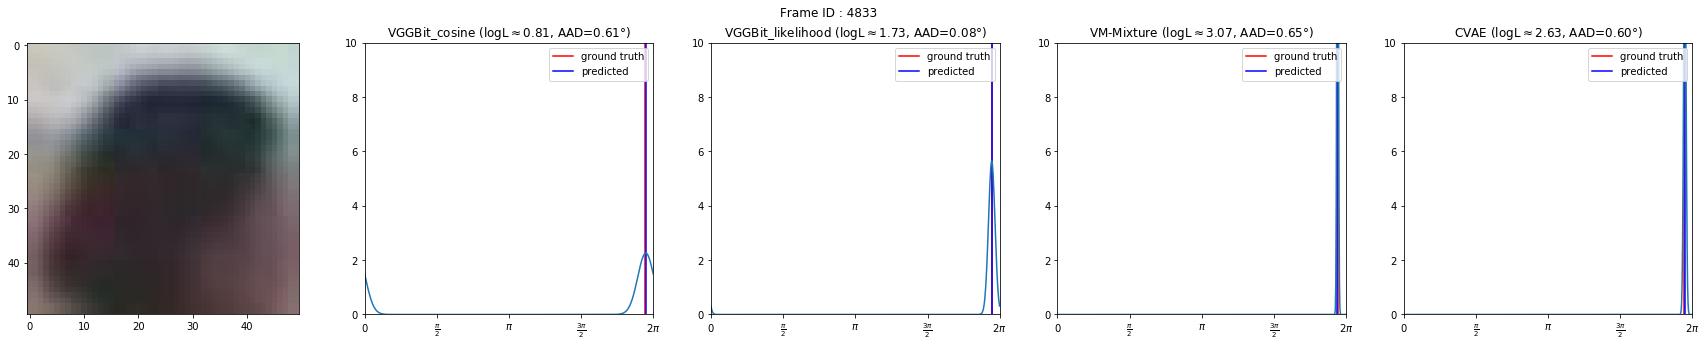

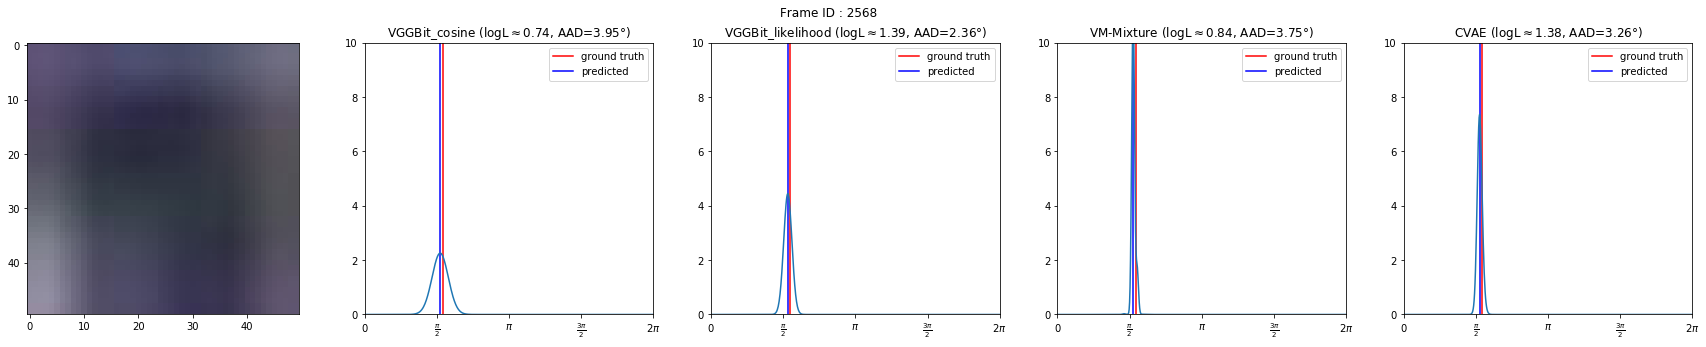

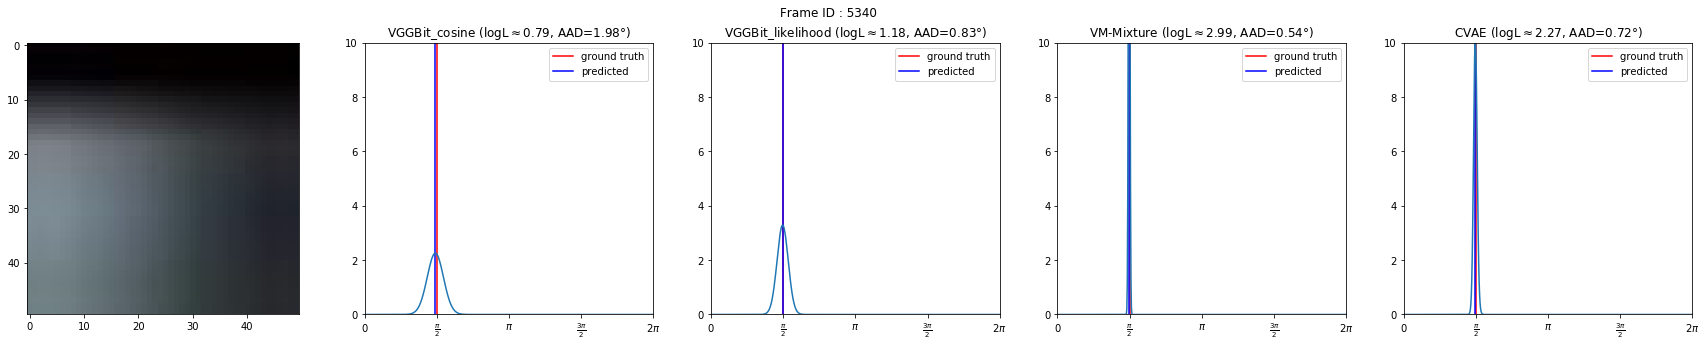

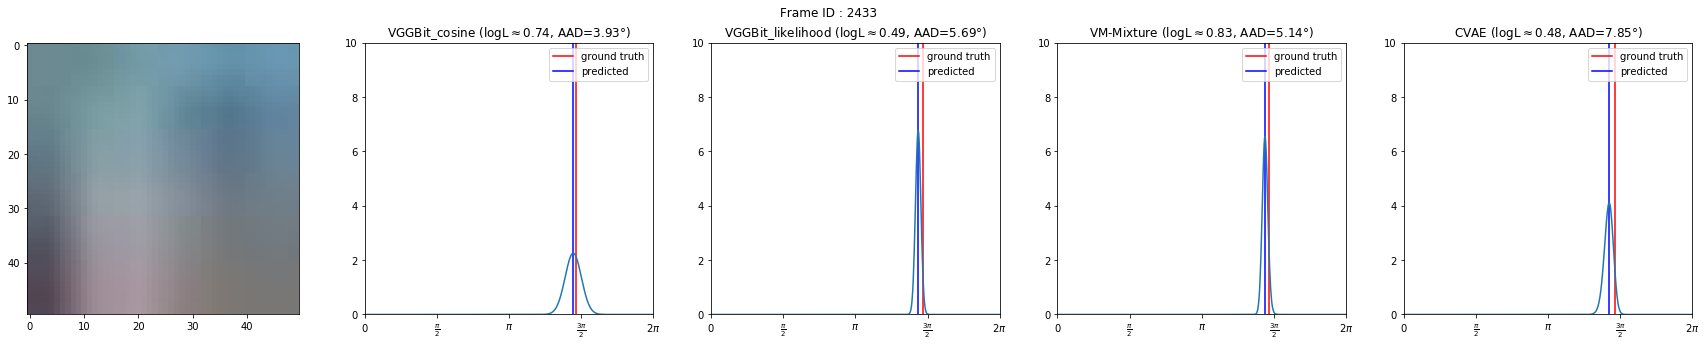

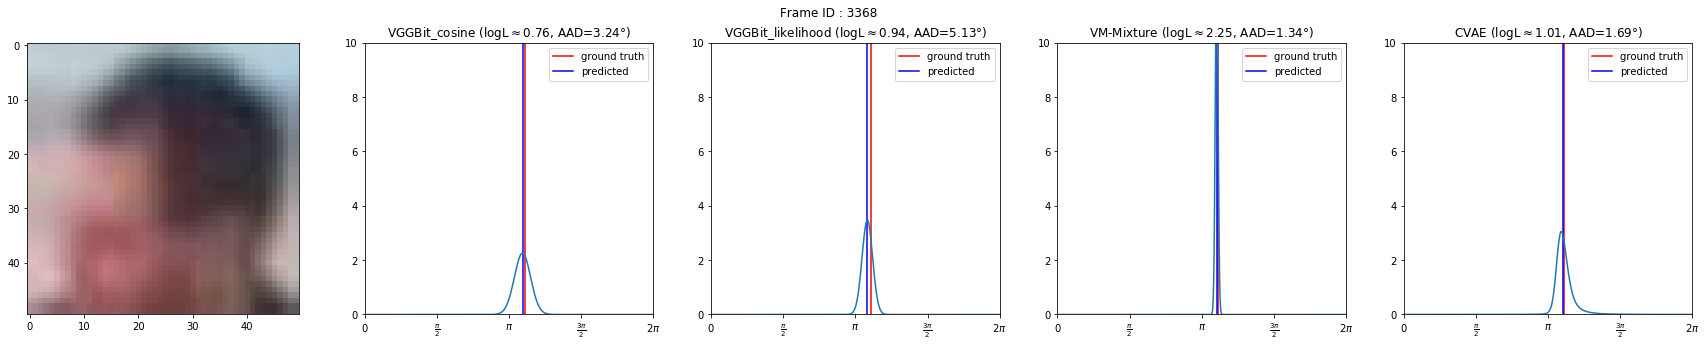

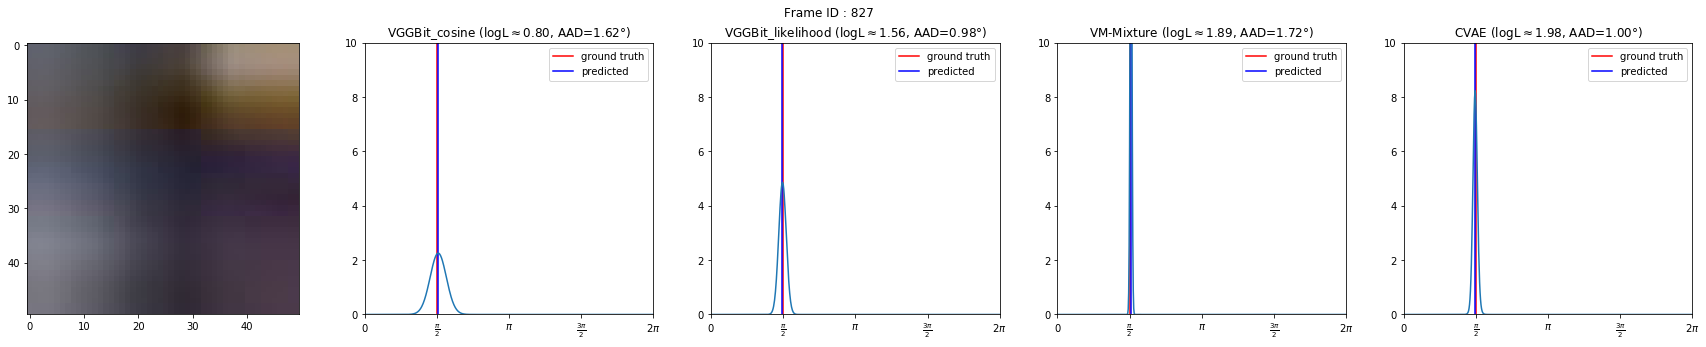

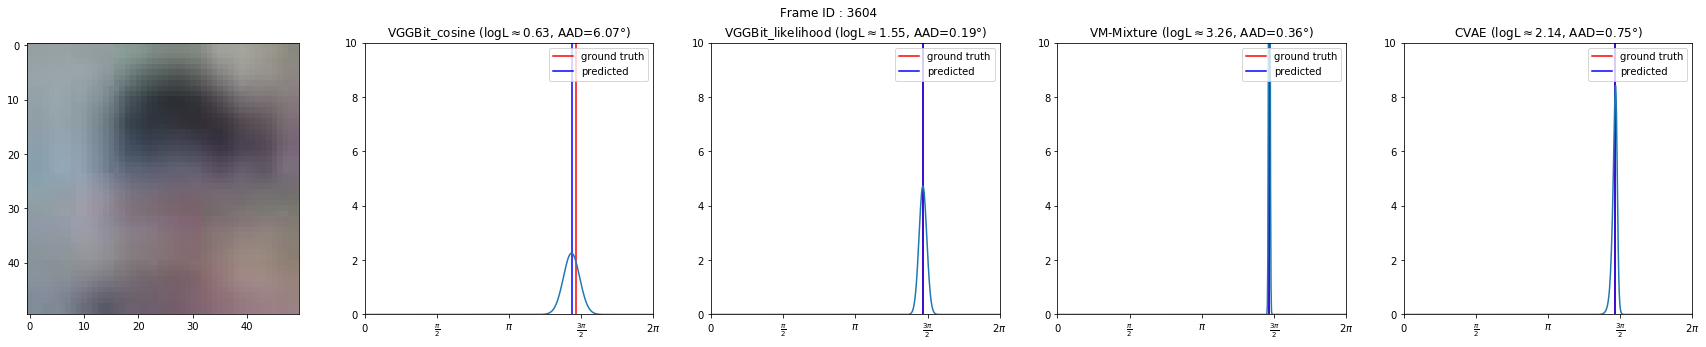

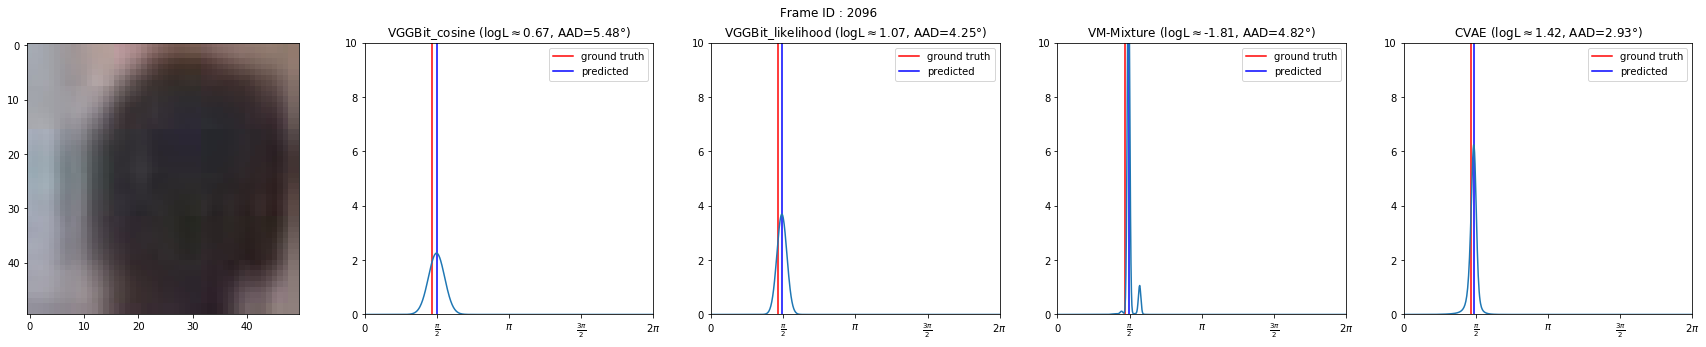

In [123]:
from utils.angles import bit2deg

yte_rad = np.deg2rad(bit2deg(yte_bit))

for fix, fid in enumerate(frames):
    
    pdfs_dict = {}
    likelihoods_dict = {}
    point_preds_dict = {}
    maad_dict = {}
    pdfs_dict['VGGBit_cosine'] = vggcosine_acc_pdf[fix]
    likelihoods_dict['VGGBit_cosine'] = results['cosine']['log_likelihood'][fix]
    maad_dict['VGGBit_cosine'] = results['cosine']['maad'][fix]
    point_preds_dict['VGGBit_cosine'] = results['cosine']['point_preds'][fix]
    pdfs_dict['VGGBit_likelihood'] = vgglikelihood_acc_pdf[fix]
    likelihoods_dict['VGGBit_likelihood'] = results['likelihood']['log_likelihood'][fix]
    maad_dict['VGGBit_likelihood'] = results['likelihood']['maad'][fix]
    point_preds_dict['VGGBit_likelihood'] = results['likelihood']['point_preds'][fix]
    pdfs_dict['VM-Mixture'] = vmmix_acc_pdf[fix]
    likelihoods_dict['VM-Mixture'] = results['mixture']['log_likelihood'][fix]
    maad_dict['VM-Mixture'] = results['mixture']['maad'][fix]
    point_preds_dict['VM-Mixture'] = results['mixture']['point_preds'][fix]
    pdfs_dict['CVAE'] = cvae_acc_pdfs[fix]
    likelihoods_dict['CVAE'] = results['cvae']['importance_log_likelihood'][fix]
    maad_dict['CVAE'] = results['cvae']['maad'][fix]
    point_preds_dict['CVAE'] = results['cvae']['point_preds'][fix]
    #plot_image_results(xte[fid], xvals, cvae_acc_pdfs[fid], cvae_samples_pdfs[fid], yte_rad[fid])
    plot_image_results(xte[fid], fid, xvals,  pdfs_dict, likelihoods_dict, maad_dict, point_preds_dict, yte_rad[fid])

#### Important examples

In [227]:
certain_frame_id = 867
uncertain_frame_id = 4598

vgglikelihood_acc_pdf = vggbit_likelihood_model.pdf(xte[[certain_frame_id, uncertain_frame_id]], xvals)

frames =  [certain_frame_id, uncertain_frame_id] #np.arange(starting_frame, starting_frame+n_frames)

n_samples = 50

xvals =  np.arange(0, 2*np.pi, 0.01)

results = eval_all_models(xte[frames], yte_deg[frames], 'mini_test', eval_cvae=True, n_samples=n_samples)

pdfs_dict = {}

vggcosine_acc_pdf = vggbit_cosine_model.pdf(xte[frames], xvals)

vgglikelihood_acc_pdf = vggbit_likelihood_model.pdf(xte[frames], xvals)

vmmix_pdfs, vmmix_acc_pdf = vmmix_model.pdf(xte[frames], xvals)

cvae_samples_pdfs, cvae_acc_pdfs = cvae_model.pdf(xte[frames], xvals, n_samples=n_samples)

*****EVALUATING ON mini_test*****
evaluating VGGBit (cosine loss)..
MAAD error (mini_test) : 18.963629 pm 14.434302SEM
log-likelihood (mini_test) : -1.878154 pm 2.592150SEM
evaluating VGGBit (likelihood loss)..
MAAD error (mini_test) : 20.673559 pm 16.341376SEM
log-likelihood (mini_test) : -0.153787 pm 1.250253SEM
evaluating VM-Mixture..
MAAD error (mini_test) : 28.256723 pm 27.879701SEM
log-likelihood (mini_test) : 1.394757 pm 1.221963SEM
evaluating CVAE..
MAAD error (mini_test) : 20.421627 pm 18.236324SEM
ELBO (mini_test) : 0.256355 pm 1.308929SEM
Approx Log-Likelihood, importance sampling (mini_test) : 0.388895 pm 1.200570SEM
KL-div (mini_test) : 0.423866 pm0.412172SEM


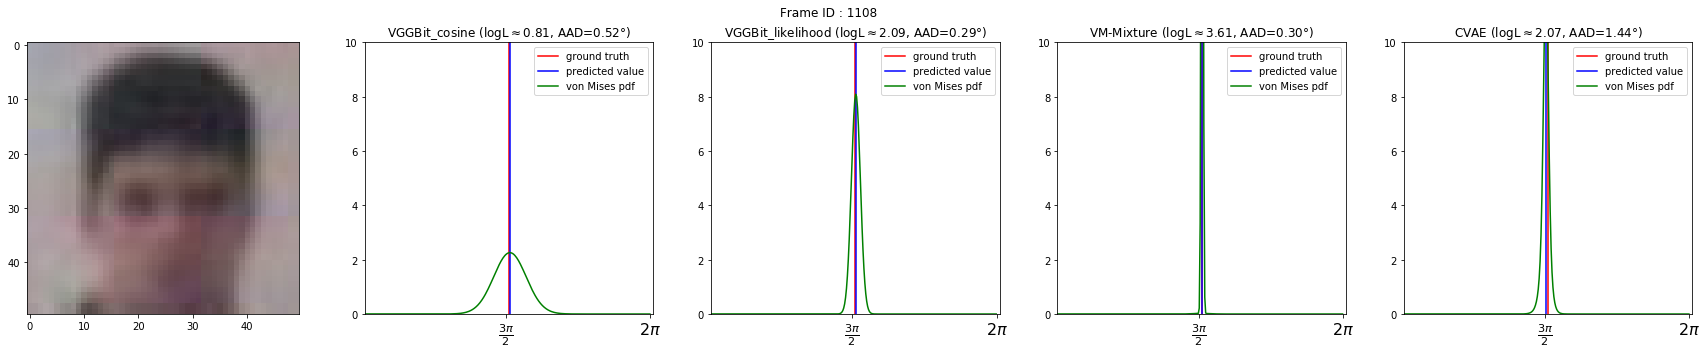

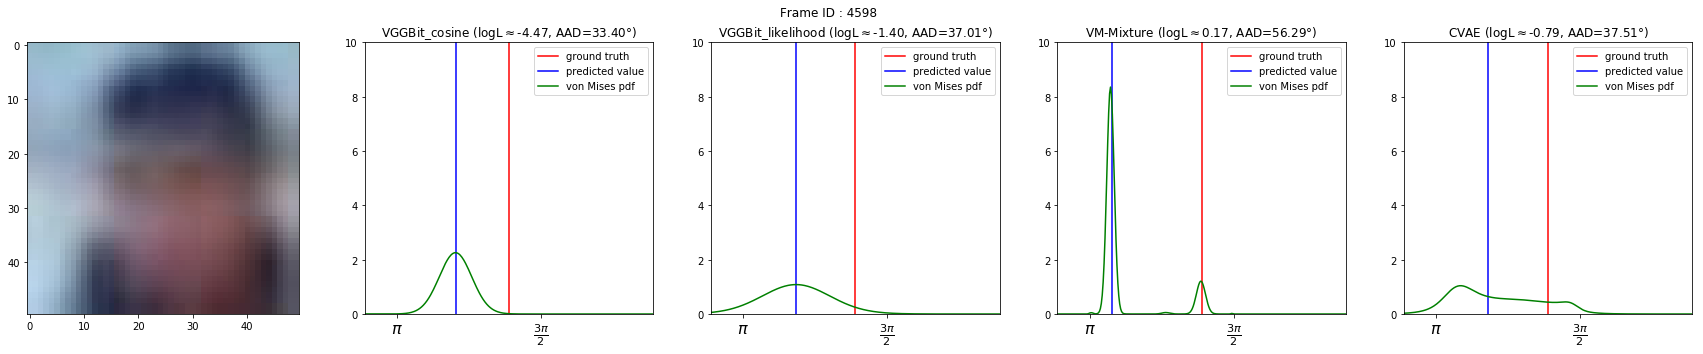

In [222]:
from utils.angles import bit2deg

yte_rad = np.deg2rad(bit2deg(yte_bit))

for fix, fid in enumerate(frames):
    
    pdfs_dict = {}
    likelihoods_dict = {}
    point_preds_dict = {}
    maad_dict = {}
    pdfs_dict['VGGBit_cosine'] = vggcosine_acc_pdf[fix]
    likelihoods_dict['VGGBit_cosine'] = results['cosine']['log_likelihood'][fix]
    maad_dict['VGGBit_cosine'] = results['cosine']['maad'][fix]
    point_preds_dict['VGGBit_cosine'] = results['cosine']['point_preds'][fix]
    pdfs_dict['VGGBit_likelihood'] = vgglikelihood_acc_pdf[fix]
    likelihoods_dict['VGGBit_likelihood'] = results['likelihood']['log_likelihood'][fix]
    maad_dict['VGGBit_likelihood'] = results['likelihood']['maad'][fix]
    point_preds_dict['VGGBit_likelihood'] = results['likelihood']['point_preds'][fix]
    pdfs_dict['VM-Mixture'] = vmmix_acc_pdf[fix]
    likelihoods_dict['VM-Mixture'] = results['mixture']['log_likelihood'][fix]
    maad_dict['VM-Mixture'] = results['mixture']['maad'][fix]
    point_preds_dict['VM-Mixture'] = results['mixture']['point_preds'][fix]
    pdfs_dict['CVAE'] = cvae_acc_pdfs[fix]
    likelihoods_dict['CVAE'] = results['cvae']['importance_log_likelihood'][fix]
    maad_dict['CVAE'] = results['cvae']['maad'][fix]
    point_preds_dict['CVAE'] = results['cvae']['point_preds'][fix]
    #plot_image_results(xte[fid], xvals, cvae_acc_pdfs[fid], cvae_samples_pdfs[fid], yte_rad[fid])
    plot_image_results(xte[fid], fid, xvals,  pdfs_dict, likelihoods_dict, maad_dict, point_preds_dict, yte_rad[fid])

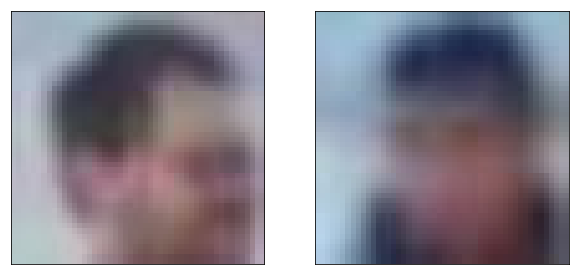

In [277]:
def plot_certain_uncertain(certain_frame, unceratin_frame):

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    axs[0].imshow(certain_frame)
    axs[0].set_xticks([])
    axs[0].set_yticks([])

    axs[1].imshow(unceratin_frame)
    axs[1].set_xticks([])
    axs[1].set_yticks([])

    fig.savefig('certain_uncertain.png', dpi=100)
    
    return

plot_certain_uncertain(xte[certain_frame_id], xte[uncertain_frame_id])

In [294]:
def plot_pdf_paper(axis, xvals, pdf, ypred_rad=None, gt_val_rad=None, title='', show_legend=True):
    
    axis.set_xticks(([0., .5*np.pi, np.pi, 1.5*np.pi, 2*np.pi]))
    axis.set_xticklabels(["$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"], fontsize=25) 
    axis.set_yticklabels(np.arange(0, 10), fontsize=20)
    #axis.set_xlim([-0.001, 2*np.pi+0.001])
    axis.set_xlim([gt_val_rad-0.5*np.pi, gt_val_rad+0.5*np.pi])
    axis.set_ylim([0, 10.0])
    if gt_val_rad is not None:
        axis.axvline(gt_val_rad, linewidth=3, color='red', label='$\phi_{true}$')
    axis.plot(xvals, pdf, linewidth=3, color='green', label='$p_{\\theta}(\phi | x)$')
    if ypred_rad is not None:
        axis.axvline(ypred_rad, linewidth=3, ls='dashed', color='green', label='$\mu_{\\theta}(x)$')
    if show_legend:
        axis.legend(fontsize=24)
    axis.set_title(title)
    return

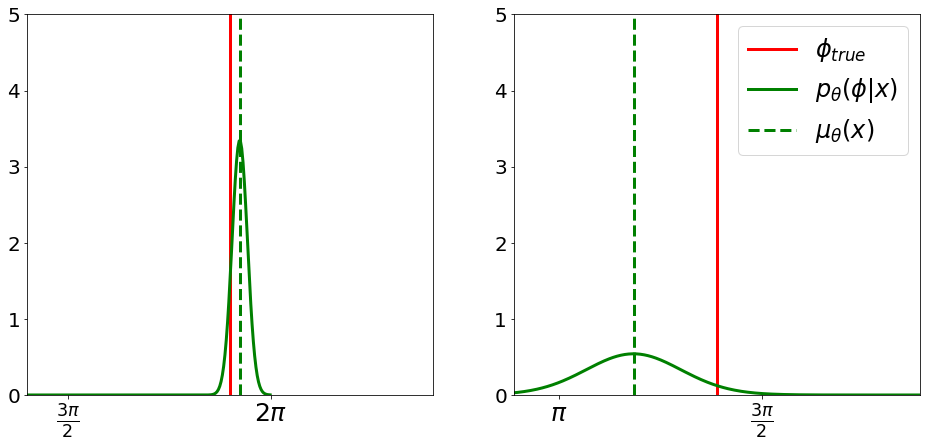

In [297]:
fig, axs = plt.subplots(1, 2, figsize=(16, 7))

ypreds = np.deg2rad(results['likelihood']['point_preds'])

plot_pdf_paper(axs[0], xvals, vgglikelihood_acc_pdf[0], gt_val_rad=yte_rad[certain_frame_id], ypred_rad=ypreds[0], show_legend=False)
plot_pdf_paper(axs[1], xvals, vgglikelihood_acc_pdf[1], gt_val_rad=yte_rad[uncertain_frame_id], ypred_rad=ypreds[1], show_legend=True)

#plot_pdf(axs[0], xvals, vgglikelihood_acc_pdf[0], gt_val_rad=yte_rad[certain_frame_id], ypred_rad=None, show_legend=False)
#plot_pdf(axs[1], xvals, vgglikelihood_acc_pdf[1], gt_val_rad=yte_rad[uncertain_frame_id], ypred_rad=None, show_legend=True)


fig.savefig('adjusted_densities.png', dpi=300)

#### CVAE demo

In [ ]:
n_samples = 50
n_frames = 20
demo_frames = np.random.randint(0, len(xte), n_frames)
x_demo = xte[demo_frames]

cvae_samples_pdfs, cvae_acc_pdfs = cvae_model.pdf(x_demo, xvals, n_samples=n_samples)

for fid in range(0, n_frames):
    fig, axs = plt.subplots(1, 2, figsize=(30, 5))
    for sid in range(0, n_samples):
        axs[0].imshow(x_demo[fid])
        plot_pdf(axs[1], xvals, cvae_samples_pdfs[fid, sid,:])
    fig.show()